### Preamble

In [3]:
%pip install tldextract
%pip install cryptography
%pip install seaborn
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install matplotlib-venn
%pip install pytricia
%pip install pyasn
# restart the python kernel if packages are freshly installed

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

In [1]:
%run ./spark-instance-gustavo.ipynb

SparkConf created
Started SparkSession
Spark version 3.5.0


In [2]:
clean_spark()

In [3]:
%matplotlib inline

# system imports
from collections import defaultdict
from datetime import datetime
from fnmatch import fnmatch
import math
from glob import glob
import os
import statistics
import hashlib
import json
import copy
import re
import operator

# installed packages import
import matplotlib.pyplot as plt
from matplotlib import lines as mlines
import pandas as pd
import numpy as np
import tldextract
from cryptography import x509
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives.hashes import Hash
import seaborn as sns
import ipaddress
import pytricia

# pyspark imports
from pyspark.errors import *
import pyspark.sql.types as pst
import pyspark.sql.functions as psf
from pyspark.storagelevel import StorageLevel
from pyspark.sql.window import Window
import pyspark.pandas as ps

# local imports

/usr/local/spark/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [4]:
# copied straight from https://github.com/kennethreitz/requests/blob/master/src/requests/structures.py
from collections import OrderedDict
from collections.abc import MutableMapping


class CaseInsensitiveDict(MutableMapping):
    """A case-insensitive ``dict``-like object.

    Implements all methods and operations of
    ``MutableMapping`` as well as dict's ``copy``. Also
    provides ``lower_items``.

    All keys are expected to be strings. The structure remembers the
    case of the last key to be set, and ``iter(instance)``,
    ``keys()``, ``items()``, ``iterkeys()``, and ``iteritems()``
    will contain case-sensitive keys. However, querying and contains
    testing is case insensitive::

        cid = CaseInsensitiveDict()
        cid['Accept'] = 'application/json'
        cid['aCCEPT'] == 'application/json'  # True
        list(cid) == ['Accept']  # True

    For example, ``headers['content-encoding']`` will return the
    value of a ``'Content-Encoding'`` response header, regardless
    of how the header name was originally stored.

    If the constructor, ``.update``, or equality comparison
    operations are given keys that have equal ``.lower()``s, the
    behavior is undefined.
    """

    def __init__(self, data=None, **kwargs):
        self._store = OrderedDict()
        if data is None:
            data = {}
        self.update(data, **kwargs)

    def __setitem__(self, key, value):
        # Use the lowercased key for lookups, but store the actual
        # key alongside the value.
        self._store[key.lower()] = (key, value)

    def __getitem__(self, key):
        return self._store[key.lower()][1]

    def __delitem__(self, key):
        del self._store[key.lower()]

    def __iter__(self):
        return (casedkey for casedkey, mappedvalue in self._store.values())  # wrong?

    def __len__(self):
        return len(self._store)

    def lower_items(self):
        """Like iteritems(), but with all lowercase keys."""
        return ((lowerkey, keyval[1]) for (lowerkey, keyval) in self._store.items())

    def __eq__(self, other):
        if isinstance(other, MutableMapping):  # changed this line
            other = CaseInsensitiveDict(other)
        else:
            return NotImplemented
        # Compare insensitively
        return dict(self.lower_items()) == dict(other.lower_items())

    # Copy is required
    def copy(self):
        return CaseInsensitiveDict(self._store.values())

    def __repr__(self):
        return str(dict(self.items()))


In [1026]:
from ip_as_org import IPASnPrefix, ASOrg

def get_ip_asn_as_org_obj(timestamps):
    dates = [ts.strftime("%Y%m%d") for ts in timestamps]
    dataset_dir = "../dataset/"
    ip_asn = IPASnPrefix(dates, dataset_dir)
    as_org = ASOrg(dates, dataset_dir)
    return ip_asn, as_org

def ip_to_country(ip: str, when: str) -> str:
    asn = ip_asn.get_asn_from_ip(ip, when)
    if asn is None:
        return "Unknown"
    try:
        country = as_org.get_country_from_asn(asn, when)
    except ValueError:
        country = "Unknown"
    return country

def ip_to_org(ip: str, when: str) -> str:
    asn = ip_asn.get_asn_from_ip(ip, when)
    if asn is None:
        return "Unknown"
    try:
        org = as_org.get_org_name_from_asn(asn, when)
    except ValueError:
        org = "Unknown"
    return org


ip_to_country_udf = psf.udf(ip_to_country, pst.StringType())
ip_to_org_udf = psf.udf(ip_to_org, pst.StringType())

In [698]:
ps.set_option('compute.ops_on_diff_frames', True)
pd.options.plotting.backend = 'matplotlib'

plt.rcParams["font.family"] = 'Nimbus Roman'   #"Times"
sns.set_theme(font='Nimbus Roman')
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})  # "whitegrid"
sns.set_palette("husl", 7)
sns.color_palette("husl", 7)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.7757319041862729, 0.5784925270759935, 0.19475566538551875),
 (0.5105309046900421, 0.6614299289084904, 0.1930849118538962),
 (0.20433460114757862, 0.6863857739476534, 0.5407103379425205),
 (0.21662978923073606, 0.6676586160122123, 0.7318695594345369),
 (0.5049017849530067, 0.5909119231215284, 0.9584657252128558),
 (0.9587050080494409, 0.3662259565791742, 0.9231469575614251)]

### Functions helper for Goscanner data

In [371]:
#####################
### LOAD DATA
#####################
def load_hosts_data(port, ts):
    hosts_base_path = HOSTS_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    hosts_df = spark.read.option("header", "true") \
                         .option("lineSep", "\n") \
                         .option("quote", "\"") \
                         .option("escape", "\"") \
                         .option("inferSchema", "true") \
                         .csv(f"../dataset/{hosts_base_path}")
    return hosts_df


def load_certs_data(port, ts):
    certs_base_path = CERTS_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    certs_df = spark.read.option("header", "true") \
                         .option("multiline", "true") \
                         .option("wholeFile", "true") \
                         .option("inferSchema", "true") \
                         .csv(f"../dataset/{certs_base_path}")
    return certs_df


def load_tls_data(port, ts):
    tls_base_path = TLS_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    tls_df = spark.read.option("header", "true") \
                       .option("multiline", "true") \
                       .option("wholeFile", "true") \
                       .option("inferSchema", "true") \
                       .csv(f"../dataset/{tls_base_path}")
    return tls_df


def load_ldap_data(port, ts):
    ldap_base_path = LDAP_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    ldap_df = spark.read.option("header", "true") \
                        .option("lineSep", "\n") \
                        .option("quote", "\"") \
                        .option("escape", "\"") \
                        .option("inferSchema", "true") \
                        .csv(f"../dataset/{ldap_base_path}")
    return ldap_df


def load_ldapstarttls_data(port, ts):
    starttls_base_path = STARTTLS_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    starttls_df = spark.read.option("header", "true") \
                            .option("lineSep", "\n") \
                            .option("quote", "\"") \
                            .option("escape", "\"") \
                            .option("inferSchema", "true") \
                            .csv(f"../dataset/{starttls_base_path}")
    return starttls_df


def load_cert_validator(port, ts):
    cert_validator_base_path = CERTVAL_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    df = spark.read.option("basePath", f"../dataset/{cert_validator_base_path}")\
                   .parquet(f"../dataset/{cert_validator_base_path}")
    return df


def convert_ldap_attributes(df):
    df = df.withColumn("asd", eval_list_list_str_udf(psf.col("attribute_names")))
    df = df.drop("attribute_names")
    df = df.withColumnRenamed("asd", "attribute_names")
    df = df.withColumn("qwe", eval_list_list_list_str_udf(psf.col("attribute_values_list")))
    df = df.drop("attribute_values_list")
    df = df.withColumnRenamed("qwe", "attribute_values_list")
    return df


def flatten_ldap_metadata(df):
    df = df.select("id", "ip", "port", "result_code", "error_data", "matched_dns",
                                    psf.explode_outer(psf.arrays_zip(
                                                      df.attribute_names,
                                                      df.attribute_values_list)))
    df = df.select("id", "ip", "port", "result_code", "error_data", "matched_dns", "col.attribute_names", "col.attribute_values_list")
    df = df.select("id", "ip", "port", "result_code", "error_data", "matched_dns",
                                    psf.explode_outer(psf.arrays_zip(
                                                      df.attribute_names,
                                                      df.attribute_values_list)))
    df = df.select("id", "ip", "port", "result_code", "error_data", "matched_dns", "col.attribute_names", "col.attribute_values_list")
    df = df.withColumnRenamed("attribute_names", "attribute_name")
    return df


def flat_ldap_attr_values(df):
    # good for vendorName filters for example
    df = df.select("id", "ip", "port", "result_code", "error_data", "matched_dns", "attribute_name", psf.explode_outer(df.attribute_values_list))
    df = df.withColumnRenamed("col", "attribute_value")
    return df


def load_ldap_root_dse(port, ts):
    root_dse_base_path = ROOT_DSE_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    df = spark.read.option("header", "true") \
                   .option("multiline", "true") \
                   .option("wholeFile", "true") \
                   .option("inferSchema", "true") \
                   .csv(f"../dataset/{root_dse_base_path}")

    df = convert_ldap_attributes(df)
    return df


def load_ldap_schema(port, ts):
    schema_base_path = SCHEMA_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    df = spark.read.option("header", "true") \
                   .option("multiline", "true") \
                   .option("wholeFile", "true") \
                   .option("inferSchema", "true") \
                   .csv(f"../dataset/{schema_base_path}")

    df = convert_ldap_attributes(df)
    return df


def load_ldap_server_name(filename):
    return spark.read.option("header", "true"
                    ).option("inferSchema", "true"
                    ).csv(filename)


##########################
### UDF
##########################
def convert_output_df(df):
    df = df.select("id", "generic_error", psf.explode_outer("root_stores").alias("store_name", "result"))
    df = df.select("id", "generic_error", "store_name", "result.*")
    df = df.withColumn("vc", eval_list_list_str_udf(psf.col("valid_chains")))
    df = df.drop("valid_chains")
    df = df.withColumnRenamed("vc", "valid_chains")
    return df


len_udf = psf.udf(lambda chain: [len(x) for x in chain], pst.ArrayType(pst.IntegerType()))


def chain_len(df):
    df = df.withColumn("chain_len", len_udf(psf.col("valid_chains")))
    df.select("chain_len").groupBy(psf.col("chain_len")).count().show()
    return df


def peer_certs_len(peer_certs_str):
    peer_certs = eval_list(peer_certs_str)
    return len(peer_certs)


peer_certs_len_udf = psf.udf(peer_certs_len, pst.IntegerType())


get_list_len_udf = psf.udf(lambda l: len(l), pst.IntegerType())


def eval_list_list_list_str(my_list):
    try:
        if isinstance(my_list, str):
            return eval(my_list)
        else:
            return [[[]]]
    except:
        return [[[]]]


eval_list_list_list_str_udf = psf.udf(eval_list_list_list_str, pst.ArrayType(pst.ArrayType(pst.ArrayType(pst.StringType()))))


def eval_list_list_str(my_list):
    try:
        if isinstance(my_list, str):
            return eval(my_list)
        else:
            return [[]]
    except:
        return [[]]


eval_list_list_str_udf = psf.udf(eval_list_list_str, pst.ArrayType(pst.ArrayType(pst.StringType())))


def eval_list(my_list):
    try:
        if isinstance(my_list, str):
            return eval(my_list)
        else:
            return []
    except:
        return []


eval_udf = psf.udf(eval_list, pst.ArrayType(pst.IntegerType()))


SHORT1 = "Signed by unknown authority"
SHORT2 = "Expired/Not yet valid"
SHORT3 = "Not authorized to sign other certificates"
SHORT4 = "Too many intermediate certificates"
SHORT5 = "Unhandled critical extension"
SHORT6 = "Other errors"
SHORT7 = "Self-signed"
SHORT8 = "Valid chain"
SHORT9 = "Invalid signature"  # under SHORT1
SHORT10 = "No valid leaf certificate"
SHORT11 = "Unknown error"  # needs to be investigated


short_error_name_map = {
    'x509: certificate signed by unknown authority': SHORT1,
    'x509: certificate signed by unknown authority - With possible explanation': SHORT1,
    'x509: certificate has expired or is not yet valid': SHORT2,
    'x509: certificate is not authorized to sign other certificates': SHORT3,
    'x509: too many intermediates for path length constraint': SHORT4,
    'x509: unhandled critical extension': SHORT5,
    'x509: certificate signed by unknown authority (possibly because of "x509: invalid signature': SHORT9,
    '': SHORT8
}


def error_str(error_list, skid, akid, peer_certs_len):
    # test that all elements are empty
    if any(not element for element in error_list):
        return SHORT8

    # get the first non-empty error
    error_data = ""
    for error_data in error_list:
        if error_data != "":
            break

    parsed_error = ':'.join(error_data.split(":")[:3])
    if "certificate signed by unknown authority" in parsed_error:
        #if peer_certs_len == 1:
        if skid == "" or akid == "":
            if peer_certs_len == 1:
                return SHORT7
        elif skid == akid:
            return SHORT7

    error = short_error_name_map.get(parsed_error, None)
    if error is None:
        parsed_error = ':'.join(error_data.split(":")[:2])
        return short_error_name_map[parsed_error]
    return error


error_str_udf = psf.udf(error_str, pst.StringType())


def is_valid(root_stores):
    l = get_error_list(root_stores)
    if l == []:
        return True
    return False


def get_error_list(root_stores):
    if len(root_stores) == 0:
        return None

    # if root_stores are dict
    #error_list = []
    #for _, err_dict in root_stores:
    #    error_list.append(err_dict['root_store_error'])
    error_list = root_stores

    # test that we have at least one empty element in the list
    if any(not element for element in error_list):
        return []
    return error_list


def error_str2(root_stores):
    if root_stores is None:
        return None

    error_list = get_error_list(root_stores)

    if error_list is None:
        return SHORT10
    if error_list == []:
        return SHORT8

    error_data = ""
    for error_data in error_list:
        if error_data != "":
            break

    parsed_error = ':'.join(error_data.split(":")[:3])

    try:
        error = short_error_name_map.get(parsed_error, None)
        if error is None:
            parsed_error = ':'.join(error_data.split(":")[:2])
            return short_error_name_map[parsed_error]
    except KeyError:
        return SHORT11
    return error



error_str2_udf = psf.udf(error_str2, pst.StringType())


####################
### SCANTIME
####################
# port 636 scans occurs one day earlier than port 389
PORT_SCANDATE_MAP = {
    636: [
        datetime(2023, 11, 7),
        datetime(2023, 11, 14),
        datetime(2023, 11, 21),
        datetime(2023, 11, 28),
        #datetime(2024, 7, 9)  # to avoid adding to the data overview
    ],
    389: [
        #datetime(2023, 11, 1),  # no 636 pair
        datetime(2023, 11, 8),
        datetime(2023, 11, 15),
        datetime(2023, 11, 22),
        datetime(2023, 11, 29),
        #datetime(2024, 7, 10)  # to avoid adding to the data overview
    ],
}

METADATA_PORT_SCANDATE_MAP = {
    636: datetime(2024, 7, 9),
    389: datetime(2024, 7, 10),
}

GLOBAL_CATALOG_PORT_SCANDATE_MAP = {
    3269: datetime(2024, 7, 11),
    3268: datetime(2024, 7, 12),
}

goscanner_timestamps = []
for dates in PORT_SCANDATE_MAP.values():
    goscanner_timestamps.extend(dates)
goscanner_timestamps.sort()
goscanner_snapshots = []
for i in range(0, len(goscanner_timestamps), 2):
    goscanner_snapshots.append((goscanner_timestamps[i], goscanner_timestamps[i+1]))

SNAPSHOT_PORT_SCANDATE_MAP = {
    636:  [datetime(2024, 7, 9)],
    389:  [datetime(2024, 7, 10)],
    3269: [datetime(2024, 7, 11)],
    3268: [datetime(2024, 7, 12)],
}

######################
### PATH
######################
HOSTS_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=tcp/result=hosts/year={year}/month={month:02d}/day={day:02d}"
CERTS_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=tls/result=certs/year={year}/month={month:02d}/day={day:02d}"
TLS_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=tls/result=tls_verbose/year={year}/month={month:02d}/day={day:02d}"
LDAP_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=ldap/result=ldap/year={year}/month={month:02d}/day={day:02d}"
STARTTLS_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=starttls_ldap/result=starttls_ldap/year={year}/month={month:02d}/day={day:02d}"
CERTVAL_PATH_FMT = "catrin/data_processing/tool=cert-validator/format=parquet/port={port}/year={year}/month={month:02d}/day={day:02d}"
SCHEMA_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=ldap_metadata/result=ldap_schema/year={year}/month={month:02d}/day={day:02d}"
ROOT_DSE_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=ldap_metadata/result=ldap_root_dse/year={year}/month={month:02d}/day={day:02d}"
LDAP_SERVER_NAME_FMT = "../dataset/processing/ldap-sequel/{timestamp}_{port}_ldap_root_dse_fp.csv"


########################
### TLS VERSION DECODE
########################
tls_version_str_dict = {
    int("0x0301", 16): "TLSv1.0",
    int("0x0302", 16): "TLSv1.1",
    int("0x0303", 16): "TLSv1.2",
    int("0x0304", 16): "TLSv1.3",
    int("0x0300", 16): "SSLv3"
}


def tls_version_to_string(version_number: int):
    return tls_version_str_dict.get(version_number, str(version_number))


tls_version_udf = psf.udf(tls_version_to_string, pst.StringType())


#################################
### TLS CIPHERSUITE NAME DECODE
#################################
def convert_cipher(x):
    try:
        parts = [int(part, 16) for part in x.split(",")]
    except ValueError:
        # to cover reserved values like 0x00,0x1C-1D
        return None
    cipher = parts[0] << 8
    cipher |= parts[1]
    return hex(cipher)[2:]


# https://www.iana.org/assignments/tls-parameters/tls-parameters.xhtml#tls-parameters-4
tls_parameters_pdf = pd.read_csv("tls-parameters-4.csv")
tls_parameters_pdf["Cipher"] = tls_parameters_pdf["Value"].apply(convert_cipher)
tls_parameters_pdf["DTLS-OK"] = tls_parameters_pdf["DTLS-OK"].apply(lambda x: str(x))
tls_parameters_pdf["Recommended"] = tls_parameters_pdf["Recommended"].apply(lambda x: str(x))
tls_parameters_pdf["Reference"] = tls_parameters_pdf["Reference"].apply(lambda x: str(x))
tls_parameter_dict = tls_parameters_pdf[["Cipher", "Description"]].set_index("Cipher").to_dict()["Description"]


def cipher_to_description(cipher):
    return tls_parameter_dict.get(cipher, "Unknown")


cipher_to_description_udf = psf.udf(cipher_to_description, pst.StringType())

In [8]:
def union_by_name(dfs):
    if len(dfs) == 1:
        return dfs[0]
    return dfs[0].unionByName(union_by_name(dfs[1:]))


def separate_scans(df, stls, ldaps):
    p1, ts1 = stls
    # set of all hosts on port that was scanned with starttls
    stls_df = df.filter(
        (psf.col("port") == p1)
        & (psf.col("date") == ts1)
    ).dropDuplicates(subset=["ipv4"])

    p2, ts2 = ldaps
    # set of all hosts on port that was scanned with ldaps
    ldaps_df = df.filter(
        (psf.col("port") == p2)
        & (psf.col("date") == ts2)
    ).dropDuplicates(subset=["ipv4"])

    # subset of hosts that were scanned with starttls but not with ldaps
    starttls_only_df = stls_df.select("ipv4").subtract(ldaps_df.select("ipv4")).join(
        stls_df, "ipv4", "inner"
    )
    stls_cnt = starttls_only_df.count()

    # subset of hosts that were scanned with ldaps but not with starttls
    ldaps_only_df = ldaps_df.select("ipv4").subtract(stls_df.select("ipv4")).join(
        ldaps_df, "ipv4", "inner"
    )
    ldaps_cnt = ldaps_only_df.count()

    # change column names to avoid conflicts
    l = ["a_" + i for i in stls_df.columns]
    _stls_df = stls_df
    for i in range(len(_stls_df.columns)):
        _stls_df = _stls_df.withColumnRenamed(_stls_df.columns[i], "a_" + _stls_df.columns[i])

    # subset of hosts that were scanned with both starttls and ldaps
    inter_hosts_df = _stls_df.join(
        ldaps_df,
        (_stls_df.a_ipv4 == ldaps_df.ipv4),
        "inner"
    ).drop(*l).filter(psf.col("ipv4").isNotNull()).dropDuplicates(["ipv4"])
    inter_cnt = inter_hosts_df.count()

    # returns df,cnt pairs
    return starttls_only_df, stls_cnt, ldaps_only_df, ldaps_cnt, inter_hosts_df, inter_cnt


def get_detected_ldap_servers_w_stls_id(port, ts):
    # all analysis should be done using this function
    _ldap_id_df = get_detected_ldap_servers_id(port, ts)
    if port == 389 or port == 3268:
        # servers that were not detected as ldap_server may also have this field = 1.
        # hence, df should be filtered to ldap_server = 1
        _ldap_id_df = _ldap_id_df.filter(
            psf.col("responded_to_starttls") == 1
        )
    return _ldap_id_df

def get_detected_ldap_servers_id(port, ts):
    # only analysis of raw numbers of detected ldap servers
    _ldap_df = None
    if port == 636 or port == 3269:
        _ldap_df = load_ldap_data(port, ts)
        _ldap_df = _ldap_df.withColumn("responded_to_starttls", psf.lit(0))
    else:  # port 389 or 3268
        _ldap_df = load_ldapstarttls_data(port, ts)

    _ldap_df = _ldap_df.filter(psf.col("ldap_server") == 1)
    _ldap_id_df = _ldap_df.withColumnRenamed("id", "ldap_id"
    ).select("ldap_id", "responded_to_starttls")
    return _ldap_id_df

In [115]:
def merge_pdf(pdf1, pdf2, on_col, old_col, new_col):
    suffix = "_col3"
    result = pd.merge(pdf1, pdf2, on=on_col, how='left', suffixes=('', suffix))
    result.rename(columns={old_col+suffix: new_col,
                           old_col: new_col}, inplace=True)
    return result

In [9]:
# Decoding X.509 certificates
def get_x509(pem: str):
    return x509.load_pem_x509_certificate(str.encode(pem), default_backend())


def get_extensions(cert):
    tls_key_exchange = []
    san_list = []
    try:
        extensions = cert.extensions
        for extension in extensions:
            if isinstance(extension.value, x509.TLSFeature):
                tls_key_exchange.append(extension.value.key_exchange)
                continue
            if isinstance(extension.value, x509.SubjectAlternativeName):
                subject_alt_name = extension.value
                san_list += [name for name in subject_alt_name.get_values_for_type(x509.DNSName)]
                continue
    except:
        pass

    return tls_key_exchange, san_list


def get_x509_fields(pem: str):
    try:
        cert = get_x509(pem)
    except (ValueError, TypeError):
        # the certificate contains bytes that cannot be interpreted. Probably invalid cert
        # https://github.com/pyca/cryptography/issues/6804
        print(pem)
        return 12 * [None]  # CHANGE HERE IN CASE ADDITIONAL RETURN PARAMETER

    _, san_list = get_extensions(cert)
    
    subject_rdns = []
    issuer_rdns = []
    try:
        issuer_rdns = [rdn.rfc4514_string() for rdn in cert.issuer.rdns]
        subject_rdns = [rdn.rfc4514_string() for rdn in cert.subject.rdns]
    except ValueError:
        # the certificate contains bytes that cannot be interpreted. Probably invalid cert
        # https://github.com/pyca/cryptography/issues/6804
        pass

    not_valid_after = None
    try:
        if cert.not_valid_after > datetime.min:
            not_valid_after = cert.not_valid_after
    except ValueError:
        # ValueError: year 0 is out of range
        pass
    not_valid_before = None
    try:
        if cert.not_valid_before > datetime.min:
            not_valid_before = cert.not_valid_before
    except ValueError:
        # ValueError: year 0 is out of range
        pass

    public_key_size = None
    try:
        public_key_size = cert.public_key().key_size
    except AttributeError:
        #'cryptography.hazmat.bindings._rust.openssl.ed25519' object has no attribute 'key_size'
        pass

    cert_fp = cert.fingerprint(hashes.SHA256()).hex().upper()

    skid = ""
    try:
        skid = cert.extensions.get_extension_for_oid(x509.oid.ExtensionOID.SUBJECT_KEY_IDENTIFIER).value.digest.hex().upper()
    except:
        # x509.ExtensionNotFound
        # Parse error
        pass
    
    akid = ""
    try:
        akid = cert.extensions.get_extension_for_oid(x509.oid.ExtensionOID.AUTHORITY_KEY_IDENTIFIER).value.key_identifier.hex().upper()
    except:
        # x509.ExtensionNotFound
        # Parse error
        pass

    if False:
        public_key_bytes = cert.public_key().public_bytes(
            encoding=serialization.Encoding.DER,
            format=serialization.PublicFormat.SubjectPublicKeyInfo
        )
        hasher = hashlib.sha256()
        hasher.update(public_key_bytes)
        public_key_hash = hasher.hexdigest()

    return (cert.signature_algorithm_oid._name,
            public_key_size,
            san_list,
            cert_fp,
            skid,
            akid,
            subject_rdns,
            issuer_rdns,
            cert.version.name,
            not_valid_after,
            not_valid_before,
           )


pem_decoded_schema = pst.StructType([pst.StructField("tls_signature_algorithm", pst.StringType(), True),
                                     pst.StructField("pubkey_bit_size", pst.IntegerType(), True),
                                     pst.StructField("leaf_data_names", pst.ArrayType(pst.StringType()), True),  # SAN
                                     pst.StructField("fingerprint", pst.StringType(), True),
                                     pst.StructField("subject_key_identifier", pst.StringType(), True),
                                     pst.StructField("authority_key_identifier", pst.StringType(), True),
                                     pst.StructField("subject_rdns", pst.ArrayType(pst.StringType()), True),
                                     pst.StructField("issuer_rdns", pst.ArrayType(pst.StringType()), True),
                                     pst.StructField("version", pst.StringType(), True),
                                     pst.StructField("not_valid_after", pst.TimestampType(), True),
                                     pst.StructField("not_valid_before", pst.TimestampType(), True)
                                    ])


decode_cert_udf = psf.udf(get_x509_fields, pem_decoded_schema)

### Loading Goscanner data

In [380]:
# code extracted from ldap-sequel-data-preparation.ipynb and adapted
def get_ldap_goscanner_df(port_date_map):
    ''' returns 2 dataframes, filtered by LDAP servers, in a tuple:
        1. goscanner_df: joined hosts, certs, tls_verbose, ldap and cert-validator data
        where the cert is the leaf certificate
        2. goscanner_certs_df: joined hosts, certs, tls_verbose, ldap and cert-validator data
        where the certificates are the pem encoded peer certificates
    '''
    dfs_tls = []
    dfs_certs = []
    for port, timestamps in port_date_map.items():
        print(port)
        for ts in timestamps:
            print(ts)
            _hosts_df = load_hosts_data(port, ts)

            _hosts_df = _hosts_df.withColumnRenamed("id", "host_id")
            _hosts_df = _hosts_df.withColumnRenamed("ip", "ipv4")
            _hosts_df = _hosts_df.withColumnRenamed("cert_id", "hosts_cert_id")
            _hosts_df = _hosts_df.select("host_id", "ipv4", "port", "protocol",
                                         "cipher", "peer_certificates", "hosts_cert_id",
                                         "pub_key_hash", "cert_hash")

            _certs_df = load_certs_data(port, ts)
            _certs_df = _certs_df.withColumnRenamed("id", "cert_id")
            _certs_df = _certs_df.select("cert_id", "cert")

            _tls_df = load_tls_data(port, ts)
            _tls_df = _tls_df.withColumnRenamed("id", "tls_id")
            _tls_df = _tls_df.withColumnRenamed("fingerprint", "tls_fingerprint")
            _tls_df = _tls_df.select("tls_id", "tls_fingerprint")

            _cert_val_df = load_cert_validator(port, ts)
            _cert_val_df = convert_output_df(_cert_val_df)

            _cert_val_df = _cert_val_df.groupby(
                "id"
            ).agg(
                psf.collect_set("store_name").alias("store_name_list"),
                psf.collect_list("is_valid").alias("valid_list"),
                psf.collect_list("root_store_error").alias("root_store_error_list")
            )

            #_ldap_id_df = get_detected_ldap_servers_w_stls_id(port, ts)  # get servers that responded to starttls properly
            _ldap_id_df = get_detected_ldap_servers_id(port, ts)
            _hosts_df = _hosts_df.withColumn("a", eval_udf(psf.col("peer_certificates"))).drop("peer_certificates").withColumnRenamed("a", "peer_certificates")

            _exploded_hosts_df = _hosts_df.select("host_id", "ipv4", "port", psf.explode_outer(_hosts_df.peer_certificates).alias("peer_certificate"))

            def _get_cert_val_ldap_hosts(_ldap_id_df, _hosts_df):
                _ldap_hosts_df = _hosts_df.join(_ldap_id_df, _ldap_id_df.ldap_id == _hosts_df.host_id, "inner").filter(psf.col("ldap_id").isNotNull()).drop("ldap_id")

                _cert_val_ldap_hosts_df = _ldap_hosts_df.join(_cert_val_df, _ldap_hosts_df.host_id == _cert_val_df.id, "left").drop("id").withColumnRenamed("host_id", "id")
                return _cert_val_ldap_hosts_df

            _cert_val_ldap_hosts_df = _get_cert_val_ldap_hosts(_ldap_id_df, _hosts_df)

            _cert_val_ldap_hosts_certs_df = _cert_val_ldap_hosts_df.join(_certs_df, _cert_val_ldap_hosts_df.hosts_cert_id == _certs_df.cert_id, "left").drop("hosts_cert_id", "cert_id")

            joined_df = _cert_val_ldap_hosts_certs_df.join(_tls_df, _tls_df.tls_id == _cert_val_ldap_hosts_certs_df.id, "left").drop("tls_id")

            joined_df = joined_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))
            dfs_tls.append(joined_df)

            # All peer certs ready to be decoded
            _exploded_cert_val_ldap_hosts_df = _get_cert_val_ldap_hosts(_ldap_id_df, _exploded_hosts_df)
            joined_df = _exploded_cert_val_ldap_hosts_df.join(_certs_df, _exploded_cert_val_ldap_hosts_df.peer_certificate == _certs_df.cert_id, "left").drop("cert_id")

            joined_df = joined_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))

            joined_df = joined_df.groupBy("id", "ipv4", "port", "store_name_list", "valid_list", "root_store_error_list", "date"
                                        ).agg(psf.collect_list("peer_certificate").alias("peer_certificates"),
                                            psf.collect_list("cert").alias("certificates")
                                            )
            dfs_certs.append(joined_df)


    #goscanner_df = dfs_tls[0].unionByName(dfs_tls[1])
    #goscanner_certs_df = dfs_certs[0].unionByName(dfs_certs[1])
    goscanner_df = union_by_name(dfs_tls)
    goscanner_certs_df = union_by_name(dfs_certs)
    return goscanner_df, goscanner_certs_df

In [381]:
# data extracted using different notebook (ldap-dependency-goscanner-data-preparation.ipynb).
#goscanner_df = spark.read.parquet(f"../dataset/catrin/ldap-dependency-2023Nov-goscanner.parquet")
try:
    goscanner_df.unpersist()
    goscanner_certs_df.unpersist()
except NameError:
    pass

load_from_file = False

if load_from_file:
    goscanner_df = spark.read.parquet("../dataset/processing/2023-11-hosts_certs_certval_tls-nopreprocess.parquet")
    goscanner_certs_df = spark.read.parquet("../dataset/processing/2023-11-hosts_peercerts_certval-nopreprocess.parquet")
else:
    port_scan_date_map = copy.deepcopy(PORT_SCANDATE_MAP)
    for key, value in SNAPSHOT_PORT_SCANDATE_MAP.items():
        if key in port_scan_date_map:
            port_scan_date_map[key].extend(value)  # Append to existing list
        else:
            port_scan_date_map[key] = value  # Add new key-value pair
    goscanner_df, goscanner_certs_df = get_ldap_goscanner_df(port_scan_date_map)

636
2023-11-07 00:00:00
2023-11-14 00:00:00
2023-11-21 00:00:00
2023-11-28 00:00:00
2024-07-09 00:00:00
389
2023-11-08 00:00:00
2023-11-15 00:00:00
2023-11-22 00:00:00
2023-11-29 00:00:00
2024-07-10 00:00:00
3269
2024-07-11 00:00:00
3268
2024-07-12 00:00:00


In [382]:
goscanner_df = goscanner_df.withColumn("decoded_cert", decode_cert_udf(psf.col("cert"))).select("decoded_cert.*", "*").drop("decoded_cert")

goscanner_df = goscanner_df.withColumn("chain_error", error_str2_udf(psf.col("root_store_error_list")))

# below method suppressed by crypto check in the cert (see x509 analysis)
#self_signed_udf = psf.udf(lambda error_str: error_str == SHORT7, pst.BooleanType())
#goscanner_df = goscanner_df.withColumn("tls_signature_self_signed", self_signed_udf(psf.col("chain_error")))
goscanner_df.persist()
goscanner_certs_df.persist()

DataFrame[id: int, ipv4: string, port: int, store_name_list: array<string>, valid_list: array<boolean>, root_store_error_list: array<string>, date: timestamp, peer_certificates: array<int>, certificates: array<string>]

### Extracting Censys data

see ldap-dependency-goscanner-data-preparation.ipynb  

In [ ]:
DATASET = "universal-internet-dataset"
CENSYS_BASE_PATH_FMT = "censys/dataset={dataset}/format=parquet"
CENSYS_PATH_FMT = os.path.join(CENSYS_BASE_PATH_FMT, "year={year}/month={month:02d}/day={day:02d}")

# Censys snapshot of 2022-Nov
censys_timestamps = [
    datetime(2022, 11, 1),
    datetime(2022, 11, 8),
    datetime(2022, 11, 15),
    datetime(2022, 11, 22),
    datetime(2022, 11, 29),
]


def load_censys_data(ts):
    censys_base_path = CENSYS_PATH_FMT.format(dataset=DATASET, year=ts.year, month=ts.month, day=ts.day)
    try:
        censys_df = spark.read.option("basePath", f"../dataset/{censys_base_path}").parquet(f"../dataset/{censys_base_path}")
    except AnalysisException as e:
        print(e)
    return censys_df


def filter_df_by_label(df, ts, label: str):
    llabel = label.lower()

    ser_filtered_df = df.select('*').where((psf.array_contains(psf.col("service_names_list"), label.upper())))
    ser_filtered_df = ser_filtered_df.withColumn("filter_source", psf.lit("service_name"))

    if False:
        dns_filtered_df = df.select('*').filter(
            (psf.expr(f"exists(dns_names, x -> lower(x) like '%.{llabel}.%') or exists(dns_names, x -> lower(x) like '{llabel}.%')")) | 
            (psf.expr(f"exists(r_dns_names, x -> lower(x) like '%.{llabel}.%') or exists(r_dns_names, x -> lower(x) like '{llabel}.%')"))
        )
        dns_filtered_df = dns_filtered_df.withColumn("filter_source", psf.lit("dns_rdns"))

        filtered_df = ser_filtered_df.unionByName(dns_filtered_df)
        uniq_filtered_df = filtered_df.dropDuplicates(["ipv4"])
        uniq_filtered_df = uniq_filtered_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))

    return ser_filtered_df


ip_asn, as_org = get_ip_asn_as_org_obj(censys_timestamps)

In [ ]:
CENSYS_TS_DICT = {}
for ts in censys_timestamps:
    print(ts)
    _censys_df = load_censys_data(ts)

    select_df = _censys_df.select("host_identifier.ipv4",
                                 _censys_df.dns.names.alias("dns_names"),
                                 _censys_df.dns.reverse_dns.names.alias("r_dns_names"),
                                 "service_names_list",
                                 "services.port",
                                 _censys_df.services.tls.certificates.leaf_data.names.alias("leaf_data_names"),
                                 _censys_df.services.tls.version_selected.alias("tls_version"),
                                 _censys_df.services.tls.cipher_selected.alias("tls_cipher"),
                                 "services.tls.certificates.leaf_data.pubkey_bit_size",
                                 _censys_df.services.tls.certificates.leaf_data.signature.self_signed.alias("tls_signature_self_signed"),
                                 _censys_df.services.tls.certificates.leaf_data.signature.signature_algorithm.alias("tls_signature_algorithm"),
                                 _censys_df.services.tls.certificates.leaf_data.subject.common_name.alias("cert_cn"),
                                 _censys_df.services.tls.certificates.leaf_data.issuer.common_name.alias("issuer_cn")
                                )

    uniq_filtered_df = filter_df_by_label(select_df, ts, "ldap")

    when = ts.strftime("%Y%m%d")
    #uniq_filtered_df = uniq_filtered_df.withColumn("country", ip_to_country_udf(psf.col("ipv4"), psf.lit(when)))
    #uniq_filtered_df = uniq_filtered_df.withColumn("org", ip_to_org_udf(psf.col("ipv4"), psf.lit(when)))
    uniq_filtered_df = uniq_filtered_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))

    CENSYS_TS_DICT[ts] = uniq_filtered_df
print("-------")

2022-11-01 00:00:00
2022-11-08 00:00:00
2022-11-15 00:00:00
2022-11-22 00:00:00
2022-11-29 00:00:00
-------


In [ ]:
try:
    censys_compact_df.unpersist()
except:
    pass

dfs = [df for df in CENSYS_TS_DICT.values()]

censys_compact_df = dfs[0].unionByName(dfs[1])
for i in range(2, len(dfs)):
    censys_compact_df = censys_compact_df.unionByName(dfs[i])

censys_compact_df.persist()

DataFrame[ipv4: string, dns_names: array<string>, r_dns_names: array<string>, service_names_list: array<string>, port: array<bigint>, leaf_data_names: array<array<string>>, tls_version: array<string>, tls_cipher: array<string>, pubkey_bit_size: array<int>, tls_signature_self_signed: array<boolean>, tls_signature_algorithm: array<string>, cert_cn: array<array<string>>, issuer_cn: array<array<string>>, filter_source: string, date: timestamp]

#### Why not use Censys organization and country information?

In [ ]:
# NOT REQUIRED TO RUN!
load_censys_data(ts).select("host_identifier.ipv4", "autonomous_system.organization", "autonomous_system.country_code").filter(psf.col("organization").isNotNull()).show()
censys_compact_df.select("ipv4", "org", "country", "date").filter(psf.col("date") == ts).show(3)

+----+------------+------------+
|ipv4|organization|country_code|
+----+------------+------------+
+----+------------+------------+

+--------------+--------------------+-------+-------------------+
|          ipv4|                 org|country|               date|
+--------------+--------------------+-------+-------------------+
|  84.237.80.54|Federal Research ...|     RU|2022-11-29 00:00:00|
| 189.230.16.99| Uninet S.A. de C.V.|     MX|2022-11-29 00:00:00|
|173.54.199.128|    Verizon Business|     US|2022-11-29 00:00:00|
+--------------+--------------------+-------+-------------------+
only showing top 3 rows



In [ ]:
dfs = []
for df in CENSYS_TS_DICT.values():
    df2 = df.select("ipv4", "filter_source", "date", "country", "org",
                    psf.explode_outer(psf.arrays_zip(
                                        df.dns_names.alias("dns_name"),
                                        df.r_dns_names.alias("r_dns_name"),
                                        df.leaf_data_names.alias("leaf_data_name"),
                                        df.service_names_list.alias("service_name"),
                                        df.port.alias("port"),
                                        df.tls_version,
                                        df.tls_cipher,
                                        df.pubkey_bit_size,
                                        df.tls_signature_self_signed,
                                        df.tls_signature_algorithm,
                                        df.cert_cn,
                                        df.issuer_cn)))
    df2 = df2.select("ipv4", "filter_source", "date", "country", "org",
                     "col.dns_name", "col.r_dns_name", "col.leaf_data_name", "col.service_name", "col.port", "col.tls_version",
                     "col.tls_cipher", "col.pubkey_bit_size", "col.tls_signature_self_signed",
                     "col.tls_signature_algorithm", "col.cert_cn", "col.issuer_cn")

    # look these examples. There are 2 LDAP services for the same IP, there is ldap0.acc.umu.se in the dns_names, dns_names with one element (first) mapps to the first service name (probably right?)
    #df.filter((psf.col("ipv4") == "100.18.51.128") | (psf.col("ipv4") == "100.37.175.222") | (psf.col("ipv4") == "116.203.25.90") | (psf.col("ipv4") == "130.239.18.143")).select("ipv4", "filter_source", "dns_names", "service_names_list", "cert_cn").show(truncate=False)
    #df2.filter((psf.col("ipv4") == "100.18.51.128") | (psf.col("ipv4") == "100.37.175.222") | (psf.col("ipv4") == "116.203.25.90") | (psf.col("ipv4") == "130.239.18.143")).select("ipv4", "filter_source", "dns_name", "service_name", "cert_cn").show(truncate=False)

    if False:
        df2_filtered = df2.filter((psf.col("dns_name").like("%.ldap.%")) | (psf.col("dns_name").like("ldap.%")) | (psf.col("r_dns_name").like("%.ldap.%")) | (psf.col("r_dns_name").like("ldap.%")) | (psf.col("service_name") == "LDAP"))
    df2_filtered = df2.filter(psf.col("service_name") == "LDAP")

    #display(df2_filtered.count())  # 94997
    #display(df2_filtered.dropDuplicates(["ipv4"]).count())  # 74824
    dfs.append(df2_filtered)

censys_df = dfs[0].unionByName(dfs[1])
for i in range(2, len(dfs)):
    censys_df = censys_df.unionByName(dfs[i])

### Data Overview

#### Snapshot

In [137]:
def _get_ldap_servers_responding_starttls(port, ts):
    _hosts_df = load_hosts_data(port, ts)

    _hosts_df = _hosts_df.withColumnRenamed("id", "host_id")
    _hosts_df = _hosts_df.withColumnRenamed("ip", "ipv4")
    _hosts_df = _hosts_df.select("host_id", "ipv4", "port")

    _ldap_id_df = get_detected_ldap_servers_w_stls_id(port, ts)

    joined_df = _hosts_df.join(_ldap_id_df, _ldap_id_df.ldap_id == _hosts_df.host_id, "inner").filter(psf.col("ldap_id").isNotNull()).drop("ldap_id")
    joined_df = joined_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))
    return joined_df

cnt_stls_ldap = cnt_ldaps_ldap = cnt_inter_ldap = 0
cnt_ldap_w_tls_389 = cnt_ldap_w_tls_636 = cnt_ldap_w_tls_389_636 = cnt_stls_ldap_w_tls = cnt_ldaps_ldap_w_tls = cnt_inter_ldap_w_tls = 0
cnt_stls_certs = cnt_ldaps_certs = cnt_inter_certs = 0
cnt_stls_uniq_end_host_certs = cnt_ldaps_uniq_end_host_certs = cnt_inter_uniq_end_host_certs = 0
def statistics_on_ldap_servers(all_df, goscanner_df, goscanner_certs_df, ldaps, stls):
    global cnt_stls_ldap, cnt_ldaps_ldap, cnt_inter_ldap
    global cnt_ldap_w_tls_389, cnt_ldap_w_tls_636, cnt_ldap_w_tls_389_636, cnt_stls_ldap_w_tls, cnt_ldaps_ldap_w_tls, cnt_inter_ldap_w_tls
    global cnt_stls_certs, cnt_ldaps_certs, cnt_inter_certs
    global cnt_stls_uniq_end_host_certs, cnt_ldaps_uniq_end_host_certs, cnt_inter_uniq_end_host_certs

    print("LDAP servers detection")
    stls_df, cnt_stls_ldap, ldaps_df, cnt_ldaps_ldap, inter_df, cnt_inter_ldap = separate_scans(
        all_df, stls, ldaps
    )
    print("StartTLS only:", cnt_stls_ldap)
    print("LDAPS only:", cnt_ldaps_ldap)
    print("Intersection:", cnt_inter_ldap)

    #########
    # goscanner_df is filtered by starttls and ldaps
    stls_df, _, ldaps_df, _, inter_df, _ = separate_scans(
        goscanner_df, stls, ldaps
    )
    cnt_stls_ldap_respond = stls_df.select("ipv4").subtract(ldaps_df.select("ipv4")).count()
    print("LDAP responded from StartTLS request (only):", cnt_stls_ldap_respond)

    cnt_ldaps_ldap_stls = ldaps_df.select("ipv4").subtract(stls_df.select("ipv4")).count()
    print("LDAP on 636 (subtracting stls):", cnt_ldaps_ldap_stls)

    cnt_inter_ldap_stls = stls_df.join(
        ldaps_df, "ipv4", "inner"
        ).filter(
            psf.col("ipv4").isNotNull()
        ).distinct().count()
    print("Intersection:", cnt_inter_ldap_stls)


    ###################
    # here we use goscanner_df to filter for the TLS enabled LDAP servers
    ###################
    print("TLS enabled LDAP servers")
    goscanner_tls_df = goscanner_df.filter(
        (psf.col("protocol").isNotNull())
        & (psf.col("protocol") != 0)
    )

    stls_df, cnt_stls_ldap_w_tls, ldaps_df, cnt_ldaps_ldap_w_tls, inter_df, cnt_inter_ldap_w_tls = separate_scans(
        goscanner_tls_df, stls, ldaps
    )
    cnt_ldap_w_tls_389 = cnt_stls_ldap_w_tls + cnt_inter_ldap_w_tls
    print("Distinct 389 LDAP servers", cnt_ldap_w_tls_389)

    cnt_ldap_w_tls_636 = cnt_ldaps_ldap_w_tls + cnt_inter_ldap_w_tls
    print("Distinct 636 LDAP servers", cnt_ldap_w_tls_636)

    cnt_ldap_w_tls_389_636 = cnt_stls_ldap_w_tls + cnt_inter_ldap_w_tls + cnt_ldaps_ldap_w_tls
    print("Distinct 389+636 LDAP servers", cnt_ldap_w_tls_389_636)

    print("Split set of StartTLS and LDAPS")
    print("StartTLS only:", cnt_stls_ldap_w_tls)
    print("LDAPS only:", cnt_ldaps_ldap_w_tls)
    print("Intersection:", cnt_inter_ldap_w_tls)

    #######

    #######
    print("Distinct X.509 certificates")
    stls_df, cnt_stls_certs, ldaps_df, cnt_ldaps_certs, inter_df, cnt_inter_certs = separate_scans(
        goscanner_certs_df, stls, ldaps
    )
    print("StartTLS only:", cnt_stls_certs)
    print("LDAPS only:", cnt_ldaps_certs)
    print("Intersection:", cnt_inter_certs)
    #######

    #######
    print("End-host uniq certs")
    goscanner_end_cert_df = goscanner_df.filter(
        (psf.col("cert").isNotNull())
        | (psf.col("cert") != "")
        | (psf.col("cert") != None)
    )

    stls_df, cnt_stls_uniq_end_host_certs, ldaps_df, cnt_ldaps_uniq_end_host_certs, inter_df, cnt_inter_uniq_end_host_certs = separate_scans(
        goscanner_end_cert_df, stls, ldaps
    )

    print("StartTLS only:", cnt_stls_uniq_end_host_certs)
    print("LDAPS only:", cnt_ldaps_uniq_end_host_certs)
    print("Intersection:", cnt_inter_uniq_end_host_certs)

In [138]:
print("LDAP servers in overview for the given snapshot")
def _get_ldap_servers(port, ts):
    _hosts_df = load_hosts_data(port, ts)

    _hosts_df = _hosts_df.withColumnRenamed("id", "host_id")
    _hosts_df = _hosts_df.withColumnRenamed("ip", "ipv4")
    _hosts_df = _hosts_df.select("host_id", "ipv4", "port")

    #_ldap_id_df = get_detected_ldap_servers_w_stls_id(port, ts)
    _ldap_id_df = get_detected_ldap_servers_id(port, ts)

    joined_df = _hosts_df.join(
        _ldap_id_df, _ldap_id_df.ldap_id == _hosts_df.host_id, "inner"
    ).filter(psf.col("ldap_id").isNotNull()).drop("ldap_id")
    joined_df = joined_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))
    return joined_df


def get_all_ldap_servers():
    ts1 = SNAPSHOT_PORT_SCANDATE_MAP[636][0]
    ts2 = SNAPSHOT_PORT_SCANDATE_MAP[389][0]
    ts3 = SNAPSHOT_PORT_SCANDATE_MAP[3269][0]
    ts4 = SNAPSHOT_PORT_SCANDATE_MAP[3268][0]
    print(ts1, ts2, ts3, ts4)

    dfs = [
        _get_ldap_servers(636, ts1),
        _get_ldap_servers(389, ts2),
        _get_ldap_servers(3269, ts3),
        _get_ldap_servers(3268, ts4)
    ]

    return union_by_name(dfs)

all_df = get_all_ldap_servers()
try:
    all_df.unpersist()
except:
    pass

cnt_ldap_servers = all_df.select("ipv4").distinct().count()
print("LDAP servers (uniq IPs):", cnt_ldap_servers)
all_df.persist()

LDAP servers in overview for the given snapshot
2024-07-09 00:00:00 2024-07-10 00:00:00 2024-07-11 00:00:00 2024-07-12 00:00:00
LDAP servers (uniq IPs): 91212


DataFrame[host_id: int, ipv4: string, port: int, responded_to_starttls: int, date: timestamp]

In [139]:
ts1 = SNAPSHOT_PORT_SCANDATE_MAP[636][0]
ts2 = SNAPSHOT_PORT_SCANDATE_MAP[389][0]
ldaps = (636, ts1)
stls = (389, ts2)
statistics_on_ldap_servers(all_df, goscanner_df, goscanner_certs_df, ldaps, stls)

LDAP servers detection
StartTLS only: 50912
LDAPS only: 12425
Intersection: 23148
LDAP responded from StartTLS request (only): 50912
LDAP on 636 (subtracting stls): 12425
Intersection: 0
TLS enabled LDAP servers
Distinct 389 LDAP servers 36188
Distinct 636 LDAP servers 35515
Distinct 389+636 LDAP servers 50395
Split set of StartTLS and LDAPS
StartTLS only: 14880
LDAPS only: 14207
Intersection: 21308
Distinct X.509 certificates
StartTLS only: 50912
LDAPS only: 12425
Intersection: 23148
End-host uniq certs
StartTLS only: 14880
LDAPS only: 14207
Intersection: 21308


In [140]:
from matplotlib_venn import venn2

def plot_venn():
    _ = venn2(subsets=(cnt_stls_ldap, cnt_ldaps_ldap, cnt_inter_ldap), set_labels=('port 389', 'port 636'))
    plt.title("Detected LDAP servers")
    plt.savefig("output/ldap_servers_overview.pdf", format='pdf')
    plt.show()


    if False:
        _ = venn2(subsets=(cnt_stls_ldap_respond, cnt_ldaps_ldap_stls, cnt_inter_ldap_stls), set_labels=('StartTLS', 'LDAPS'))
        plt.title("LDAP servers - with StartTLS response")
        plt.savefig("output/ldap_servers_stls_response_overview.pdf", format='pdf')
        plt.show()

    _ = venn2(subsets=(cnt_stls_ldap_w_tls, cnt_ldaps_ldap_w_tls, cnt_inter_ldap_w_tls), set_labels=('StartTLS', 'LDAPS'))
    plt.title("LDAP server with TLS enabled")
    plt.savefig("output/ldap_servers_w_tls_overview.pdf", format='pdf')
    plt.show()

    # Unique X.509 from all certificates of LDAP servers (counting the chains)
    _ = venn2(subsets=(cnt_stls_certs, cnt_ldaps_certs, cnt_inter_certs), set_labels=('StartTLS', 'LDAPS'))
    plt.title("Unique X.509 certificates on LDAP servers (full chain)")
    plt.savefig("output/uniq_all_certs_overview.pdf", format='pdf')
    plt.show()

    _ = venn2(subsets=(cnt_stls_uniq_end_host_certs, cnt_ldaps_uniq_end_host_certs, cnt_inter_uniq_end_host_certs), set_labels=('StartTLS', 'LDAPS'))
    plt.title("End-host unique X.509 certificates on LDAP servers")
    plt.savefig("output/end_host_uniq_certs_overview.pdf", format='pdf')
    plt.show()

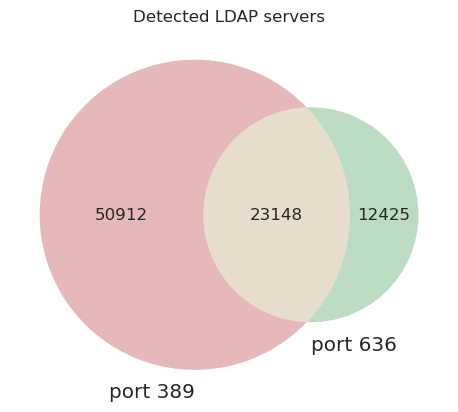

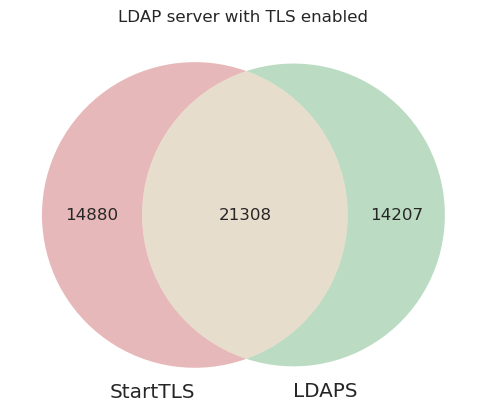

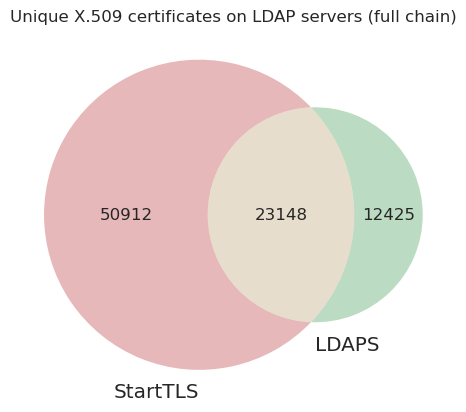

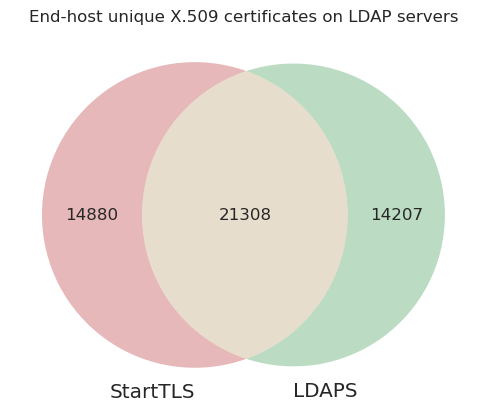

In [141]:
plot_venn()

Global Catalog

In [142]:
ts3 = SNAPSHOT_PORT_SCANDATE_MAP[3269][0]
ts4 = SNAPSHOT_PORT_SCANDATE_MAP[3268][0]
ldaps = (3269, ts3)
stls = (3268, ts4)
statistics_on_ldap_servers(all_df, goscanner_df, goscanner_certs_df, ldaps, stls)

LDAP servers detection
StartTLS only: 16409
LDAPS only: 1746
Intersection: 4100
LDAP responded from StartTLS request (only): 16409
LDAP on 636 (subtracting stls): 1746
Intersection: 0
TLS enabled LDAP servers
Distinct 389 LDAP servers 4510
Distinct 636 LDAP servers 5832
Distinct 389+636 LDAP servers 6274
Split set of StartTLS and LDAPS
StartTLS only: 442
LDAPS only: 1764
Intersection: 4068
Distinct X.509 certificates
StartTLS only: 16409
LDAPS only: 1746
Intersection: 4100
End-host uniq certs
StartTLS only: 442
LDAPS only: 1764
Intersection: 4068


Diagram

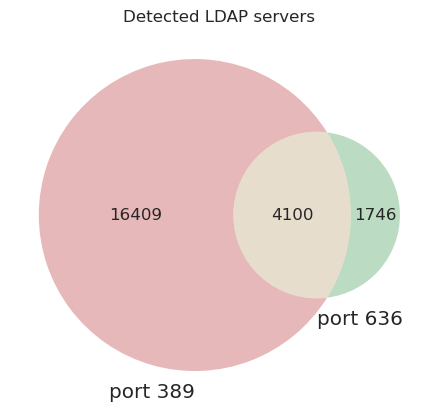

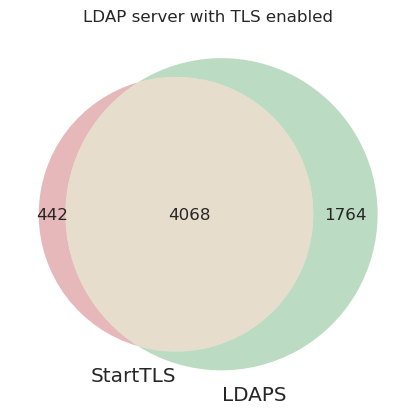

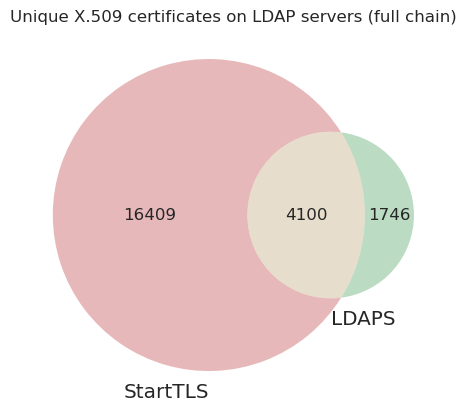

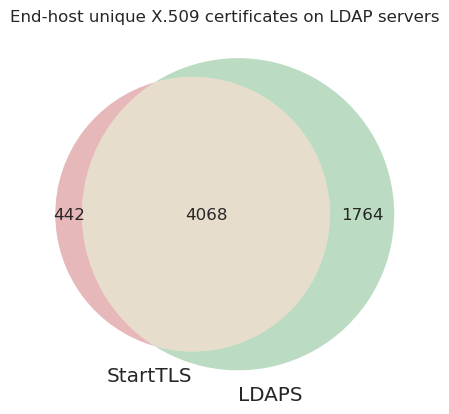

In [143]:
plot_venn()

#### Comparison

Average of hosts scanned

In [924]:
def show_average_hosts_scanned(port, port_scandate_map):
    array = np.array([])
    for ts in port_scandate_map[port]:
        print(ts)
        _hosts_df = load_hosts_data(port, ts)
        array = np.append(array, _hosts_df.count())

    avg = statistics.mean(array)
    print("Port:", port, "Average:", avg)
    return avg

avg_hosts_scanned_389 = show_average_hosts_scanned(389, PORT_SCANDATE_MAP)
avg_hosts_scanned_636 = show_average_hosts_scanned(636, PORT_SCANDATE_MAP)

2023-11-08 00:00:00
2023-11-15 00:00:00
2023-11-22 00:00:00
2023-11-29 00:00:00
Port: 389 Average: 3263076.5
2023-11-07 00:00:00
2023-11-14 00:00:00
2023-11-21 00:00:00
2023-11-28 00:00:00
Port: 636 Average: 3361767.75


In [925]:
avg_hosts_scanned_3268 = show_average_hosts_scanned(3268, SNAPSHOT_PORT_SCANDATE_MAP)
avg_hosts_scanned_3269 = show_average_hosts_scanned(3269, SNAPSHOT_PORT_SCANDATE_MAP)

_ = show_average_hosts_scanned(389, SNAPSHOT_PORT_SCANDATE_MAP)
_ = show_average_hosts_scanned(636, SNAPSHOT_PORT_SCANDATE_MAP)

2024-07-12 00:00:00
Port: 3268 Average: 3762657.0
2024-07-11 00:00:00
Port: 3269 Average: 4993488.0
2024-07-10 00:00:00
Port: 389 Average: 3629507.0
2024-07-09 00:00:00
Port: 636 Average: 3714763.0


3714763.0

Average of LDAP servers

In [972]:
def show_average_ldap_servers(port, port_scandate_map):
    array = np.array([])
    for ts in port_scandate_map[port]:
        print(ts)
        _hosts_df = load_hosts_data(port, ts)

        _hosts_df = _hosts_df.withColumnRenamed("id", "host_id")
        _hosts_df = _hosts_df.withColumnRenamed("ip", "ipv4")
        _hosts_df = _hosts_df.select("host_id", "ipv4", "port")

        _ldap_id_df = get_detected_ldap_servers_id(port, ts)

        joined_df = _hosts_df.join(_ldap_id_df, _ldap_id_df.ldap_id == _hosts_df.host_id, "inner").filter(psf.col("ldap_id").isNotNull()).drop("ldap_id")

        array = np.append(array, joined_df.count())
    avg = statistics.mean(array)
    print("Port:", port, "Average:", avg)
    return avg


avg_ldap_servers_389 = show_average_ldap_servers(389, PORT_SCANDATE_MAP)
avg_ldap_servers_636 = show_average_ldap_servers(636, PORT_SCANDATE_MAP)

2023-11-08 00:00:00


2023-11-15 00:00:00
2023-11-22 00:00:00
2023-11-29 00:00:00
Port: 389 Average: 78230.75
2023-11-07 00:00:00
2023-11-14 00:00:00
2023-11-21 00:00:00
2023-11-28 00:00:00
Port: 636 Average: 37007.75


In [973]:
avg_ldap_servers_3268 = show_average_ldap_servers(3268, SNAPSHOT_PORT_SCANDATE_MAP)
avg_ldap_servers_3269 = show_average_ldap_servers(3269, SNAPSHOT_PORT_SCANDATE_MAP)

2024-07-12 00:00:00
Port: 3268 Average: 20509.0
2024-07-11 00:00:00
Port: 3269 Average: 5846.0


Distinct LDAP servers on both 636 and 389 ports per snapshot (week)

In [971]:
def show_avg_ldap_servers(port_scan_date_map):
    dfs = []
    for port, timestamps in port_scan_date_map.items():
        for ts in timestamps:
            _hosts_df = load_hosts_data(port, ts)

            _hosts_df = _hosts_df.withColumnRenamed("id", "host_id")
            _hosts_df = _hosts_df.withColumnRenamed("ip", "ipv4")
            _hosts_df = _hosts_df.select("host_id", "ipv4", "port")

            _ldap_id_df = get_detected_ldap_servers_id(port, ts)

            joined_df = _hosts_df.join(_ldap_id_df, _ldap_id_df.ldap_id == _hosts_df.host_id, "inner").filter(psf.col("ldap_id").isNotNull()).drop("ldap_id")
            joined_df = joined_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))
            dfs.append(joined_df)

    all_df = dfs[0].unionByName(dfs[1])
    for i in range(2, len(dfs)):
        all_df = all_df.unionByName(dfs[i])

    array = np.array([])
    for snapshot in goscanner_snapshots:
        print(snapshot)
        ts1, ts2 = snapshot
        cnt = all_df.filter(
            (psf.col("date") == ts1)
            | (psf.col("date") == ts2)
        ).select("ipv4").distinct().count()
        array = np.append(array, cnt)

    avg = statistics.mean(array)
    print("Average:", avg)
    return avg

avg_ldap_servers = show_avg_ldap_servers(PORT_SCANDATE_MAP)

(datetime.datetime(2023, 11, 7, 0, 0), datetime.datetime(2023, 11, 8, 0, 0))


(datetime.datetime(2023, 11, 14, 0, 0), datetime.datetime(2023, 11, 15, 0, 0))
(datetime.datetime(2023, 11, 21, 0, 0), datetime.datetime(2023, 11, 22, 0, 0))
(datetime.datetime(2023, 11, 28, 0, 0), datetime.datetime(2023, 11, 29, 0, 0))
Average: 91022.0


Hosts that are LDAP servers but did not respond to StartTLS but we could retrieve information from

In [1028]:
def _show_starttls_discrepancy(p, t):
    print("Some root dse information",
    load_ldapstarttls_data(p, t).filter(
        (psf.col("ldap_server") == 1)
        & (psf.col("responded_to_starttls") == 0)
    ).join(
        load_ldap_root_dse(p, t),
        "id",
        "inner"
    ).filter(
        ~((psf.col("attribute_names") == psf.lit([[]]))
        | (psf.col("attribute_names") == psf.lit([]))
        | (psf.col("attribute_names").isNull()))
    ).count()
    )

    print("Some tls information",
    load_ldapstarttls_data(p, t).filter(
        (psf.col("ldap_server") == 1)
        & (psf.col("responded_to_starttls") == 0)
    ).join(
        load_hosts_data(p, t),
        "id",
        "inner"
    ).filter(
        psf.col("protocol") != 0
    ).count()
    )

p = 389
t = datetime(2024, 7, 10)
_show_starttls_discrepancy(p, t)

p = 3268
t = datetime(2024, 7, 12)
_show_starttls_discrepancy(p, t)

Some root dse information 23794
Some tls information 20792
Some root dse information 0
Some tls information 0


In [1035]:
df1 = load_ldapstarttls_data(389, datetime(2024, 7, 10)).filter(
    (psf.col("ldap_server") == 1)
    & (psf.col("responded_to_starttls") == 0)
).join(
    load_hosts_data(389, datetime(2024, 7, 10)),
    "id",
    "inner"
).select("ip")

df2 = load_ldap_data(636, datetime(2024, 7, 9)).filter(
    psf.col("ldap_server") == 1
).join(
    load_hosts_data(636, datetime(2024, 7, 9)),
    "id",
    "inner"
).select("ip")

# Left Anti Join from df1 to df2: Rows in df1 but not in df2
left_anti = df1.join(df2, on="ip", how="left_anti")
print(left_anti.count())
# Left Anti Join from df2 to df1: Rows in df2 but not in df1
#right_anti = df2.join(df1, on="ip", how="left_anti")
# Union of both anti joins to get the outer excluding join result
#print(left_anti.union(right_anti).count())

25187


Average of LDAP servers that responded to StartTLS

In [968]:
def show_average_startls_responding_servers(port_scandate_map, port):
    array = np.array([])
    for ts in port_scandate_map[port]:
        print(ts)
        _ldap_df_id = get_detected_ldap_servers_w_stls_id(port, ts)
        cnt = _ldap_df_id.count()
        array = np.append(array, cnt)
    avg = statistics.mean(array)
    print("Port:", port, "Average:", avg)
    return avg


avg_stls_respond_servers = show_average_startls_responding_servers(PORT_SCANDATE_MAP, 389)

2023-11-08 00:00:00
2023-11-15 00:00:00
2023-11-22 00:00:00
2023-11-29 00:00:00
Port: 389 Average: 39185.25


In [969]:
_ = show_average_startls_responding_servers(SNAPSHOT_PORT_SCANDATE_MAP, 389)
_ = show_average_startls_responding_servers(SNAPSHOT_PORT_SCANDATE_MAP, 3268)

2024-07-10 00:00:00
Port: 389 Average: 37402.0
2024-07-12 00:00:00
Port: 3268 Average: 20508.0


Average of LDAP servers that responded to StartTLS or LDAPS only and the intersection

In [970]:
# Here we compare ldap servers that responded to the starttls request properly according to rfc 4511 section 4.14
# then the intersection and consequently the LDAPS only group will be different as we might match more or less IPs
def show_avg_ldap_servers_responding_per_category(port_scandate_map):
    dfs = []
    for port, timestamps in port_scandate_map.items():
        for ts in timestamps:
            _hosts_df = load_hosts_data(port, ts)

            _hosts_df = _hosts_df.withColumnRenamed("id", "host_id")
            _hosts_df = _hosts_df.withColumnRenamed("ip", "ipv4")
            _hosts_df = _hosts_df.select("host_id", "ipv4", "port")

            _ldap_id_df = get_detected_ldap_servers_w_stls_id(port, ts)

            joined_df = _hosts_df.join(_ldap_id_df, _ldap_id_df.ldap_id == _hosts_df.host_id, "inner").filter(psf.col("ldap_id").isNotNull()).drop("ldap_id")
            joined_df = joined_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))
            dfs.append(joined_df)

    all_df = dfs[0].unionByName(dfs[1])
    for i in range(2, len(dfs)):
        all_df = all_df.unionByName(dfs[i])

    stls_array = np.array([])
    ldaps_array = np.array([])
    inter_array = np.array([])
    for snapshot in goscanner_snapshots:
        print(snapshot)
        ts1, ts2 = snapshot
        stls_df = all_df.filter(
            (psf.col("port") == 389)
            & (
                (psf.col("date") == ts1)
                | (psf.col("date") == ts2)
            )
        ).select("ipv4").distinct()
        ldaps_df = all_df.filter(
            (psf.col("port") == 636)
            & (
                (psf.col("date") == ts1)
                | (psf.col("date") == ts2)
            )
        ).select("ipv4").distinct()

        cnt = stls_df.subtract(ldaps_df).count()
        stls_array = np.append(stls_array, cnt)

        cnt = ldaps_df.subtract(stls_df).count()
        ldaps_array = np.append(ldaps_array, cnt)

        cnt = stls_df.join(
            ldaps_df, "ipv4", "inner"
            ).filter(
                psf.col("ipv4").isNotNull()
            ).distinct().count()
        inter_array = np.append(inter_array, cnt)

    avg_stls = statistics.mean(stls_array)
    print("Average StartTLS only:", avg_stls)
    avg_ldaps = statistics.mean(ldaps_array)
    print("Average LDAPS only:", avg_ldaps)
    avg_inter = statistics.mean(inter_array)
    print("Average intersection:", avg_inter)

    return avg_stls, avg_ldaps, avg_inter


avg_week_stls_respond, avg_week_ldaps_respond, avg_week_inter_respond = show_avg_ldap_servers_responding_per_category(PORT_SCANDATE_MAP)

(datetime.datetime(2023, 11, 7, 0, 0), datetime.datetime(2023, 11, 8, 0, 0))
(datetime.datetime(2023, 11, 14, 0, 0), datetime.datetime(2023, 11, 15, 0, 0))
(datetime.datetime(2023, 11, 21, 0, 0), datetime.datetime(2023, 11, 22, 0, 0))
(datetime.datetime(2023, 11, 28, 0, 0), datetime.datetime(2023, 11, 29, 0, 0))
Average StartTLS only: 26631.5
Average LDAPS only: 24454.0
Average intersection: 12553.75


Censys view of LDAP servers on ports 636 and 389

In [ ]:
def censys_show_avg_ldap_servers():
    array = np.array([])
    for ts in censys_timestamps:
        print(ts)
        _censys_df = load_censys_data(ts)

        cnt = _censys_df.filter(
            psf.array_contains(psf.col("services.service_name"), "LDAP")
        ).select("host_identifier.ipv4", psf.explode_outer(psf.arrays_zip(
            _censys_df.services.service_name.alias("service_name"), 
            _censys_df.services.port.alias("port")))
        ).select("ipv4", "col.service_name", "col.port"
        ).filter(psf.col("service_name") == "LDAP"
        ).filter(
            (psf.col("port") == 389)
            | (psf.col("port") == 636)
        ).select("ipv4").distinct().count()
        array = np.append(array, cnt)
    avg = statistics.mean(array)
    print("Average:", avg)
    return avg


censys_avg_ldap_servers = censys_show_avg_ldap_servers()

2022-11-01 00:00:00
2022-11-08 00:00:00
2022-11-15 00:00:00
2022-11-22 00:00:00
2022-11-29 00:00:00
Average: 108704.0


Dividing into StartTLS, LDAPS and intersection of both

In [979]:
# WITHOUT TLS (NOT ALL LDAP SERVERS COMMUNICATE USING TLS)
def show_avg_ldap_servers_per_category():
    dfs = []
    for port, timestamps in PORT_SCANDATE_MAP.items():
        for ts in timestamps:
            _hosts_df = load_hosts_data(port, ts)

            _hosts_df = _hosts_df.withColumnRenamed("id", "host_id")
            _hosts_df = _hosts_df.withColumnRenamed("ip", "ipv4")
            _hosts_df = _hosts_df.select("host_id", "ipv4", "port")

            _ldap_id_df = get_detected_ldap_servers_w_stls_id(port, ts)

            joined_df = _hosts_df.join(_ldap_id_df, _ldap_id_df.ldap_id == _hosts_df.host_id, "inner").filter(psf.col("ldap_id").isNotNull()).drop("ldap_id")
            joined_df = joined_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))
            dfs.append(joined_df)

    all_df = dfs[0].unionByName(dfs[1])
    for i in range(2, len(dfs)):
        all_df = all_df.unionByName(dfs[i])

    stls_array = np.array([])
    ldaps_array = np.array([])
    inter_array = np.array([])
    for snapshot in goscanner_snapshots:
        print(snapshot)
        ts1, ts2 = snapshot
        stls_df = all_df.filter(
            (psf.col("port") == 389)
            & (
                (psf.col("date") == ts1)
                | (psf.col("date") == ts2)
            )
        ).select("ipv4").distinct()
        ldaps_df = all_df.filter(
            (psf.col("port") == 636)
            & (
                (psf.col("date") == ts1)
                | (psf.col("date") == ts2)
            )
        ).select("ipv4").distinct()

        cnt = stls_df.subtract(ldaps_df).count()
        stls_array = np.append(stls_array, cnt)

        cnt = ldaps_df.subtract(stls_df).count()
        ldaps_array = np.append(ldaps_array, cnt)

        cnt = stls_df.join(
            ldaps_df, "ipv4", "inner"
            ).filter(
                psf.col("ipv4").isNotNull()
            ).distinct().count()
        inter_array = np.append(inter_array, cnt)

    avg_stls = statistics.mean(stls_array)
    print("Average StartTLS only:", avg_stls)
    avg_ldaps = statistics.mean(ldaps_array)
    print("Average LDAPS only:", avg_ldaps)
    avg_inter = statistics.mean(inter_array)
    print("Average intersection:", avg_inter)

    return avg_stls, avg_ldaps, avg_inter


avg_week_stls_ldap, avg_week_ldaps_ldap, avg_week_inter_ldap = show_avg_ldap_servers_per_category()

(datetime.datetime(2023, 11, 7, 0, 0), datetime.datetime(2023, 11, 8, 0, 0))
(datetime.datetime(2023, 11, 14, 0, 0), datetime.datetime(2023, 11, 15, 0, 0))
(datetime.datetime(2023, 11, 21, 0, 0), datetime.datetime(2023, 11, 22, 0, 0))
(datetime.datetime(2023, 11, 28, 0, 0), datetime.datetime(2023, 11, 29, 0, 0))
Average StartTLS only: 26631.5
Average LDAPS only: 24454.0
Average intersection: 12553.75


Average of TLS connections on LDAP servers

In [974]:
def get_ldap_servers_w_tls(port, ts):
    print(ts)
    _hosts_df = load_hosts_data(port, ts)

    _ldap_id_df = get_detected_ldap_servers_w_stls_id(port, ts)

    joined_df = _hosts_df.join(_ldap_id_df, _ldap_id_df.ldap_id == _hosts_df.id, "inner").filter(psf.col("ldap_id").isNotNull()).drop("ldap_id")
    filtered_df = joined_df.filter(
        (psf.col("cipher").isNotNull())
        & (psf.col("cipher") != "")
        & (psf.col("cipher") != "0")
    ).select("ip").distinct()

    return filtered_df

In [975]:
def show_average_tls_conn(port):
    array = np.array([])
    for ts in PORT_SCANDATE_MAP[port]:
        cnt = get_ldap_servers_w_tls(port, ts).count()
        array = np.append(array, cnt)

    avg = statistics.mean(array)
    print("Port:", port, "Average:", avg)
    return avg

avg_tls_ldap_389 = show_average_tls_conn(389)
avg_tls_ldap_636 = show_average_tls_conn(636)

2023-11-08 00:00:00
2023-11-15 00:00:00
2023-11-22 00:00:00
2023-11-29 00:00:00
Port: 389 Average: 16493.0
2023-11-07 00:00:00
2023-11-14 00:00:00
2023-11-21 00:00:00
2023-11-28 00:00:00
Port: 636 Average: 36935.0


Average of StartTLS only, LDAPS only and the intersection of LDAP servers with TLS

In [976]:
# cipher/version, chain or end host certificate share the same
# number and it's exported from ldap-dependency-data-preparation.ipynb
def show_avg_ldap_servers_w_tls_per_category():
    stls_array = np.array([])
    ldaps_array = np.array([])
    inter_array = np.array([])
    for snapshot in goscanner_snapshots:
        print(snapshot)
        ts1, ts2 = snapshot
        ldaps_df = get_ldap_servers_w_tls(636, ts1)
        stls_df = get_ldap_servers_w_tls(389, ts2)

        cnt = stls_df.subtract(ldaps_df).count()
        stls_array = np.append(stls_array, cnt)

        cnt = ldaps_df.subtract(stls_df).count()
        ldaps_array = np.append(ldaps_array, cnt)

        cnt = stls_df.join(
            ldaps_df, "ip", "inner"
            ).filter(
                psf.col("ip").isNotNull()
            ).distinct().count()
        inter_array = np.append(inter_array, cnt)

    avg_stls = statistics.mean(stls_array)
    print("Average StartTLS only:", avg_stls)
    avg_ldaps = statistics.mean(ldaps_array)
    print("Average LDAPS only:", avg_ldaps)
    avg_inter = statistics.mean(inter_array)
    print("Average intersection:", avg_inter)
    return avg_stls, avg_ldaps, avg_inter


avg_week_stls_ldap_w_tls, avg_week_ldaps_ldap_w_tls, avg_week_inter_ldap_w_tls = show_avg_ldap_servers_w_tls_per_category()

(datetime.datetime(2023, 11, 7, 0, 0), datetime.datetime(2023, 11, 8, 0, 0))
2023-11-07 00:00:00
2023-11-08 00:00:00
(datetime.datetime(2023, 11, 14, 0, 0), datetime.datetime(2023, 11, 15, 0, 0))
2023-11-14 00:00:00
2023-11-15 00:00:00
(datetime.datetime(2023, 11, 21, 0, 0), datetime.datetime(2023, 11, 22, 0, 0))
2023-11-21 00:00:00
2023-11-22 00:00:00
(datetime.datetime(2023, 11, 28, 0, 0), datetime.datetime(2023, 11, 29, 0, 0))
2023-11-28 00:00:00
2023-11-29 00:00:00
Average StartTLS only: 4044.5
Average LDAPS only: 24486.5
Average intersection: 12448.5


Average of X.509 chains on LDAP servers - useless

In [934]:
def show_average_chains(port):
    array = np.array([])
    for ts in PORT_SCANDATE_MAP[port]:
        print(ts)
        _hosts_df = load_hosts_data(port, ts)

        _ldap_id_df = get_detected_ldap_servers_id(port, ts)

        joined_df = _hosts_df.join(_ldap_id_df, _ldap_id_df.ldap_id == _hosts_df.id, "inner").filter(psf.col("ldap_id").isNotNull()).drop("ldap_id")
        joined_df = joined_df.withColumn("peer_certs_len", peer_certs_len_udf(psf.col("peer_certificates")))
        cnt = joined_df.filter(
            (psf.col("peer_certs_len").isNotNull())
            & (psf.col("peer_certs_len") != 0)
        ).select("ip").distinct().count()
        array = np.append(array, cnt)

    avg = statistics.mean(array)
    print("Port:", port, "Average:", avg)
    return avg


avg_chain_ldap_389 = show_average_chains(389)
avg_chain_ldap_636 = show_average_chains(636)

2023-11-08 00:00:00
2023-11-15 00:00:00
2023-11-22 00:00:00
2023-11-29 00:00:00
Port: 389 Average: 38048.5
2023-11-07 00:00:00
2023-11-14 00:00:00
2023-11-21 00:00:00
2023-11-28 00:00:00
Port: 636 Average: 36935.0


Average of end-host X.509 certificates on LDAP servers

In [977]:
def get_ldap_servers_end_host_cert(port, ts):
    print(ts)
    _hosts_df = load_hosts_data(port, ts)

    _ldap_id_df = get_detected_ldap_servers_w_stls_id(port, ts)

    joined_df = _hosts_df.join(_ldap_id_df, _ldap_id_df.ldap_id == _hosts_df.id, "inner").filter(psf.col("ldap_id").isNotNull()).drop("ldap_id")
    filtered_df = joined_df.filter(
        (psf.col("cert_id").isNotNull())
        & (psf.col("cert_id") != 0)
    ).dropDuplicates(["ip"])

    return filtered_df

In [936]:
def show_average_hosts_certs(port):
    array = np.array([])
    for ts in PORT_SCANDATE_MAP[port]:
        cnt = get_ldap_servers_end_host_cert(port, ts).count()
        array = np.append(array, cnt)
    avg = statistics.mean(array)
    print("Port:", port, "Average:", avg)
    return avg

    
avg_end_host_x509_ldap_389 = show_average_hosts_certs(389)
avg_end_host_x509_ldap_636 = show_average_hosts_certs(636)

2023-11-08 00:00:00
2023-11-15 00:00:00
2023-11-22 00:00:00
2023-11-29 00:00:00
Port: 389 Average: 38048.5
2023-11-07 00:00:00
2023-11-14 00:00:00
2023-11-21 00:00:00
2023-11-28 00:00:00
Port: 636 Average: 36935.0


Average of end-host uniq X.509 certificates on LDAP servers

In [978]:
def show_avg_end_host_uniq_certs_per_week():
    stls_array = np.array([])
    ldaps_array = np.array([])
    inter_array = np.array([])
    for snapshot in goscanner_snapshots:
        print(snapshot)
        ts1, ts2 = snapshot
        ldaps_df = get_ldap_servers_end_host_cert(636, ts1)
        stls_df = get_ldap_servers_end_host_cert(389, ts2)

        cnt = stls_df.select("ip").subtract(ldaps_df.select("ip")).count()
        stls_array = np.append(stls_array, cnt)

        cnt = ldaps_df.select("ip").subtract(stls_df.select("ip")).count()
        ldaps_array = np.append(ldaps_array, cnt)

        ldaps_df = ldaps_df.withColumnRenamed("cert_id", "cert_id_ldaps")
        cnt = stls_df.join(
            ldaps_df, "ip", "inner"
            ).filter(
                psf.col("ip").isNotNull()
            ).select("ip").distinct().count()
        inter_array = np.append(inter_array, cnt)

    avg_stls_certs = statistics.mean(stls_array)
    print("Average StartTLS only:", avg_stls_certs)
    avg_ldaps_certs = statistics.mean(ldaps_array)
    print("Average LDAPS only:", avg_ldaps_certs)
    avg_inter_certs = statistics.mean(inter_array)
    print("Average intersection:", avg_inter_certs)
    return avg_stls_certs, avg_ldaps_certs, avg_inter_certs


avg_week_stls_uniq_end_host_certs, avg_week_ldaps_uniq_end_host_certs, avg_week_inter_uniq_end_host_certs = show_avg_end_host_uniq_certs_per_week()

(datetime.datetime(2023, 11, 7, 0, 0), datetime.datetime(2023, 11, 8, 0, 0))
2023-11-07 00:00:00
2023-11-08 00:00:00
(datetime.datetime(2023, 11, 14, 0, 0), datetime.datetime(2023, 11, 15, 0, 0))
2023-11-14 00:00:00
2023-11-15 00:00:00
(datetime.datetime(2023, 11, 21, 0, 0), datetime.datetime(2023, 11, 22, 0, 0))
2023-11-21 00:00:00
2023-11-22 00:00:00
(datetime.datetime(2023, 11, 28, 0, 0), datetime.datetime(2023, 11, 29, 0, 0))
2023-11-28 00:00:00
2023-11-29 00:00:00
Average StartTLS only: 4044.5
Average LDAPS only: 24486.5
Average intersection: 12448.5


Number of all X.509 certificates (full chain) on LDAP servers per snapshot (week)

In [938]:
def show_avg_certs_per_port(port):
    array = np.array([])
    for ts in PORT_SCANDATE_MAP[port]:
        print(ts)
        cnt = goscanner_certs_df.filter(
            psf.col("date") == ts
        ).select(psf.explode_outer(
            goscanner_certs_df.certificates.alias("certificate")
        )).distinct().count()
        array = np.append(array, cnt)

    avg = statistics.mean(array)
    print("Port:", port, "average:", avg)
    return avg


avg_certs_389 = show_avg_certs_per_port(389)
avg_certs_636 = show_avg_certs_per_port(636)

2023-11-08 00:00:00
2023-11-15 00:00:00
2023-11-22 00:00:00
2023-11-29 00:00:00
Port: 389 average: 34141.75
2023-11-07 00:00:00
2023-11-14 00:00:00
2023-11-21 00:00:00
2023-11-28 00:00:00
Port: 636 average: 30647.25


In [811]:
def show_avg_certs_per_week():
    stls_array = np.array([])
    ldaps_array = np.array([])
    inter_array = np.array([])
    for snapshot in goscanner_snapshots:
        print(snapshot)
        ts1, ts2 = snapshot
        stls_df = goscanner_certs_df.filter(
            psf.col("port") == 389
        ).filter(
            (psf.col("date") == ts1)
            | (psf.col("date") == ts2)
        ).select(psf.explode_outer(
            goscanner_certs_df.certificates
        ).alias("certificate")).select("certificate").distinct()
        
        ldaps_df = goscanner_certs_df.filter(
            psf.col("port") == 636
        ).filter(
            (psf.col("date") == ts1)
            | (psf.col("date") == ts2)
        ).select(psf.explode_outer(
            goscanner_certs_df.certificates
        ).alias("certificate")).select("certificate").distinct()

        cnt = stls_df.subtract(ldaps_df).count()
        stls_array = np.append(stls_array, cnt)

        cnt = ldaps_df.subtract(stls_df).count()
        ldaps_array = np.append(ldaps_array, cnt)

        cnt = stls_df.join(
            ldaps_df, "certificate", "inner"
            ).filter(
                psf.col("certificate").isNotNull()
            ).select("certificate").distinct().count()
        inter_array = np.append(inter_array, cnt)

    avg_stls_certs = statistics.mean(stls_array)
    print("Average StartTLS only:", avg_stls_certs)
    avg_ldaps_certs = statistics.mean(ldaps_array)
    print("Average LDAPS only:", avg_ldaps_certs)
    avg_inter_certs = statistics.mean(inter_array)
    print("Average intersection:", avg_inter_certs)
    return avg_stls_certs, avg_ldaps_certs, avg_inter_certs


avg_week_stls_certs, avg_week_ldaps_certs, avg_week_inter_certs = show_avg_certs_per_week()

(datetime.datetime(2023, 11, 7, 0, 0), datetime.datetime(2023, 11, 8, 0, 0))
(datetime.datetime(2023, 11, 14, 0, 0), datetime.datetime(2023, 11, 15, 0, 0))
(datetime.datetime(2023, 11, 21, 0, 0), datetime.datetime(2023, 11, 22, 0, 0))
(datetime.datetime(2023, 11, 28, 0, 0), datetime.datetime(2023, 11, 29, 0, 0))
Average StartTLS only: 0.0
Average LDAPS only: 0.0
Average intersection: 0.0


Asserting numbers

In [ ]:
assert avg_ldap_servers == avg_week_stls_ldap + avg_week_ldaps_ldap + avg_week_inter_ldap
assert avg_ldap_servers_389 == avg_week_stls_ldap + avg_week_inter_ldap
assert avg_ldap_servers_636 == avg_week_ldaps_ldap + avg_week_inter_ldap

assert avg_tls_ldap_389 == avg_week_stls_ldap_w_tls + avg_week_inter_ldap_w_tls
assert avg_tls_ldap_636 == avg_week_ldaps_ldap_w_tls + avg_week_inter_ldap_w_tls

assert avg_certs_389 == avg_week_stls_certs + avg_week_inter_certs
assert avg_certs_636 == avg_week_ldaps_certs + avg_week_inter_certs

All numbers deviates <6.5% from average, months apart

In [1102]:
print("LDAP servers", round(100 - 100 * cnt_ldap_servers / avg_ldap_servers, 2), "%")
print("LDAP StartTLS (only)", round(100 - 100 * cnt_stls_ldap / avg_week_stls_ldap, 2), "%")
print("LDAPS subtracting StartTLS", round(100 - 100 * cnt_ldaps_ldap / avg_week_ldaps_ldap, 2), "%")
print("LDAP on intersection", round(100 - 100 * cnt_inter_ldap / avg_week_inter_ldap, 2), "%")

if False:  # already calculated
    print("LDAP servers that had responded properly to StartTLS requests")
    print("LDAP responded StartTLS request (only)", round(100 - 100 * cnt_stls_ldap_respond / avg_week_stls_respond,2), "%")
    print("LDAPS subtracting StartTLS respond servers", round(100 - 100 * cnt_ldaps_ldap_stls / avg_week_ldaps_respond, 2), "%")
    print("Intersection", round(100 - 100 * cnt_inter_ldap_stls / avg_week_inter_respond, 2), "%")

print("LDAP servers with TLS enabled")
print("Distinct 389 LDAP servers", round(100 - 100 * cnt_ldap_w_tls_389 / avg_tls_ldap_389, 2), "%")
print("Distinct 636 LDAP servers", round(100 - 100 * cnt_ldap_w_tls_636 / avg_tls_ldap_636, 2), "%")
avg_week_ldap_w_tls = avg_week_stls_ldap_w_tls + avg_week_ldaps_ldap_w_tls + avg_week_inter_ldap_w_tls
print("Distinct 389+636 LDAP servers", round(100 - 100 * cnt_ldap_w_tls_389_636 / avg_week_ldap_w_tls, 2), "%")
print("StartTLS only", round(100 - 100 * cnt_stls_ldap_w_tls / avg_week_stls_ldap_w_tls, 2), "%")
print("LDAPS only", round(100 - 100 * cnt_ldaps_ldap_w_tls / avg_week_ldaps_ldap_w_tls, 2), "%")
print("Intersection", round(100 - 100 * cnt_inter_ldap_w_tls / avg_week_inter_ldap_w_tls, 2), "%")

if False:
    print("LDAP servers X.509 certificates")
    
    print("StartTLS only", round(100 - 100 * cnt_stls_certs / avg_week_stls_certs, 2), "%")
    print("LDAPS only", round(100 - 100 * cnt_ldaps_certs / avg_week_ldaps_certs, 2), "%")
    print("intersection", round(100 - 100 * cnt_inter_certs / avg_week_inter_certs, 2), "%")

print("LDAP servers end-host uniq certs")
print("StartTLS only", round(100 - 100 * cnt_stls_uniq_end_host_certs / avg_week_stls_uniq_end_host_certs, 2), "%")
print("LDAPS only", round(100 - 100 * cnt_ldaps_uniq_end_host_certs / avg_week_ldaps_uniq_end_host_certs, 2), "%")
print("intersection", round(100 - 100 * cnt_inter_uniq_end_host_certs / avg_week_inter_uniq_end_host_certs, 2), "%")

LDAP servers -0.21 %
LDAP StartTLS (only) 3.4 %
LDAPS subtracting StartTLS 2.28 %
LDAP on intersection 6.98 %
LDAP servers with TLS enabled
Distinct 389 LDAP servers 6.65 %
Distinct 636 LDAP servers 3.84 %
Distinct 389+636 LDAP servers 4.06 %
StartTLS only 6.0 %
LDAPS only 2.31 %
Intersection 6.86 %
LDAP servers end-host uniq certs
StartTLS only 6.0 %
LDAPS only 2.31 %
intersection 6.86 %


#### Root DSE and Schema overview

In [ ]:
for port, ts in METADATA_PORT_SCANDATE_MAP.items():
    print(port, ts)
    print("schema")
    schema_df = load_ldap_schema(port, ts)

    print("percentage of IPs without attributes", 100 *
    schema_df.filter(
        (psf.col("attribute_names") == psf.lit([]))
        | (psf.col("attribute_names") == psf.lit([[]]))
        ).count() / schema_df.count()
    )

    print("root dse")
    root_dse_df = load_ldap_root_dse(port, ts)
    print("percentage of IPs without attributes", 100 *
    root_dse_df.filter(
        (psf.col("attribute_names") == psf.lit([]))
        | (psf.col("attribute_names") == psf.lit([[]]))
        ).count() / root_dse_df.count()
    )

636 2024-04-23 00:00:00
schema
percentage of IPs without attributes 69.17579481699171
root dse
percentage of IPs without attributes 3.780390061448036
389 2024-04-24 00:00:00
schema
percentage of IPs without attributes 59.90987794493329
root dse
percentage of IPs without attributes 7.440391711609424


In [ ]:
#metadata_timestamp = tuple(METADATA_PORT_SCANDATE_MAP.values())
for port, ts in METADATA_PORT_SCANDATE_MAP.items():
    print(port, ts)
    _hosts_df = load_hosts_data(port, ts).select(psf.col("ip").alias("host_ip"))
    _schema_df = load_ldap_schema(port, ts)
    _schema_df = _schema_df.filter(
        (psf.col("attribute_names") != psf.lit([]))
        & (psf.col("attribute_names") != psf.lit([[]]))
    ).select(psf.col("ip").alias("schema_ip"))
    _hosts_schema_df = _hosts_df.join(_schema_df, _hosts_df.host_ip == _schema_df.schema_ip, "inner").filter(psf.col("schema_ip").isNotNull()).select("host_ip")

    _root_dse_df = load_ldap_root_dse(port, ts).select(psf.col("ip"))
    _root_dse_df = _root_dse_df.filter(
        (psf.col("attribute_names") != psf.lit([]))
        & (psf.col("attribute_names") != psf.lit([[]]))
    ).select(psf.col("ip").alias("root_dse_ip"))
    _hosts_root_dse_df = _hosts_df.join(_root_dse_df, _hosts_df.host_ip == _root_dse_df.root_dse_ip, "inner").filter(psf.col("root_dse_ip").isNotNull()).select("host_ip")

    _ips = _hosts_schema_df.unionByName(_hosts_root_dse_df)
    print(_ips.distinct().count())


636 2024-04-23 00:00:00
28859
389 2024-04-24 00:00:00
52241


In [265]:
def show_non_operational_attr():
    for port, ts in METADATA_PORT_SCANDATE_MAP.items():
        print(port, ts)

        root_dse_df = load_ldap_root_dse(port, ts)

        flat_root_dse_df = flatten_ldap_metadata(root_dse_df)
        _df = flat_root_dse_df.filter(
            (psf.col("attribute_name") == "telephoneNumber")
            | (psf.col("attribute_name") == "mobile")
            | (psf.col("attribute_name") == "mail")
            | (psf.col("attribute_name") == "customerNumber")
        ).select("ip", "attribute_name", "attribute_values_list")
        print(
            _df.groupBy("ip").agg(
                psf.collect_set("attribute_name").alias("attribute_names"),
                psf.collect_set("attribute_values_list").alias("attribute_values")
            ).count()
        )
        _df.groupBy("attribute_values_list").count().sort("count", ascending=False).show(truncate=False)
        _df.filter(psf.col("attribute_name") == "customerNumber").show(truncate=False)

show_non_operational_attr()

636 2024-04-23 00:00:00
0
+---------------------+-----+
|attribute_values_list|count|
+---------------------+-----+
+---------------------+-----+

+---+--------------+---------------------+
|ip |attribute_name|attribute_values_list|
+---+--------------+---------------------+
+---+--------------+---------------------+

389 2024-04-24 00:00:00
200
+----------------------------+-----+
|attribute_values_list       |count|
+----------------------------+-----+
|[123456789]                 |392  |
|[interact@s.h, interact@s.h]|196  |
|[119537]                    |1    |
|[111113]                    |1    |
|[222223]                    |1    |
|[111112]                    |1    |
+----------------------------+-----+

+--------------+--------------+---------------------+
|ip            |attribute_name|attribute_values_list|
+--------------+--------------+---------------------+
|111.93.179.155|customerNumber|[119537]             |
|210.92.54.110 |customerNumber|[111112]             |
|203.240.69

### Selecting a snapshot

In [383]:
snapshot_timestamps = [timestamps[0] for timestamps in SNAPSHOT_PORT_SCANDATE_MAP.values()]
print(goscanner_df.count())
goscanner_df = goscanner_df.filter(
    psf.col("date").isin(snapshot_timestamps)
)
print(goscanner_df.count())

print(goscanner_certs_df.count())
goscanner_certs_df = goscanner_certs_df.filter(
    psf.col("date").isin(snapshot_timestamps)
)
print(goscanner_certs_df.count())

596942
135988
596942
135988


In [384]:
stls = (389, SNAPSHOT_PORT_SCANDATE_MAP[389][0])
ldaps = (636, SNAPSHOT_PORT_SCANDATE_MAP[636][0])
starttls_only_df, starttls_only_cnt, ldaps_only_df, ldaps_only_cnt, inter_hosts_df, inter_hosts_cnt = separate_scans(goscanner_df, stls, ldaps)
print("Normal")
print("StartTLS only", starttls_only_cnt)
print("LDAPs only", ldaps_only_cnt)
print("Intersection", inter_hosts_cnt)

stls = (3268, SNAPSHOT_PORT_SCANDATE_MAP[3268][0])
ldaps = (3269, SNAPSHOT_PORT_SCANDATE_MAP[3269][0])
gc_starttls_only_df, gc_starttls_only_cnt, gc_ldaps_only_df, gc_ldaps_only_cnt, gc_inter_hosts_df, gc_inter_hosts_cnt = separate_scans(goscanner_df, stls, ldaps)
print("Global Catalog")
print("StartTLS only", gc_starttls_only_cnt)
print("LDAPs only", gc_ldaps_only_cnt)
print("Intersection", gc_inter_hosts_cnt)

Normal
StartTLS only 50912
LDAPs only 12425
Intersection 23148
Global Catalog
StartTLS only 16409
LDAPs only 1746
Intersection 4100


In [385]:
print("TLS enabled")
goscanner_tls_df = goscanner_df.filter(
    (psf.col("protocol").isNotNull())
    & (psf.col("protocol") != 0)
)

stls = (389, SNAPSHOT_PORT_SCANDATE_MAP[389][0])
ldaps = (636, SNAPSHOT_PORT_SCANDATE_MAP[636][0])
starttls_only_tls_df, starttls_only_tls_cnt, ldaps_only_tls_df, ldaps_only_tls_cnt, inter_hosts_tls_df, inter_hosts_tls_cnt = separate_scans(goscanner_tls_df, stls, ldaps)
print("Normal")
print("StartTLS only", starttls_only_tls_cnt)
print("LDAPs only", ldaps_only_tls_cnt)
print("Intersection", inter_hosts_tls_cnt)

stls = (3268, SNAPSHOT_PORT_SCANDATE_MAP[3268][0])
ldaps = (3269, SNAPSHOT_PORT_SCANDATE_MAP[3269][0])
gc_starttls_only_tls_df, gc_starttls_only_tls_cnt, gc_ldaps_only_tls_df, gc_ldaps_only_tls_cnt, gc_inter_hosts_tls_df, gc_inter_hosts_tls_cnt = separate_scans(goscanner_tls_df, stls, ldaps)
print("Global Catalog")
print("StartTLS only", gc_starttls_only_tls_cnt)
print("LDAPs only", gc_ldaps_only_tls_cnt)
print("Intersection", gc_inter_hosts_tls_cnt)

TLS enabled


Normal
StartTLS only 14880
LDAPs only 14207
Intersection 21308
Global Catalog
StartTLS only 442
LDAPs only 1764
Intersection 4068


### Types of LDAP servers

In [133]:
ldap_fp_df = load_ldap_server_name(LDAP_SERVER_NAME_FMT.format(timestamp="20240710", port=389))
ldap_fp_df = ldap_fp_df.withColumn("date", psf.lit(datetime(2024, 7, 10)))
tmp_df = load_ldap_server_name(LDAP_SERVER_NAME_FMT.format(timestamp="20240709", port=636))
tmp_df = tmp_df.withColumn("date", psf.lit(datetime(2024, 7, 9)))
ldap_fp_df = ldap_fp_df.unionByName(tmp_df)

tmp_df = load_ldap_server_name(LDAP_SERVER_NAME_FMT.format(timestamp="20240711", port=3269))
tmp_df = tmp_df.withColumn("date", psf.lit(datetime(2024, 7, 11)))
ldap_fp_df = ldap_fp_df.unionByName(tmp_df)

tmp_df = load_ldap_server_name(LDAP_SERVER_NAME_FMT.format(timestamp="20240712", port=3268))
tmp_df = tmp_df.withColumn("date", psf.lit(datetime(2024, 7, 12)))
ldap_fp_df = ldap_fp_df.unionByName(tmp_df)
ldap_fp_df = ldap_fp_df.withColumnRenamed("ip", "ipv4")

try:
    ldap_fp_df.unpersist()
except:
    pass
ldap_fp_df.persist()

DataFrame[id: int, ipv4: string, port: int, server_name: string, version: string, certainty: double, date: timestamp]

In [134]:
stls = (389, datetime(2024, 7, 10))
ldaps = (636, datetime(2024, 7, 9))
fp_starttls_only_df, cnt_stls_only, fp_ldaps_only_df, cnt_ldaps_only, fp_inter_hosts_df, cnt_inter = separate_scans(ldap_fp_df, stls, ldaps)
stls = (3268, datetime(2024, 7, 12))
ldaps = (3269, datetime(2024, 7, 11))
gc_fp_starttls_only_df, gc_cnt_stls_only, gc_fp_ldaps_only_df, gc_cnt_ldaps_only, gc_fp_inter_hosts_df, gc_cnt_inter = separate_scans(ldap_fp_df, stls, ldaps)

In [135]:
def get_uniq_ldap_names(df):
    # this will eliminate empty server names from duplicated IPs
    ldap_names_df = df.groupBy("ipv4").agg(
        psf.collect_set(
            psf.when(psf.col("server_name") != "", psf.col("server_name"))
        ).alias("server_names"),
        psf.collect_set(psf.col("version")).alias("versions")
    ).withColumn(
        "server_names", psf.when(psf.size(psf.col("server_names")) == 0, psf.array(psf.lit(""))
                                ).otherwise(psf.col("server_names"))
    ).select("ipv4", psf.explode_outer(
        psf.arrays_zip("server_names", "versions"))
    ).select("ipv4", psf.col("col.server_names").alias("server_name"), psf.col("col.versions").alias("version")).dropDuplicates(subset=["ipv4"])

    return ldap_names_df


def process_ldap_fp(df):
    ldap_names_df = get_uniq_ldap_names(df)

    total = ldap_names_df.count()
    print("Total (uniq IPs with server name found):", total)

    aggr_df = ldap_names_df.groupBy("server_name").count().withColumn(
        'percent', 
        psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
    ).sort("count", ascending=False)

    aggr_df.show(100, truncate=False)

    if False:
        ldap_names_df = ldap_names_df.withColumn(
            "server_name_simplified",
            psf.when(psf.col("server_name").contains("Microsoft Active Directory"), "Microsoft Active Directory")
            .when(psf.col("server_name").contains("Microsoft Lightweight Directory Server"), "Microsoft Active Directory")
            .when(psf.col("server_name").contains("Windows"), "Windows Server")
            .otherwise(psf.col("server_name"))
        )

        ldap_names_df.groupBy("server_name_simplified").count().withColumn(
                'percent', psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy())
                ).sort("count", ascending=False).show(truncate=False)
    return aggr_df, total


fp_aggr_df, fp_total = process_ldap_fp(ldap_fp_df)
fp_aggr_stls_only_df, fp_stls_total = process_ldap_fp(fp_starttls_only_df)
fp_aggr_ldaps_only_df, fp_ldaps_total = process_ldap_fp(fp_ldaps_only_df)
fp_aggr_inter_df, fp_inter_total = process_ldap_fp(fp_inter_hosts_df)

Total (uniq IPs with server name found): 71646
+----------------------------------------------------------------+-----+-------+
|server_name                                                     |count|percent|
+----------------------------------------------------------------+-----+-------+
|OpenLDAP                                                        |24884|34.7   |
|Windows Server 2016                                             |16978|23.7   |
|Microsoft Active Directory Controller on Windows Server 2016    |6861 |9.6    |
|                                                                |5059 |7.1    |
|Microsoft Active Directory Controller on Windows Server 2012 R2 |4905 |6.8    |
|Kerio Connect                                                   |4791 |6.7    |
|Fedora Project 389 Directory Server                             |1720 |2.4    |
|VMware Platform Services Controller                             |1366 |1.9    |
|Microsoft Active Directory Controller on Windows Server 2008 

In [136]:
gc_fp_aggr_stls_only_df, gc_fp_stls_total = process_ldap_fp(gc_fp_starttls_only_df)
gc_fp_aggr_ldaps_only_df, gc_fp_ldaps_total = process_ldap_fp(gc_fp_ldaps_only_df)
gc_fp_aggr_inter_df, gc_fp_inter_total = process_ldap_fp(gc_fp_inter_hosts_df)

Total (uniq IPs with server name found): 10759
+---------------------------------------------------------------+-----+-------+
|server_name                                                    |count|percent|
+---------------------------------------------------------------+-----+-------+
|Windows Server 2016                                            |6344 |59.0   |
|Microsoft Active Directory Controller on Windows Server 2016   |2084 |19.4   |
|Microsoft Active Directory Controller on Windows Server 2012 R2|1536 |14.3   |
|Microsoft Active Directory Controller on Windows Server 2008 R2|352  |3.3    |
|Microsoft Active Directory Controller on Windows Server 2012   |182  |1.7    |
|Windows Server 2008 R2                                         |94   |0.9    |
|Microsoft Active Directory Controller on Windows Server 2008   |66   |0.6    |
|Microsoft Active Directory Controller on Windows Server 2003   |59   |0.5    |
|                                                               |24   |0.

What are the problematic versions?

In [139]:
version_issue_pdf = pd.read_csv("ldap-servers-support.csv")

display(version_issue_pdf)
display(version_issue_pdf.groupby("veredict").size().reset_index(name="count"))

,os_name,icon,veredict,comment,about,life_cycle
0,Windows Server 2016,\faThumbsUp,Receives security updates,Cloud-ready server. It could be used to host a...,https://www.microsoft.com/en-us/evalcenter/eva...,https://learn.microsoft.com/en-us/lifecycle/pr...
1,Windows Server 2008 R2,\faRemove,End of life,End of life since 2020-01-14,NaN,https://learn.microsoft.com/nl-nl/lifecycle/pr...
2,Windows Server 2012 R2,\faRemove,End of life,Cloud and datacenter platform. End of life sin...,https://www.microsoft.com/en-us/evalcenter/eva...,https://learn.microsoft.com/en-us/lifecycle/pr...
3,Windows Server 2003,\faRemove,End of life,End of life since 2015-07-14,NaN,https://learn.microsoft.com/en-us/lifecycle/pr...
4,Windows Server 2012,\faRemove,End of life,Cloud and datacenter platform. End of life sin...,https://www.microsoft.com/en-us/evalcenter/eva...,https://learn.microsoft.com/en-us/lifecycle/pr...
5,Windows Server 2000,\faRemove,End of life,End of life since 2010-07-13,NaN,https://eyeforce.my.site.com/eyefinitysupport/...
6,VMware Platform Services Controller,\faHourglassHalf,No information available,No information about its life cycle. Represent...,https://support.broadcom.com/group/ecx/product...,NaN
7,Scalix LDAP Server,\faRemove,End of life,The scalix website is not even running. There ...,https://dl.acm.org/doi/book/10.5555/1816981,NaN
8,Kerio Connect,\faQuestion,No information available and no version found,no version found,NaN,NaN
9,Sun Directory Server,\faRemove,End of life,end of support without known the date accordin...,NaN,https://support.oracle.com/knowledge/Middlewar...


,veredict,count
0,Community support but no version found,1
1,Community support with security issues found,1
2,End of life,10
3,No information available,5
4,No information available and no version found,1
5,Receives security updates,1


In [140]:
sec_issues_389_pdf = pd.read_csv("389-server-security-issues.csv")


def get_sec_issue(version):
    number_version = version.split(" ")[0]
    issues = []
    for av in sec_issues_389_pdf["last_affected_version"].to_list():
        if number_version <= av:
            issues.append(sec_issues_389_pdf[sec_issues_389_pdf["last_affected_version"] <= av]["security_issue"].values[0])
    return list(set(issues))


get_sec_issue_udf = psf.udf(get_sec_issue, pst.ArrayType(pst.StringType()))

server_name = "Fedora Project 389 Directory Server"
print(server_name)
print(
ldap_fp_df.filter(
    psf.col("server_name") == server_name
).withColumn(
    "issue",
    get_sec_issue_udf(psf.col("version"))
).groupBy("issue").count().sort("count", ascending=False
).show(truncate=False) #.toPandas().to_latex(index=False)
)

Fedora Project 389 Directory Server
+-----+-----+
|issue|count|
+-----+-----+
|[DoS]|2593 |
|[]   |179  |
+-----+-----+

None


In [594]:
def get_icon_from_server_name(server_name):
    for os_name in version_issue_pdf["os_name"].to_list():
        if os_name in server_name:
            return version_issue_pdf[version_issue_pdf["os_name"] == os_name]["icon"].iloc[0]
    return "-"

fp_all_pdf = fp_aggr_df.toPandas().rename(columns={"percent": "all_uniq_ips"}).drop(columns=["count"], axis=1)
types_ldap_servers_pdf = merge_pdf(fp_all_pdf,
                                   fp_aggr_stls_only_df.toPandas().drop(columns=["count"], axis=1),
                                   "server_name", "percent", "starttls_only")
types_ldap_servers_pdf = merge_pdf(types_ldap_servers_pdf,
                                   fp_aggr_ldaps_only_df.toPandas().drop(columns=["count"], axis=1),
                                   "server_name", "percent", "ldaps_only")
types_ldap_servers_pdf = merge_pdf(types_ldap_servers_pdf,
                                   fp_aggr_inter_df.toPandas().drop(columns=["count"], axis=1),
                                   "server_name", "percent", "intersection")
types_ldap_servers_pdf = merge_pdf(types_ldap_servers_pdf,
                                   gc_fp_aggr_stls_only_df.toPandas().drop(columns=["count"], axis=1),
                                   "server_name", "percent", "gc_starttls_only")
types_ldap_servers_pdf = merge_pdf(types_ldap_servers_pdf,
                                   gc_fp_aggr_ldaps_only_df.toPandas().drop(columns=["count"], axis=1),
                                   "server_name", "percent", "gc_ldaps_only")
types_ldap_servers_pdf = merge_pdf(types_ldap_servers_pdf,
                                   gc_fp_aggr_inter_df.toPandas().drop(columns=["count"], axis=1),
                                   "server_name", "percent", "gc_intersection")

all_server_names = list(set(types_ldap_servers_pdf["server_name"].to_list()))

types_ldap_servers_pdf.loc[-1] = ["Total", fp_total, fp_stls_total, fp_ldaps_total, fp_inter_total,
                                   gc_fp_stls_total, gc_fp_ldaps_total, gc_fp_inter_total]  # adding a row
types_ldap_servers_pdf.index = types_ldap_servers_pdf.index + 1  # shifting index
types_ldap_servers_pdf.sort_index(inplace=True)

types_ldap_servers_pdf["icon"] = types_ldap_servers_pdf["server_name"].apply(lambda x: get_icon_from_server_name(x))
display(types_ldap_servers_pdf)
print(types_ldap_servers_pdf.to_latex(index=False, float_format="%.1f"))

,server_name,all_uniq_ips,starttls_only,ldaps_only,intersection,gc_starttls_only,gc_ldaps_only,gc_intersection,icon
0,Total,71646.0,36677.0,10275.0,18590.0,10759.0,1755.0,4083.0,-
1,OpenLDAP,34.7,43.3,22.6,35.9,NaN,0.2,NaN,\faMehO
2,Windows Server 2016,23.7,24.2,24.1,12.4,59.0,39.8,40.2,\faThumbsUp
3,Microsoft Active Directory Controller on Windo...,9.6,8.6,10.3,7.5,19.4,26.2,24.7,\faThumbsUp
4,,7.1,10.6,6.2,2.9,0.2,0.1,0.1,-
5,Microsoft Active Directory Controller on Windo...,6.8,6.1,7.9,4.7,14.3,17.2,17.6,\faRemove
6,Kerio Connect,6.7,0.6,11.9,18.0,0.0,0.4,0.0,\faQuestion
7,Fedora Project 389 Directory Server,2.4,0.6,4.5,5.6,NaN,NaN,0.0,\faBomb
8,VMware Platform Services Controller,1.9,0.2,4.8,4.3,NaN,NaN,NaN,\faHourglassHalf
9,Microsoft Active Directory Controller on Windo...,1.9,2.1,1.7,1.1,3.3,3.5,3.4,\faRemove


\begin{tabular}{lrrrrrrrl}
\toprule
server_name & all_uniq_ips & starttls_only & ldaps_only & intersection & gc_starttls_only & gc_ldaps_only & gc_intersection & icon \\
\midrule
Total & 71646.0 & 36677.0 & 10275.0 & 18590.0 & 10759.0 & 1755.0 & 4083.0 & - \\
OpenLDAP & 34.7 & 43.3 & 22.6 & 35.9 & NaN & 0.2 & NaN & \faMehO \\
Windows Server 2016 & 23.7 & 24.2 & 24.1 & 12.4 & 59.0 & 39.8 & 40.2 & \faThumbsUp \\
Microsoft Active Directory Controller on Windows Server 2016 & 9.6 & 8.6 & 10.3 & 7.5 & 19.4 & 26.2 & 24.7 & \faThumbsUp \\
 & 7.1 & 10.6 & 6.2 & 2.9 & 0.2 & 0.1 & 0.1 & - \\
Microsoft Active Directory Controller on Windows Server 2012 R2 & 6.8 & 6.1 & 7.9 & 4.7 & 14.3 & 17.2 & 17.6 & \faRemove \\
Kerio Connect & 6.7 & 0.6 & 11.9 & 18.0 & 0.0 & 0.4 & 0.0 & \faQuestion \\
Fedora Project 389 Directory Server & 2.4 & 0.6 & 4.5 & 5.6 & NaN & NaN & 0.0 & \faBomb \\
VMware Platform Services Controller & 1.9 & 0.2 & 4.8 & 4.3 & NaN & NaN & NaN & \faHourglassHalf \\
Microsoft Active Dire

The same table but shorter

In [618]:
tail_types_ldap_servers_pdf = types_ldap_servers_pdf.copy()[15:]
tail_types_ldap_servers_pdf.loc[-1] = ["Other",
                                       tail_types_ldap_servers_pdf["all_uniq_ips"].sum(),
                                       tail_types_ldap_servers_pdf["starttls_only"].sum(),
                                       tail_types_ldap_servers_pdf["ldaps_only"].sum(),
                                       tail_types_ldap_servers_pdf["intersection"].sum(),
                                       tail_types_ldap_servers_pdf["gc_starttls_only"].sum(),
                                       tail_types_ldap_servers_pdf["gc_ldaps_only"].sum(),
                                       tail_types_ldap_servers_pdf["gc_intersection"].sum(),
                                       "-"]  # adding a row
tail_types_ldap_servers_pdf.index = tail_types_ldap_servers_pdf.index + 1  # shifting index
tail_types_ldap_servers_pdf.sort_index(inplace=True)

shorter_types_ldap_servers_pdf = types_ldap_servers_pdf.copy()[:15]
shorter_types_ldap_servers_pdf.loc[-1] = tail_types_ldap_servers_pdf.loc[0]
display(shorter_types_ldap_servers_pdf)
print(shorter_types_ldap_servers_pdf.to_latex(index=False, float_format="%.1f"))

,server_name,all_uniq_ips,starttls_only,ldaps_only,intersection,gc_starttls_only,gc_ldaps_only,gc_intersection,icon
0,Total,71646.0,36677.0,10275.0,18590.0,10759.0,1755.0,4083.0,-
1,OpenLDAP,34.7,43.3,22.6,35.9,NaN,0.2,NaN,\faMehO
2,Windows Server 2016,23.7,24.2,24.1,12.4,59.0,39.8,40.2,\faThumbsUp
3,Microsoft Active Directory Controller on Windo...,9.6,8.6,10.3,7.5,19.4,26.2,24.7,\faThumbsUp
4,,7.1,10.6,6.2,2.9,0.2,0.1,0.1,-
5,Microsoft Active Directory Controller on Windo...,6.8,6.1,7.9,4.7,14.3,17.2,17.6,\faRemove
6,Kerio Connect,6.7,0.6,11.9,18.0,0.0,0.4,0.0,\faQuestion
7,Fedora Project 389 Directory Server,2.4,0.6,4.5,5.6,NaN,NaN,0.0,\faBomb
8,VMware Platform Services Controller,1.9,0.2,4.8,4.3,NaN,NaN,NaN,\faHourglassHalf
9,Microsoft Active Directory Controller on Windo...,1.9,2.1,1.7,1.1,3.3,3.5,3.4,\faRemove


\begin{tabular}{lrrrrrrrl}
\toprule
server_name & all_uniq_ips & starttls_only & ldaps_only & intersection & gc_starttls_only & gc_ldaps_only & gc_intersection & icon \\
\midrule
Total & 71646.0 & 36677.0 & 10275.0 & 18590.0 & 10759.0 & 1755.0 & 4083.0 & - \\
OpenLDAP & 34.7 & 43.3 & 22.6 & 35.9 & NaN & 0.2 & NaN & \faMehO \\
Windows Server 2016 & 23.7 & 24.2 & 24.1 & 12.4 & 59.0 & 39.8 & 40.2 & \faThumbsUp \\
Microsoft Active Directory Controller on Windows Server 2016 & 9.6 & 8.6 & 10.3 & 7.5 & 19.4 & 26.2 & 24.7 & \faThumbsUp \\
 & 7.1 & 10.6 & 6.2 & 2.9 & 0.2 & 0.1 & 0.1 & - \\
Microsoft Active Directory Controller on Windows Server 2012 R2 & 6.8 & 6.1 & 7.9 & 4.7 & 14.3 & 17.2 & 17.6 & \faRemove \\
Kerio Connect & 6.7 & 0.6 & 11.9 & 18.0 & 0.0 & 0.4 & 0.0 & \faQuestion \\
Fedora Project 389 Directory Server & 2.4 & 0.6 & 4.5 & 5.6 & NaN & NaN & 0.0 & \faBomb \\
VMware Platform Services Controller & 1.9 & 0.2 & 4.8 & 4.3 & NaN & NaN & NaN & \faHourglassHalf \\
Microsoft Active Dire

Microsoft Server 2016 or 2019 percentual

In [664]:
types_ldap_servers_pdf[
    (types_ldap_servers_pdf["server_name"].str.contains("Windows Server 2016"))
]["all_uniq_ips"].sum()

33.4

Windows servers

In [1139]:
types_ldap_servers_pdf[
    types_ldap_servers_pdf["server_name"].str.contains("Windows")
]["all_uniq_ips"].sum()

46.800000000000004

In [1140]:
types_ldap_servers_pdf[
    types_ldap_servers_pdf["server_name"].str.contains("Active Directory")
]["all_uniq_ips"].sum()

20.999999999999996

Global Catalog and Windows

In [671]:
types_ldap_servers_pdf[
    (types_ldap_servers_pdf["server_name"].str.contains("Windows"))
][["gc_starttls_only", "gc_ldaps_only", "gc_intersection"]].sum()

gc_starttls_only    99.9
gc_ldaps_only       99.3
gc_intersection     99.9
dtype: float64

In [672]:
types_ldap_servers_pdf[
    (types_ldap_servers_pdf["server_name"].str.contains("OpenLDAP"))
]["all_uniq_ips"].sum()

34.7

In [ ]:
dfs = []
for port, timestamps in SNAPSHOT_PORT_SCANDATE_MAP.items():
    for ts in timestamps:
        ldap_attr_df = load_ldap_root_dse(ts=ts, port=port)
        ldap_attr_df = flatten_ldap_metadata(ldap_attr_df)
        dfs.append(
            ldap_attr_df.groupBy("id", "ip", "port").agg(
                psf.collect_list("attribute_name").alias("attribute_names"),
                psf.collect_list("attribute_values_list").alias("attribute_values_list")
            )
        )


ldap_attr_df = union_by_name(dfs)
ldap_attr_df = ldap_attr_df.drop_duplicates(subset=["ip"])

In [ ]:
gc_attr_df = ldap_attr_df.select("id", "ip", "port",
         psf.explode_outer(psf.arrays_zip(
             ldap_attr_df.attribute_names.alias("attribute_name"),
             ldap_attr_df.attribute_values_list.alias("attribute_values"))
             )
).filter(
    (psf.col("col.attribute_name") == "isGlobalCatalogReady")
    & (psf.array_contains(psf.col("col.attribute_values"), "TRUE"))
).groupBy("id", "ip", "port").agg(psf.collect_set(psf.col("col.attribute_name")).alias("attribute_names"),
                                  psf.collect_set(psf.col("col.attribute_values")).alias("atribute_values_list")
)
#.groupBy("attribute_values").count().show(truncate=False)

oses_to_verify = ["Windows Server 2016", "Windows Server 2012 R2", "Windows Server 2008 R2"]
for os_name in oses_to_verify:
    print(os_name)
    ldap_fp_df.filter(
        psf.col("server_name") == os_name
    ).join(
        ldap_attr_df,
        (ldap_attr_df.id == ldap_fp_df.id)
        & (ldap_attr_df.ip == ldap_fp_df.ipv4)
        & (ldap_attr_df.port == ldap_fp_df.port)
    ).groupBy("attribute_names").count().show(truncate=False)
    #select("ipv4", "server_name", "attribute_names", "attribute_values_list").show(truncate=False)

    gc_windows_cnt = ldap_fp_df.filter(
        psf.col("server_name") == os_name
    ).join(
        gc_attr_df,
        (gc_attr_df.id == ldap_fp_df.id)
        & (gc_attr_df.ip == ldap_fp_df.ipv4)
        & (gc_attr_df.port == ldap_fp_df.port)
    ).groupBy("attribute_names").count().collect()[0][1]

    all_windows_cnt = fp_aggr_df.filter(
        psf.col("server_name") == os_name
    ).collect()[0][1]
    print(gc_windows_cnt, "out of", all_windows_cnt, ",", round(gc_windows_cnt / all_windows_cnt * 100, 2), "% are Global catalog instances.")

Windows Server 2016
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|attribute_names                                                                                                                                                                                                                                                                                                                                      |count|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
unusual_instances = ["OpenLDAP", "Kerio Connect"]
ports = [3269]

ldap_fp_df.filter(
    (psf.col("server_name").isin(unusual_instances))
    & (psf.col("port").isin(ports))
).join(
    ldap_attr_df,
    (ldap_attr_df.id == ldap_fp_df.id)
    & (ldap_attr_df.ip == ldap_fp_df.ipv4)
    & (ldap_attr_df.port == ldap_fp_df.port)
).groupBy("attribute_names").count().show(truncate=False)
#select("ipv4", "server_name", "attribute_names", "attribute_values_list").show(truncate=False)

gc_windows_cnt = ldap_fp_df.filter(
    (psf.col("server_name").isin(unusual_instances))
    & (psf.col("port").isin(ports))
).join(
    gc_attr_df,
    (gc_attr_df.id == ldap_fp_df.id)
    & (gc_attr_df.ip == ldap_fp_df.ipv4)
    & (gc_attr_df.port == ldap_fp_df.port)
).groupBy("attribute_names").count().show()

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|attribute_names                                                                                                                                                                                        |count|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|[objectClass, namingContexts, defaultNamingContext, supportedControl]                                                                                                                                  |8    |
|[objectClass, structuralObjectClass, configContext, namingContexts, supportedControl, supportedExtension, supportedFeatures, supportedLDAPVersion, supportedSASLMechani

Deployments other than MS and OpenLDAP

In [ ]:
major_deployments = ["Microsoft", "Windows", "OpenLDAP", ""]
other_deployments_cnt = fp_aggr_df.filter(
    ~(
    (psf.col("server_name").contains("Microsoft"))
    | (psf.col("server_name").contains("Windows"))
    | (psf.col("server_name").contains("OpenLDAP"))
    | (psf.col("server_name") == "")
    )
).select("count").groupBy().sum().collect()[0][0]
print(other_deployments_cnt, "out of", fp_total, ",", round(other_deployments_cnt / fp_total * 100, 2), "%")

8217 out of 71646 , 11.47 %


In [143]:
# about MS life cycle support:
# https://learn.microsoft.com/en-us/lifecycle/policies/fixed
# Windows Server 2012: https://learn.microsoft.com/en-us/lifecycle/announcements/windows-server-2012-r2-end-of-support
# "Customers needing to stay on-premises can upgrade to Windows Server 2022, or purchase Extended Security Updates (ESUs) for Windows Server 2012 – providing up to three years of security updates only. ESUs will continue for three years, renewable on an annual basis, until October 13, 2026."

print(all_server_names[1:])  # excluding unknown server_name == ''
no_windows = [server_name for server_name in all_server_names[1:] if "Windows" not in server_name]
print(no_windows)

['Microsoft Active Directory Controller on Windows Server 2003', 'Microsoft Active Directory Controller on Windows Server 2000', 'Windows Server 2012 R2', 'OpenLDAP', 'Microsoft Lightweight Directory Server on Windows Server 2012', 'IBM Domino LDAP Server', 'Microsoft Active Directory Controller on Windows Server 2012', 'Sun Java System Directory Server', 'IBM Security Directory Server', 'estos MetaDirectory Server', 'UnboundID Directory Server', 'Microsoft Active Directory Controller on Windows Server 2008', 'VMware Platform Services Controller', 'Windows Server 2008 R2', 'Microsoft Lightweight Directory Server on Windows Server 2008', 'Microsoft Active Directory Controller on Windows Server 2016', 'Kerio Connect', 'Sun Directory Server', 'Microsoft Lightweight Directory Server on Windows Server 2016', 'Scalix LDAP Server', 'Microsoft Lightweight Directory Server on Windows Server 2008 R2', 'Sun Directory Proxy Server', 'Microsoft Active Directory Controller on Windows Server 2012 R2'

Version distribution

In [144]:
def show_servers_version(df):
    for server_name in no_windows:
        print(server_name)
        ldap_name_df = get_uniq_ldap_names(df)
        ldap_name_df.groupBy(
            "server_name", "version"
        ).count().withColumn(
            "percent", psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy())
        ).filter(
            psf.col("server_name") == server_name
        ).orderBy(["version"], ascending=False).select("version", "percent").show(truncate=False)

show_servers_version(ldap_fp_df)

OpenLDAP
+-------+-----------------+
|version|percent          |
+-------+-----------------+
|NULL   |34.73187616894174|
+-------+-----------------+

IBM Domino LDAP Server
+---------------+---------------------+
|version        |percent              |
+---------------+---------------------+
|9.0HF1135      |0.001395751332942523 |
|9.0.1LINUX64   |0.001395751332942523 |
|9.0.1FP9HF63   |0.001395751332942523 |
|9.0.1FP9 HF60  |0.001395751332942523 |
|9.0.1FP9 HF139 |0.001395751332942523 |
|9.0.1FP9       |0.00977025933059766  |
|9.0.1FP8 HF238 |0.001395751332942523 |
|9.0.1FP8       |0.006978756664712615 |
|9.0.1FP7HF92   |0.001395751332942523 |
|9.0.1FP7       |0.006978756664712615 |
|9.0.1FP6       |0.005583005331770092 |
|9.0.1FP5       |0.002791502665885046 |
|9.0.1FP4       |0.002791502665885046 |
|9.0.1FP3 HF75  |0.001395751332942523 |
|9.0.1FP3 HF515 |0.002791502665885046 |
|9.0.1FP10HF515 |0.001395751332942523 |
|9.0.1FP10HF382 |0.001395751332942523 |
|9.0.1FP10 HF747|0.00418725

In [180]:
vmware_name = "VMware Platform Services Controller"
vmware_df = ldap_fp_df.filter(
    psf.col("server_name") == vmware_name
).groupBy("version").count().withColumn(
    "percent", psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy())
).orderBy(["version"], ascending=False).select("version", "percent")

print(f"Distribution of {vmware_name} versions")
percent8 = vmware_df.filter(
    psf.col("version").contains("8.")
).groupBy().sum().collect()[0].asDict()["sum(percent)"]
print("8.x versions", percent8)

percent7 = vmware_df.filter(
    (psf.col("version").contains("7."))
    & (~psf.col("version").contains("6."))
).groupBy().sum().collect()[0].asDict()["sum(percent)"]
print("7.x versions", percent7)

percent6 = vmware_df.filter(
    psf.col("version").contains("6.")
).groupBy().sum().collect()[0].asDict()["sum(percent)"]
print("6.x versions", percent6)

print("summing all:", percent8 + percent7 + percent6)

Distribution of VMware Platform Services Controller versions
8.x versions 32.44362632305568
7.x versions 38.05798435342844
6.x versions 29.49838932351588
summing all: 100.0


vendorVersion are not really an OpenLDAP version...

In [ ]:
vendor_version_df = []
for port, timestamps in SNAPSHOT_PORT_SCANDATE_MAP.items():
    for ts in timestamps:
        ldap_attr_df = load_ldap_root_dse(ts=ts, port=port)
        ldap_attr_df = flatten_ldap_metadata(ldap_attr_df)
        vendor_version_df.append(
            ldap_attr_df.filter(
            (psf.col("attribute_name") == "vendorVersion")
            | (psf.col("attribute_name") == "vendorversion")
            | (psf.col("attribute_name") == "fullVendorVersion")
            ).groupBy("id", "ip", "port").agg(
                psf.collect_list("attribute_name"),
                psf.collect_list("attribute_values_list")
            )
        )


vendor_version_df = union_by_name(vendor_version_df)

ldap_fp_df.filter(
    psf.col("server_name") == "OpenLDAP"
).join(
    vendor_version_df,
    (ldap_fp_df.ipv4 == vendor_version_df.ip) & (vendor_version_df.port == vendor_version_df.port) & (vendor_version_df.id == ldap_fp_df.id),
    "inner"
).select(
    psf.explode_outer("collect_list(attribute_values_list)").alias("attribute_values_list")
).select(
    psf.explode_outer("attribute_values_list").alias("attribute_values_list")
).groupBy("attribute_values_list").count().sort("count", ascending=False).show(40, truncate=False)

+---------------------+-----+
|attribute_values_list|count|
+---------------------+-----+
|523.30.2             |223  |
|526.10.2             |181  |
|510.30               |152  |
|526                  |69   |
|528.140.14           |43   |
|499.32.4             |40   |
|528.140.1            |22   |
|526.20.15            |20   |
|491.5                |17   |
|547.100.1.700.1      |15   |
|547.100.1            |9    |
|530.120.11           |8    |
|491.1                |8    |
|208.10               |8    |
|526.10.1             |6    |
|530.120.11.700.1     |4    |
|528.60.1             |4    |
|1.1.4                |3    |
|1.1.10               |3    |
|528                  |2    |
|523                  |2    |
|1.1.6                |2    |
|526.20.2             |2    |
|1.0.14               |2    |
|528.140.3            |2    |
|208.4                |2    |
|208.5                |2    |
|530.80.2             |1    |
|1.1.5                |1    |
|553                  |1    |
|526.20.1 

OpenLDAP:  
Fingerprint of OpenLDAP had to be changed (remove the "top" keyword from the regex). Otherwise, no OpenLDAP result is yield. These servers are not matched to any other server name. It's either OpenLDAP or not.  

Lightweight Directory Server on ...:  
"directory services for directory-enabled applications without incurring the overhead of domains and forests and the requirements of a single schema throughout a forest"  
https://learn.microsoft.com/nl-nl/previous-versions/windows/it-pro/windows-server-2012-r2-and-2012/hh831593(v=ws.11)  

Kerio Connect:  
Email for business  
https://manuals.gfi.com/en/kerio/connect/content/server-configuration/ldap-and-directory-services/how-do-i-get-the-ldap-server-in-kerio-connect-to-work-with-microsoft-outlook-384.html  

Fedora Project 389 Directory Server:  
"server developed by Red Hat as part of the community-supported Fedora Project."  
https://en.wikipedia.org/wiki/389_Directory_Server  

VMWare Platform:  
"Provides a multitenant, multimastered LDAP directory service that stores authentication, certificate, lookup, and license information. Do not update data in vmdird by using an LDAP browser."  
https://vdc-download.vmware.com/vmwb-repository/dcr-public/cdd3166b-c90d-408a-9df5-28dda80f2e3a/ce687a2a-56a4-4fdc-b389-70b25be78300/doc/GUID-FE4E0496-A14C-4331-A7D6-1200F7C068A5.html  

RedHat Directory Server  
https://access.redhat.com/support/policy/updates/directory  

IBM Domino LDAP Server:  


### Hosting type

Strategy:  
- use IP prefixes from cloud providers;  
- use NamingContext, serverName (rootDSE);  
- Subject Alternative Name, Subject and Issuer (X.509);  
- IP2Location (nw usage types: Data center)  -- second step;  


In [843]:
def extract_ipv4_prefixes_from_txt(provider, filepath):
    pdf = pd.read_csv(filepath, header=None)
    pdf.columns = ["prefix"]
    ipv4_prefixes = [p.rstrip() for p in pdf['prefix'].to_list()]
    pdf = pd.DataFrame(ipv4_prefixes, columns=["prefix"])
    pdf["provider"] = provider
    return pdf


def extract_ipv4_prefixes_from_aws():
    with open("cloud-ip-prefixes/ip_prefixes/aws/ip-ranges.json", mode="rt", encoding="utf-8") as f:
        data = json.loads(f.read())
        prefixes = data["prefixes"]
        pdf = pd.DataFrame(prefixes, columns=["ip_prefix", "region", "service", "network_border_group"])
        #display(pdf)
        pdf["provider"] = "AWS"
        pdf = pdf[["ip_prefix", "provider"]]
        pdf.columns = ["prefix", "provider"]
        return pdf


def extract_prefixes_from_digital_ocean():
    pdf = pd.read_csv("cloud-ip-prefixes/ip_prefixes/digitalocean/google.csv", header=None)
    pdf.columns = ["prefix", "cc", "region", "city", "postal_code"]
    pdf["provider"] = "DigitalOcean"
    return pdf[['prefix', 'provider']]


def extract_ipv4_prefixes_from_fastly():
    with open("cloud-ip-prefixes/ip_prefixes/fastly/public-ip-list.json", mode="rt", encoding="utf-8") as f:
        data = json.loads(f.read())
        pdf = pd.DataFrame(data["addresses"], columns=["prefix"])
        pdf["provider"] = "Fastly"
        return pdf


def extract_ipv4_prefixes_from_google():
    pdf = pd.read_json("cloud-ip-prefixes/ip_prefixes/google/cloud.json")
    #display(pdf)
    all_prefixes = pdf['prefixes'].to_list()
    ipv4_prefixes = []
    for prefix in all_prefixes:
        if prefix.get("ipv4Prefix"):
            ipv4_prefixes.append(prefix.get("ipv4Prefix"))
    pdf = pd.DataFrame(ipv4_prefixes, columns=["prefix"])
    pdf["provider"] = "Google"  # Should I use "Google Cloud"?
    return pdf


def extract_ip_prefixes_from_linode():
    pdf = pd.read_csv("cloud-ip-prefixes/ip_prefixes/linode/linode.csv", skiprows=[0, 1])
    pdf.columns = ["prefix", "alpha2code", "regin", "city", "postal_code"]
    pdf["provider"] = "Linode"
    #display(pdf)
    return pdf[['prefix', 'provider']]


def extract_ip_prefixes_from_azure():
    pdf = pd.read_json("cloud-ip-prefixes/ip_prefixes/microsoft/azure.json")
    values_pdf = pd.DataFrame(pdf['values'].to_list())
    azure_pdf = pd.DataFrame(values_pdf['properties'].to_list())
    azure_pdf = azure_pdf.explode("addressPrefixes").reset_index(drop=True)
    #display(azure_pdf)
    selected_pdf = azure_pdf[["addressPrefixes", "platform"]]
    selected_pdf.columns = ["prefix", "provider"]
    return selected_pdf


def extract_ip_prefixes_from_oracle():
    with open("cloud-ip-prefixes/ip_prefixes/oracle/public_ip_ranges.json", mode="rt", encoding="utf-8") as f:
        oracle_data = json.loads(f.read())
        oracle_pdf = pd.DataFrame()
        for region in oracle_data["regions"]:
            pdf = pd.DataFrame(region)
            pdf["cidr"] = pdf["cidrs"].apply(lambda x: x["cidr"])
            pdf["tags"] = pdf["cidrs"].apply(lambda x: x["tags"])
            pdf = pdf.drop(columns=["cidrs"])
            oracle_pdf = pd.concat([oracle_pdf, pdf], ignore_index=True)

        #display(oracle_pdf)
        oracle_pdf = oracle_pdf[["cidr"]]
        oracle_pdf.columns = ["prefix"]
        oracle_pdf["provider"] = "Oracle"
        return oracle_pdf

In [844]:
akamai_prefixes_pdf = extract_ipv4_prefixes_from_txt("Akamai", "cloud-ip-prefixes/ip_prefixes/akamai/akamai_ipv4_CIDRs.txt")
cloudflare_prefixes_pdf = extract_ipv4_prefixes_from_txt("Cloudflare", "cloud-ip-prefixes/ip_prefixes/cloudflare/ips-v4.txt")
aws_prefixes_pdf = extract_ipv4_prefixes_from_aws()
digital_ocean_prefixes_pdf = extract_prefixes_from_digital_ocean()
fastly_prefixes_pdf = extract_ipv4_prefixes_from_fastly()
google_prefixes_pdf = extract_ipv4_prefixes_from_google()
linode_prefixes_pdf = extract_ip_prefixes_from_linode()
azure_prefixes_pdf = extract_ip_prefixes_from_azure()
oracle_prefixes_pdf = extract_ip_prefixes_from_oracle()

all_cloud_prefixes_pdf = pd.concat([
    akamai_prefixes_pdf, cloudflare_prefixes_pdf, aws_prefixes_pdf,
    digital_ocean_prefixes_pdf, azure_prefixes_pdf, fastly_prefixes_pdf,
    google_prefixes_pdf, linode_prefixes_pdf, oracle_prefixes_pdf
])

display(all_cloud_prefixes_pdf.groupby("provider").size())
print("Total prefixes of cloud providers that were collected to be use for comparison: ", len(all_cloud_prefixes_pdf))

provider
AWS              9510
Akamai             19
Azure           79622
Cloudflare         15
DigitalOcean     1140
Fastly             19
Google            624
Linode           3804
Oracle            741
dtype: int64

Total prefixes of cloud providers that were collected to be use for comparison:  95494


In [845]:
naming_context = ["defaultnamingcontext", "namingcontexts", "rootDomainNamingContext", "configurationNamingContext", "namingContexts", "defaultNamingContext", "schemaNamingContext"]
naming_ctx_df = []
for port, timestamps in SNAPSHOT_PORT_SCANDATE_MAP.items():
    for ts in timestamps:
        ldap_attr_df = load_ldap_root_dse(ts=ts, port=port)
        ldap_attr_df = flatten_ldap_metadata(ldap_attr_df)
        naming_ctx_df.append(
            ldap_attr_df.filter(
                psf.col("attribute_name").isin(naming_context)
            ).groupBy("id", "ip", "port").agg(
                psf.collect_list("attribute_name").alias("attribute_names"),
                psf.collect_list("attribute_values_list").alias("attribute_values_list")
            )
        )


naming_ctx_df = union_by_name(naming_ctx_df)
naming_ctx_df = naming_ctx_df

prepared_df = goscanner_df.join(
    naming_ctx_df,
    (naming_ctx_df.id == goscanner_df.id)
    & (naming_ctx_df.ip == goscanner_df.ipv4)
    & (naming_ctx_df.port == goscanner_df.port),
    how="left"
).drop(naming_ctx_df.id).drop(naming_ctx_df.ip).drop(naming_ctx_df.port)

In [850]:
prepared_df.select(psf.col("ipv4").alias("ip"), "port","id", "date",
                   "leaf_data_names", "subject_rdns", "cipher", "pubkey_bit_size",
                   "attribute_names", "attribute_values_list"
                   ).toPandas().to_csv("output/goscanner_ipv4.csv", index=False)
# then run IP2Location at this set of ipv4 addresses

In [851]:
pt = pytricia.PyTricia()
for _, row in all_cloud_prefixes_pdf.iterrows():
    pt[row['prefix']] = row['provider']

ips_pdf = pd.read_csv("output/goscanner_ipv4_netstats_ip2location.csv")

In [852]:
def map_ip_to_prefix_name(pdf):
    ip = pdf['ip']
    isp = pdf["isp"]
    try:
        if pt[ip] and pt[ip] in isp:
            return isp  # just to keep the same naming
        else:
            return pt[ip]
    except KeyError:
        if "cloud" in str(isp).casefold():
            return isp
        if isinstance(pdf["attribute_values_list"], str):
            for attribute_values in eval(pdf["attribute_values_list"]):
                for attr_value in attribute_values:
                    if "cloud".casefold() in str(attr_value).casefold():
                        return isp
        if isinstance(pdf["leaf_data_names"], str):
            for leaf_data in eval(pdf["leaf_data_names"]):
                if "cloud" in str(leaf_data).casefold():
                    return isp
        if isinstance(pdf["subject_rdns"], str):
            for subject_rdn in eval(pdf["subject_rdns"]):
                if "cloud" in str(subject_rdn).casefold():
                    return isp
        if pdf["usage_type"] == "DCH":
            return isp
        return "Unknown"


ips_pdf["cloud_provider"] = ips_pdf.apply(lambda x: map_ip_to_prefix_name(x), axis=1)
uniq_ips_pdf = ips_pdf.drop_duplicates(subset=["ip"])  # the same ip from different scans will yield the same cloud anyway
display(uniq_ips_pdf.groupby("cloud_provider").size().reset_index(name="count").sort_values(by="count", ascending=False))
found = len(uniq_ips_pdf[uniq_ips_pdf["cloud_provider"] != "Unknown"])
total = len(uniq_ips_pdf)
print(f"Found {found} out of {total} unique IPs to be in the cloud: {found/total*100:.2f}%")

,cloud_provider,count
4381,Unknown,46965
108,AWS,4398
3063,OVH SAS,3445
1818,Hetzner Online GmbH,2759
396,Azure,2164
...,...,...
3031,Nuxt.Cloud Hosting Provider,1
3032,NxtGen Datacenter & Cloud Technologies Pvt. Ltd.,1
3033,Nxtra Data Limited,1
122,Access Digital Networks Pty. Ltd.,1


Found 44247 out of 91212 unique IPs to be in the cloud: 48.51%


In [853]:
tmp_pdf = uniq_ips_pdf[uniq_ips_pdf["cloud_provider"] != "Unknown"].groupby("usage_type").size().reset_index(name="count").sort_values(by="count", ascending=False)
print("DCH accounts for", round(tmp_pdf[tmp_pdf["usage_type"] == "DCH"]["count"].values[0] / tmp_pdf["count"].sum() * 100, 2), "% of the cloud providers IP prefixes")

DCH accounts for 97.95 % of the cloud providers IP prefixes


In [854]:
ips_df = spark.createDataFrame(ips_pdf)
ips_df = ips_df.withColumnRenamed("ip", "ipv4")

In [190]:
ldaps = (636, datetime(2024, 7, 9))
stls = (389, datetime(2024, 7, 10))
h_starttls_only_df, h_starttls_only_cnt, h_ldaps_only_df, h_ldaps_only_cnt, h_inter_hosts_df, h_inter_hosts_cnt = separate_scans(ips_df, stls, ldaps)

ldaps = (3269, datetime(2024, 7, 11))
stls = (3268, datetime(2024, 7, 12))
gc_h_starttls_only_df, gc_h_starttls_only_cnt, gc_h_ldaps_only_df, gc_h_ldaps_only_cnt, gc_h_inter_hosts_df, gc_h_inter_hosts_cnt = separate_scans(ips_df, stls, ldaps)

In [191]:
def process_ldap_cloud(df, total):
    print("Total:", total)

    aggr_df = df.groupBy("cloud_provider").count().withColumn(
        'percent', 
        psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
    ).sort("count", ascending=False)

    aggr_df.show(10, truncate=False)
    return aggr_df, total

try:
    h_aggr_df.unpersist()
except:
    pass
h_aggr_df, h_total = process_ldap_cloud(ips_df.drop_duplicates(subset=["ipv4"]), len(ips_pdf.drop_duplicates(subset=["ip"])))
h_aggr_df.persist()

h_aggr_stls_only_df, h_stls_total = process_ldap_cloud(h_starttls_only_df, h_starttls_only_cnt)
h_aggr_ldaps_only_df, h_ldaps_total = process_ldap_cloud(h_ldaps_only_df, h_ldaps_only_cnt)
h_aggr_inter_df, h_inter_total = process_ldap_cloud(h_inter_hosts_df, h_inter_hosts_cnt)

Total: 91212
+------------------------+-----+-------+
|cloud_provider          |count|percent|
+------------------------+-----+-------+
|Unknown                 |46966|51.5   |
|AWS                     |4398 |4.8    |
|OVH SAS                 |3445 |3.8    |
|Hetzner Online GmbH     |2759 |3.0    |
|Azure                   |2164 |2.4    |
|Contabo GmbH            |1818 |2.0    |
|DigitalOcean LLC        |840  |0.9    |
|Aliyun Computing Co. Ltd|807  |0.9    |
|Google LLC              |578  |0.6    |
|Strato AG               |520  |0.6    |
+------------------------+-----+-------+
only showing top 10 rows

Total: 50912
+------------------------+-----+-------+
|cloud_provider          |count|percent|
+------------------------+-----+-------+
|Unknown                 |25159|49.4   |
|OVH SAS                 |2271 |4.5    |
|AWS                     |1802 |3.5    |
|Hetzner Online GmbH     |1491 |2.9    |
|Contabo GmbH            |1449 |2.8    |
|Azure                   |805  |1.6    |
|Aliy

In [192]:
gc_h_aggr_stls_only_df, gc_h_stls_total = process_ldap_cloud(gc_h_starttls_only_df, gc_h_starttls_only_cnt)
gc_h_aggr_ldaps_only_df, gc_h_ldaps_total = process_ldap_cloud(gc_h_ldaps_only_df, gc_h_ldaps_only_cnt)
gc_h_aggr_inter_df, gc_h_inter_total = process_ldap_cloud(gc_h_inter_hosts_df, gc_h_inter_hosts_cnt)

Total: 16409
+--------------------------------+-----+-------+
|cloud_provider                  |count|percent|
+--------------------------------+-----+-------+
|Unknown                         |6649 |40.5   |
|OVH SAS                         |1194 |7.3    |
|Contabo GmbH                    |701  |4.3    |
|Hetzner Online GmbH             |481  |2.9    |
|AWS                             |303  |1.8    |
|Azure                           |282  |1.7    |
|Open Processamento de Dados Ltda|280  |1.7    |
|Xneelo (Pty) Ltd                |193  |1.2    |
|Strato AG                       |190  |1.2    |
|OVH Hosting Inc.                |150  |0.9    |
+--------------------------------+-----+-------+
only showing top 10 rows

Total: 1746
+-------------------+-----+-------+
|cloud_provider     |count|percent|
+-------------------+-----+-------+
|Unknown            |956  |54.8   |
|Azure              |89   |5.1    |
|AWS                |62   |3.6    |
|Hetzner Online GmbH|57   |3.3    |
|OVH SAS   

Issue with DCH: not accurate; some residential networks or other company types are classified as DCH:
https://www.reddit.com/r/Honeygain/comments/11wrbwp/unusable_network_usage_type_dch_on_my_home_network/
https://www.reddit.com/r/Network/comments/hk1gyk/how_to_change_ip_address_usage_type/


In [193]:
known_companies = ['AWS', 'Akamai', 'Alibaba', 'Aliyun', 'Amazon', 'Azure', 'Cloudflare', 'Contabo', 'DigitalOcean', 'Facebook', 'Fastly', 'GoDaddy', 'Google', 'Hetzner', 'Huawei', 'IBM', 'Limenet', 'Linode', 'Microsoft', 'OVH', 'Oracle', 'PFCloud', 'Rackspace', 'SingleHop', 'Squarespace', 'Tencent']

def get_company(cloud_provider):
    for company in known_companies:
        if re.search(rf'\b{company}\b', cloud_provider, re.IGNORECASE):
            # joining subsidiaries
            if company == "AWS":
                return "Amazon"
            if company == "Azure":
                return "Microsoft"
            return company
    return cloud_provider


get_company_udf = psf.udf(get_company, pst.StringType())


def get_top_cloud_providers(df):
    return df.withColumn("company", get_company_udf(psf.col("cloud_provider"))).groupBy("company").agg(
        psf.sum("count").alias("count"),
        psf.sum("percent").alias("percent")
    ).sort("count", ascending=False).limit(15).toPandas()

def get_companies_from_list(df, companies):
    return df.withColumn("company", get_company_udf(psf.col("cloud_provider"))).groupBy("company").agg(
            psf.sum("count").alias("count"),
            psf.sum("percent").alias("percent")
        ).filter(psf.col("company").isin(companies)).toPandas()

In [194]:
h_aggr_pdf = get_top_cloud_providers(h_aggr_df)
top_companies = h_aggr_pdf["company"].to_list()

In [195]:
h_aggr_stls_only_pdf = get_companies_from_list(h_aggr_stls_only_df, top_companies)
h_aggr_ldaps_only_pdf = get_companies_from_list(h_aggr_ldaps_only_df, top_companies)
h_aggr_inter_pdf = get_companies_from_list(h_aggr_inter_df, top_companies)

gc_h_aggr_stls_only_pdf = get_companies_from_list(gc_h_aggr_stls_only_df, top_companies)
gc_h_aggr_ldaps_only_pdf = get_companies_from_list(gc_h_aggr_ldaps_only_df, top_companies)
gc_h_aggr_inter_pdf = get_companies_from_list(gc_h_aggr_inter_df, top_companies)

In [196]:
h_all_pdf = h_aggr_pdf.rename(columns={"percent": "all_uniq_ips"}).drop(columns=["count"], axis=1)
hosting_ldap_pdf = merge_pdf(h_all_pdf,
                            h_aggr_stls_only_pdf.drop(columns=["count"], axis=1),
                            "company", "percent", "starttls_only")
hosting_ldap_pdf = merge_pdf(hosting_ldap_pdf,
                            h_aggr_ldaps_only_pdf.drop(columns=["count"], axis=1),
                            "company", "percent", "ldaps_only")
hosting_ldap_pdf = merge_pdf(hosting_ldap_pdf,
                            h_aggr_inter_pdf.drop(columns=["count"], axis=1),
                            "company", "percent", "intersection")
hosting_ldap_pdf = merge_pdf(hosting_ldap_pdf,
                            gc_h_aggr_stls_only_pdf.drop(columns=["count"], axis=1),
                            "company", "percent", "gc_starttls_only")
hosting_ldap_pdf = merge_pdf(hosting_ldap_pdf,
                            gc_h_aggr_ldaps_only_pdf.drop(columns=["count"], axis=1),
                            "company", "percent", "gc_ldaps_only")
hosting_ldap_pdf = merge_pdf(hosting_ldap_pdf,
                            gc_h_aggr_inter_pdf.drop(columns=["count"], axis=1),
                            "company", "percent", "gc_intersection")

hosting_ldap_pdf.loc[-1] = ["Total", h_total, h_stls_total, h_ldaps_total, h_inter_total,
                                gc_h_stls_total, gc_h_ldaps_total, gc_h_inter_total]  # adding a row
hosting_ldap_pdf.index = hosting_ldap_pdf.index + 1  # shifting index
hosting_ldap_pdf.sort_index(inplace=True)

display(hosting_ldap_pdf)
print(hosting_ldap_pdf.to_latex(index=False, float_format="%.1f"))

,company,all_uniq_ips,starttls_only,ldaps_only,intersection,gc_starttls_only,gc_ldaps_only,gc_intersection
0,Total,91212.0,50912.0,12425.0,23148.0,16409.0,1746.0,4100.0
1,Unknown,51.5,49.4,52.3,56.9,40.5,54.8,52.4
2,Amazon,4.9,3.6,9.6,5.9,1.8,3.6,2.7
3,OVH,4.5,5.4,1.7,2.8,8.7,3.6,5.5
4,Hetzner,3.4,3.2,3.7,3.5,3.2,3.6,3.5
5,Microsoft,2.4,1.6,8.6,1.1,1.7,5.2,1.5
6,Contabo,2.3,3.4,0.4,1.4,5.2,2.8,3.8
7,DigitalOcean,0.9,1.2,0.4,0.8,0.0,NaN,0.1
8,Aliyun,0.9,1.3,0.3,0.4,0.4,0.2,0.4
9,Google,0.6,0.6,0.3,0.9,0.4,0.5,0.5


\begin{tabular}{lrrrrrrr}
\toprule
company & all_uniq_ips & starttls_only & ldaps_only & intersection & gc_starttls_only & gc_ldaps_only & gc_intersection \\
\midrule
Total & 91212.0 & 50912.0 & 12425.0 & 23148.0 & 16409.0 & 1746.0 & 4100.0 \\
Unknown & 51.5 & 49.4 & 52.3 & 56.9 & 40.5 & 54.8 & 52.4 \\
Amazon & 4.9 & 3.6 & 9.6 & 5.9 & 1.8 & 3.6 & 2.7 \\
OVH & 4.5 & 5.4 & 1.7 & 2.8 & 8.7 & 3.6 & 5.5 \\
Hetzner & 3.4 & 3.2 & 3.7 & 3.5 & 3.2 & 3.6 & 3.5 \\
Microsoft & 2.4 & 1.6 & 8.6 & 1.1 & 1.7 & 5.2 & 1.5 \\
Contabo & 2.3 & 3.4 & 0.4 & 1.4 & 5.2 & 2.8 & 3.8 \\
DigitalOcean & 0.9 & 1.2 & 0.4 & 0.8 & 0.0 & NaN & 0.1 \\
Aliyun & 0.9 & 1.3 & 0.3 & 0.4 & 0.4 & 0.2 & 0.4 \\
Google & 0.6 & 0.6 & 0.3 & 0.9 & 0.4 & 0.5 & 0.5 \\
Linode & 0.6 & 0.6 & 0.4 & 0.6 & 0.0 & 0.3 & 0.1 \\
Strato AG & 0.6 & 0.8 & 0.2 & 0.4 & 1.2 & 0.4 & 1.0 \\
NhanHoa Software Company & 0.6 & 0.3 & 0.0 & 1.6 & 0.0 & 0.1 & NaN \\
Tencent & 0.5 & 0.7 & 0.1 & 0.2 & 0.1 & 0.2 & 0.1 \\
Xneelo (Pty) Ltd & 0.4 & 0.5 & 0.1 & 0.2 &

In [197]:
print("Number of different cloud providers (companies)",
      h_aggr_df.withColumn("company", get_company_udf(psf.col("cloud_provider"))
        ).groupBy("company").count(
        ).filter(psf.col("company") != "Unknown").count()
)

Number of different cloud providers (companies) 4840


In [198]:
print("VPS/VDS providers (by their names)")
h_aggr_df.filter(
    (psf.upper(psf.col("cloud_provider")).contains("VPS"))
    | (psf.upper(psf.col("cloud_provider")).contains("VDS"))
).show(10, truncate=False)

print(h_aggr_df.filter(
    (psf.upper(psf.col("cloud_provider")).contains("VPS"))
    | (psf.upper(psf.col("cloud_provider")).contains("VDS"))
).count())

h_aggr_df.filter(
    (psf.upper(psf.col("cloud_provider")).contains("VPS"))
    | (psf.upper(psf.col("cloud_provider")).contains("VDS"))
).select(psf.sum("count")).show()

VPS/VDS providers (by their names)
+-----------------------+-----+-------+
|cloud_provider         |count|percent|
+-----------------------+-----+-------+
|MVPS Ltd               |20   |0.0    |
|VPSBlocks Pty Ltd      |17   |0.0    |
|WindowsVPS.Host        |13   |0.0    |
|VPSfree.cz Z.S.        |10   |0.0    |
|VPSville-RU VPS Hosting|6    |0.0    |
|LLC VPSville           |5    |0.0    |
|AdminVPS OOO           |4    |0.0    |
|DirectVPS B.V.         |3    |0.0    |
|BlueVPS Ou             |3    |0.0    |
|VPSquan L.L.C.         |3    |0.0    |
+-----------------------+-----+-------+
only showing top 10 rows

24
+----------+
|sum(count)|
+----------+
|       107|
+----------+



In [181]:
# https://www.gleif.org/about-lei/code-lists/iso-20275-entity-legal-forms-code-list/2023-09-28-elf-code-list-v1.5.csv
legal_entity_pdf = pd.read_csv("2023-09-28-elf-code-list-v1.5.csv")
legal_entity_list = []
for l in legal_entity_pdf[legal_entity_pdf["Abbreviations Local language"].notnull()]["Abbreviations Local language"].to_list():
    if ";" in l:
        legal_entity_list.extend(l.split(";"))
    else:
        legal_entity_list.append(l)


def get_legal_entity(x):
    isp = x["isp"]
    for entity in legal_entity_list:
        if entity.casefold() in isp.casefold():
            x["legal_entity_type"] = entity
            x["found_legal_entity"] = True
            return x
    x["legal_entity_type"] = isp
    x["found_legal_entity"] = False
    return x

Cannot use "ISP" field of IP2Location because it is always a company hosting the IP. We should use the subject in x509 certs

In [ ]:
all_dch_pdf = uniq_ips_pdf.groupby("isp").size().reset_index(name="count").apply(lambda x: get_legal_entity(x), axis=1)
display(all_dch_pdf.groupby("found_legal_entity").size().reset_index(name="count"))

found_legal_entity = all_dch_pdf.groupby("found_legal_entity").size().reset_index(name="count").sort_values("count", ascending=False).iloc[0]["count"]
total = len(all_dch_pdf)
print(f"Found {found_legal_entity} out of {total} legal entities: {found_legal_entity/total*100:.1f}%")

pdf = all_dch_pdf.groupby("legal_entity_type").size().reset_index(name="count")
display(pd.merge(legal_entity_pdf, pdf, left_on="Abbreviations Local language", right_on="legal_entity_type", how="inner")[["Entity Legal Form name Local name", "legal_entity_type", "count"]].sort_values("count", ascending=False).drop_duplicates(subset=["legal_entity_type"]))

,found_legal_entity,count
0,False,126
1,True,15397


Found 15397 out of 15523 legal entities: 99.2%


,Entity Legal Form name Local name,legal_entity_type,count
82,company limited by shares,Ltd,2145
224,Šeimynos,S,1384
66,Societas Europaea,SE,963
245,Personal Liability Company,Inc,937
229,Asociacijos,A,749
...,...,...,...
109,Société privée à responsabilité limitée,SPRL,1
165,Empresa Individual de Responsabilidad Limitada,EIRL,1
123,Vennootschap onder firma,V.O.F.,1
134,professional corporation,P.C.,1


In [92]:
uniq_ips_pdf["company"] = uniq_ips_pdf["cloud_provider"].apply(lambda x: get_company(x))
all_dch_pdf = uniq_ips_pdf[uniq_ips_pdf["usage_type"] == "DCH"].groupby("company").size().reset_index(name="count").sort_values("count", ascending=False)
all_dch = len(uniq_ips_pdf[uniq_ips_pdf["usage_type"] == "DCH"])
total = len(uniq_ips_pdf)
print(all_dch, "out of", total, " are DCH - ", round(all_dch / total * 100, 2), "%")
# the top X account for 90% of the DCH
top_x = 1400
top_dch = all_dch_pdf.head(top_x).sum()["count"]
print("Top", top_x, "DCH orgs account for", round(top_dch / all_dch * 100, 2), "% of all DCH")
top_dch_pdf = all_dch_pdf.head(top_x)
display(top_dch_pdf)

#### Common Names in X.509 certs

In [587]:
# https://ccadb.my.salesforce-sites.com/mozilla/IncludedCACertificateReportCSVFormat
ca_pdf = pd.read_csv("../dataset/processing/IncludedCACertificateReport.csv")
# https://ccadb.my.salesforce-sites.com/mozilla/IntermediateCertsSeparateAuditsCSV
intermediate_pdf = pd.read_csv("../dataset/processing/IntermediateCertsSeparateAuditsCSV.csv")


def get_x509_name(dn_list, fingerprint):
    # e.g.:
    # dn_list=[C=US, O=Let's Encrypt, CN=R3]
    # dn_list=[C=BE, O=GlobalSign nv-sa, CN=GlobalSign Atlas R3 DV TLS CA 2023 Q3]
    name = None

    ca = ca_pdf[ca_pdf["SHA-256 Fingerprint"].str.contains(str(fingerprint), case=False) == True]["Owner"]
    if not ca.empty:
        name = ca.iloc[0]
    if name is None:
        inter = intermediate_pdf[intermediate_pdf["SHA-256 Fingerprint"].str.contains(str(fingerprint), case=False) == True]["Certificate Name"]
        if not inter.empty:
            name = inter.iloc[0]

    if dn_list:
        if name is None:
            for dn in dn_list:
                if "CN=" in dn:
                    name = dn.split("=")[-1]
                    break
        # group without CN
        if name is None:
            for dn in dn_list:
                if "O=" in dn:
                    name = dn.split("=")[-1]
                    break

        if name is None:
            for dn in dn_list:
                if "OU=" in dn:
                    name = dn.split("=")[-1]
                    break

    return name


get_x509_name_udf = psf.udf(get_x509_name, pst.StringType())

In [588]:
def subject_issuer_to_df(df):
    df = df.withColumn("subject", get_x509_name_udf(psf.col("subject_rdns"), psf.col("fingerprint")))
    return df.withColumn("issuer", get_x509_name_udf(psf.col("issuer_rdns"), psf.col("fingerprint")))


goscanner_tls_df = subject_issuer_to_df(goscanner_tls_df)

In [ ]:
starttls_only_df = subject_issuer_to_df(starttls_only_df)
ldaps_only_df = subject_issuer_to_df(ldaps_only_df)
inter_hosts_df = subject_issuer_to_df(inter_hosts_df)

In [589]:
def show_x509_subject_compare_valid(df, comparison):
    df = df.withColumn("chain_error", 
            psf.when(psf.col("chain_error").isNull(), SHORT10)
            .otherwise(psf.col("chain_error")))

    _df = df.filter(
        comparison(psf.col("chain_error"), SHORT8)
    ).withColumn("subject",
       psf.when(
           (psf.col("subject").isNull())
           | (psf.col("subject") == "")
           | (psf.col("subject") == "(none)"),
           "Unknown"  # then
       )
       .when(
           (psf.col("subject") == "localhost")
           | (psf.col("subject") == "127.0.0.1"),
           "localhost"  # then
       )
       # .when(  # this is better to sum by hand
       #    psf.lower(psf.col("subject")).contains("synology"),
       #    "synology.com"  # then
       # )
       .otherwise(
           psf.col("subject")
       )
    ).groupBy("subject").count().withColumn(
        'percent', psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy())
    ).sort("percent", ascending=False)
    print("sum all count", _df.groupBy().sum().collect()[0][0])
    return _df

##### Subject

no conclusion when using subject and legal entity...

In [652]:
def get_legal_entity_spark(subject_rdns, san, naming_contexts):
    not_found_str = "Not found"
    def _get_legal_entity_from_list(subjects):
        for subject in subjects:
            separated_subject = [i.casefold().rstrip("\\").rstrip(",") for i in subject.split(" ")]
            for entity in legal_entity_list:
                if entity.casefold() in separated_subject:
                    return entity
        return not_found_str

    le = not_found_str
    if subject_rdns:
        le = _get_legal_entity_from_list(subject_rdns)
    if le == not_found_str and san:
        le = _get_legal_entity_from_list(san)
    if le == not_found_str and naming_contexts:
        for nc in naming_contexts:
            if nc and le == not_found_str:
                le = _get_legal_entity_from_list(nc)
    return le


get_legal_entity_spark_udf = psf.udf(get_legal_entity_spark, pst.StringType())

# with naming context
prepared_df.filter(psf.col("cert_hash").isNotNull()  # similar to goscanner_tls_df
).dropDuplicates(["ipv4"]).withColumn(
    "legal_entity", get_legal_entity_spark_udf(
        psf.col("subject_rdns"),
        psf.col("leaf_data_names"),
        psf.col("attribute_values_list"))
).groupBy("legal_entity").count().withColumn(
    'percent', psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
).sort("percent", ascending=False).show(truncate=False)

+------------+-----+-------+
|legal_entity|count|percent|
+------------+-----+-------+
|Not found   |47002|91.8   |
|Inc.        |2254 |4.4    |
|LLC         |474  |0.9    |
|GmbH        |262  |0.5    |
|Inc         |136  |0.3    |
|Ltd         |168  |0.3    |
|Ltd.        |82   |0.2    |
|Limited     |89   |0.2    |
|Company     |39   |0.1    |
|SA          |29   |0.1    |
|District    |42   |0.1    |
|Corp        |41   |0.1    |
|AG          |65   |0.1    |
|SRL         |27   |0.1    |
|Corporation |68   |0.1    |
|S.A.S.      |35   |0.1    |
|S.A.        |26   |0.1    |
|A.C.        |1    |0.0    |
|AM          |6    |0.0    |
|S.L.        |9    |0.0    |
+------------+-----+-------+
only showing top 20 rows



In [1138]:
# FILTER BY INVALID CHAINS
aggr_subj_inv_df = show_x509_subject_compare_valid(goscanner_tls_df.dropDuplicates(["ipv4"]), operator.ne)
aggr_subj_inv_df.show(30, truncate=False)
print("Nr of uniq subjects:", aggr_subj_inv_df.count())
print("Nr single find (count == 1)", aggr_subj_inv_df.filter(psf.col("count") == 1).count())
aggr_subj_inv_df.sort("count", ascending=True).show(20, truncate=False)
#show_invalid_x509_subject(starttls_only_tls_df, operator.ne)
#show_invalid_x509_subject(ldaps_only_tls_df, operator.ne)
#show_invalid_x509_subject(inter_hosts_tls_df, operator.ne)

sum all count 34389
+-------------------------------------+-----+-------------------+
|subject                              |count|percent            |
+-------------------------------------+-----+-------------------+
|Philip Newman                        |3957 |11.50658640844456  |
|Unknown                              |1457 |4.236819913344384  |
|localhost                            |345  |1.0032277763238244 |
|synology.com                         |323  |0.9392538311669429 |
|synology                             |281  |0.8171217540492599 |
|PCDNAD01.cdnetworks.biz              |182  |0.5292390008432929 |
|authentik default certificate        |155  |0.450725522696211  |
|centos-7-x86_64-quyen                |129  |0.3751199511471692 |
|invalid2.invalid                     |127  |0.369304137951089  |
|master14.tempo.arapbx.fr             |116  |0.3373171653726482 |
|ldap                                 |87   |0.2529878740294862 |
|openvpnserver.com                    |75   |0.218092994

In [1100]:
print("Nr of different subjects with *mail* in their name:",
aggr_subj_inv_df.filter(
    psf.lower(psf.col("subject")).contains("mail")
).count())

print("Nr of hosts with *mail* in their name:",
aggr_subj_inv_df.filter(
    psf.lower(psf.col("subject")).contains("mail")
).agg(
    psf.sum("count")
).collect()[0][0])

Nr of different subjects with *mail* in their name: 3004
Nr of hosts with *mail* in their name: 3457


In [1095]:
# FILTER BY VALID CHAINS
aggr_subj_val_df = show_x509_subject_compare_valid(goscanner_tls_df.dropDuplicates(["ipv4"]), operator.eq)
aggr_subj_val_df.show(50, truncate=False)
print("Nr of uniq subjects:", aggr_subj_val_df.count())
print("Nr single find (count == 1)", aggr_subj_val_df.filter(psf.col("count") == 1).count())
aggr_subj_val_df.sort("count", ascending=True).show(50, truncate=False)
#show_valid_x509_subject(starttls_only_tls_df, operator.eq)
#show_valid_x509_subject(ldaps_only_tls_df, operator.eq)
#show_valid_x509_subject(inter_hosts_tls_df, operator.eq)

sum all count 16805
+------------------------------+-----+-------------------+
|subject                       |count|percent            |
+------------------------------+-----+-------------------+
|*.duosecurity.com             |367  |2.1838738470693246 |
|*.vpbx.iway.ch                |239  |1.4221957750669443 |
|*.ptcmscloud.com              |192  |1.1425171080035703 |
|ip.relaix.net                 |165  |0.9818506396905683 |
|*.vpbx.nexphone.ch            |132  |0.7854805117524546 |
|*.online-pbx.ch               |113  |0.6724189229396013 |
|*.vpbx.mocom.ch               |73   |0.4343945254388575 |
|*.ldap.okta.com               |63   |0.3748884260636715 |
|*.vpbx.foellmiag.ch           |47   |0.279678667063374  |
|*.vpbx.globalcall.ch          |43   |0.2558762273132996 |
|*.ptcmsdev.com                |40   |0.23802439750074383|
|*.wolfconnect.com             |37   |0.22017256768818805|
|1.ldap.flexio.io              |33   |0.19637012793811365|
|*.cloud50.co.uk               |32  

In [1099]:
print("Nr of different subjects with *mail* in their name:",
aggr_subj_val_df.filter(
    psf.lower(psf.col("subject")).contains("mail")
).count())

print("Nr of hosts with *mail* in their name:",
aggr_subj_val_df.filter(
    psf.lower(psf.col("subject")).contains("mail")
).agg(
    psf.sum("count")
).collect()[0][0])

Nr of different subjects with *mail* in their name: 4334
Nr of hosts with *mail* in their name: 4666


Docker images?

In [1116]:
goscanner_tls_df.filter(
    (psf.lower(psf.col("subject")).contains("docker"))
    | (psf.array_contains(psf.col("subject_rdns"), "docker"))
    | (psf.array_contains(psf.col("leaf_data_names"), "docker"))
).groupBy("cipher", "protocol", "chain_error").count().show(truncate=False)

+------+--------+-------------------------+-----+
|cipher|protocol|chain_error              |count|
+------+--------+-------------------------+-----+
|cca8  |771     |Valid chain              |1    |
|1301  |772     |Valid chain              |2    |
|1303  |772     |No valid leaf certificate|2    |
|9c    |771     |Expired/Not yet valid    |1    |
+------+--------+-------------------------+-----+



In [1135]:
def get_domain_suffix(url):
    if url:
        return tldextract.extract(url).suffix
    return ""

get_domain_suffix_udf = psf.udf(get_domain_suffix, pst.StringType())

print("Valid chains")

aggr_subj_val_df.withColumn(
    "domain_suffix", get_domain_suffix_udf(psf.col("subject"))
).groupBy("domain_suffix").count().sort("count", ascending=False).show()

print("Could not find the suffix for X domains:",
aggr_subj_val_df.withColumn(
    "domain_suffix", get_domain_suffix_udf(psf.col("subject"))
).filter(psf.col("domain_suffix") == "").count())


Valid chains
+-------------+-----+
|domain_suffix|count|
+-------------+-----+
|          com| 3305|
|           de| 1036|
|           ru|  693|
|          net|  683|
|          org|  372|
|           me|  344|
|           nl|  294|
|          edu|  262|
|           ch|  261|
|           it|  247|
|           fr|  228|
|           cz|  190|
|           eu|  187|
|           vn|  182|
|        co.id|  169|
|       com.br|  163|
|           pl|  143|
|           io|  122|
|       com.vn|  111|
|           in|  107|
+-------------+-----+
only showing top 20 rows

Could not find the suffix for X domains: 5


In [1136]:
print("Invalid chains")

aggr_subj_inv_df.withColumn(
    "domain_suffix", get_domain_suffix_udf(psf.col("subject"))
).groupBy("domain_suffix").count().sort("count", ascending=False).show()

print("Could not find the suffix for X domains:",
aggr_subj_inv_df.withColumn(
    "domain_suffix", get_domain_suffix_udf(psf.col("subject"))
).filter(psf.col("domain_suffix") == "").count())

Invalid chains
+-------------+-----+
|domain_suffix|count|
+-------------+-----+
|             | 8602|
|          com| 4288|
|          net| 1040|
|           de|  740|
|           ru|  651|
|          org|  524|
|           me|  213|
|       com.br|  211|
|           fr|  201|
|          edu|  198|
|           it|  182|
|           eu|  167|
|       com.tw|  153|
|        co.id|  143|
|           cz|  139|
|           nl|  131|
|           io|  120|
|        cloud|  117|
|           ch|  114|
|        co.uk|  103|
+-------------+-----+
only showing top 20 rows

Could not find the suffix for X domains: 8602


Below 2 cells are old code...

In [ ]:
# FILTER BY VALID CHAINS, using goscanner_df (not separating by group)
def all_valid_end_host_certs_subject():
    _df = goscanner_df.groupBy(
        "ipv4"
    ).agg(
        psf.collect_set("subject").alias("subjects"),
        psf.collect_set("chain_error").alias("chain_errors")
    ).filter(
        psf.array_contains(psf.col("chain_errors"), SHORT8)
    )

    print("sum all count", _df.groupBy("ipv4").count().count())
    print("amount of IPs with more than one subject", _df.withColumn("len", psf.size("subjects")).filter(psf.col("len") > 1).count())
    _df.select(psf.explode_outer("subjects").alias("subject")
                    ).groupBy("subject").count(
                    ).withColumn(
                        'percent', psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy())
                    ).sort("count", ascending=False).show(truncate=False)


all_valid_end_host_certs_subject()

sum all count 9620
amount of IPs with more than one subject 73
+------------------+-----+-------------------+
|subject           |count|percent            |
+------------------+-----+-------------------+
|*.duosecurity.com |278  |2.8680491076034254 |
|*.vpbx.iway.ch    |113  |1.165789745176932  |
|*.ptcmscloud.com  |100  |1.0316723408645414 |
|*.vpbx.nexphone.ch|88   |0.9078716599607964 |
|*.ptcmsdev.com    |82   |0.845971319508924  |
|*.ldap.okta.com   |47   |0.4848860002063345 |
|*.wolfconnect.com |39   |0.40235221293717116|
|*.maychuemail.com |35   |0.3610853193025895 |
|ldap.stanford.edu |32   |0.33013514907665326|
|*.trustedpath.info|31   |0.31981842566800783|
|*.cloud50.co.uk   |30   |0.3095017022593624 |
|*.eleane.com      |28   |0.2888682554420716 |
|*.gammaapi.net    |24   |0.24760136180748993|
|*.vpbx.mocon.ch   |24   |0.24760136180748993|
|*.cnt.net         |22   |0.2269679149901991 |
|ApacheDS          |21   |0.2166511915815537 |
|*.vpbx.deep.ch    |20   |0.2063344681729083

In [ ]:
# FILTER BY INVALID CHAINS, using goscanner_df (not separating by group)
def all_invalid_end_host_certs_subject():
    _df = goscanner_df.groupBy(
        "ipv4"
    ).agg(
        psf.collect_set("subject").alias("subjects"),
        psf.collect_set("chain_error").alias("chain_errors")
    ).filter(
        ~psf.array_contains(psf.col("chain_errors"), SHORT8)
    )

    print("sum all count", _df.groupBy("ipv4").count().count())
    print("amount of IPs with more than one subject", _df.withColumn("len", psf.size("subjects")).filter(psf.col("len") > 1).count())
    _df = _df.select(psf.explode_outer("subjects").alias("subject")
                    ).groupBy("subject").count(
                    ).withColumn(
                        'percent', psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy())
                    ).sort("count", ascending=False)
    _df.coalesce(1).write.csv("output/invalid_end_host_certs_subject")
    _df.show(truncate=False)


all_invalid_end_host_certs_subject()

sum all count 43248
amount of IPs with more than one subject 47
+-----------------------------+-----+-------------------+
|subject                      |count|percent            |
+-----------------------------+-----+-------------------+
|Philip Newman                |3779 |8.728490587827693  |
|NULL                         |1243 |2.871001270354544  |
|synology.com                 |387  |0.8938676521538284 |
|synology                     |273  |0.6305578011317704 |
|                             |221  |0.5104515532971475 |
|PCDNAD01.cdnetworks.biz      |213  |0.4919736690148978 |
|localhost                    |196  |0.45270816491511723|
|127.0.0.1                    |182  |0.42037186742118027|
|ip.relaix.net                |164  |0.3787966277861185 |
|invalid2.invalid             |146  |0.3372213881510567 |
|centos-7-x86_64-quyen        |127  |0.2933364129807137 |
|*.vpbx.iway.ch               |106  |0.24483196673980828|
|master14.tempo.arapbx.fr     |100  |0.23097355352812102|
|authent

##### Issuer

Let's Encrypt is very present in Web.  

In [ ]:
# VALID CHAINS, divided into StartTLS only, LDAPS only and intersection
def show_valid_x509_issuer(df):
    _df = df.filter(
        psf.col("chain_error") == SHORT8
    ).groupBy("issuer").count().withColumn(
        'percent', psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy())
    ).sort("percent", ascending=False)
    # collect() = Row(sum(count)=X, sum(percent)=Y)
    print("sum all count", _df.groupBy().sum().collect()[0][0])
    _df.show(truncate=False)


show_valid_x509_issuer(starttls_only_df)
show_valid_x509_issuer(ldaps_only_df)
show_valid_x509_issuer(inter_hosts_df)

sum all count 3009
+----------------------------------------------------+-----+------------------+
|issuer                                              |count|percent           |
+----------------------------------------------------+-----+------------------+
|Sectigo RSA Domain Validation Secure Server CA      |1664 |55.30076437354603 |
|RapidSSL TLS RSA CA G1                              |179  |5.948820206048521 |
|Go Daddy Secure Certificate Authority - G2          |163  |5.417082087072117 |
|AlphaSSL CA - SHA256 - G4                           |157  |5.217680292455966 |
|GoGetSSL RSA DV CA                                  |101  |3.356596876038551 |
|RapidSSL Global TLS RSA4096 SHA256 2022 CA1         |101  |3.356596876038551 |
|Sectigo RSA Organization Validation Secure Server CA|63   |2.093718843469591 |
|GlobalSign GCC R3 DV TLS CA 2020                    |46   |1.5287470920571617|
|GeoTrust TLS RSA CA G1                              |42   |1.3958125623130608|
|ZeroSSL RSA Domain S

In [ ]:
def show_invalid_x509_issuer(df):
    _df = df.filter(
        psf.col("chain_error") != SHORT8
    ).groupBy("issuer").count().withColumn(
        'percent', psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy())
    ).sort("percent", ascending=False)
    # collect() = Row(sum(count)=X, sum(percent)=Y)
    print("sum all count", _df.groupBy().sum().collect()[0][0])
    _df.show(truncate=False)


show_invalid_x509_issuer(starttls_only_df)
show_invalid_x509_issuer(ldaps_only_df)
show_invalid_x509_issuer(inter_hosts_df)

sum all count 12909
+----------------------------------------------+-----+-------------------+
|issuer                                        |count|percent            |
+----------------------------------------------+-----+-------------------+
|R3                                            |3224 |24.97482376636455  |
|Philip Newman                                 |574  |4.446510186691455  |
|www.mail.org                                  |367  |2.8429777674490664 |
|VPN                                           |167  |1.2936710821907196 |
|docker-light-baseimage                        |151  |1.169726547370052  |
|Synology Inc. CA                              |133  |1.0302889456968007 |
|IHE Europe CA                                 |133  |1.0302889456968007 |
|localhost                                     |101  |0.7823998760554651 |
|master14.tempo.arapbx.fr                      |100  |0.7746533426291734 |
|Certificate Authority                         |73   |0.5654969401192966 |
|Let'

In [ ]:
# FILTER BY valid chain
def all_valid_end_host_certs_issuer():
    _df = goscanner_df.groupBy(
        "ipv4"
    ).agg(
        psf.collect_set("issuer").alias("issuers"),
        psf.collect_set("chain_error").alias("chain_errors")
    ).filter(
        psf.array_contains(psf.col("chain_errors"), SHORT8)
    )

    print("sum all count", _df.groupBy("ipv4").count().count())
    print("amount of IPs with more than one issuer", _df.withColumn("len", psf.size("issuers")).filter(psf.col("len") > 1).count())
    _df = _df.select(psf.explode_outer("issuers").alias("issuer")
                    ).groupBy("issuer").count(
                    ).withColumn(
                        'percent', psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy())
                    ).sort("count", ascending=False)
    _df.coalesce(1).write.csv("output/valid_end_host_certs_issuer")
    _df.show(truncate=False)
    return _df


issuers_df = all_valid_end_host_certs_issuer()

sum all count 9620
amount of IPs with more than one issuer 77
+----------------------------------------------------+-----+------------------+
|issuer                                              |count|percent           |
+----------------------------------------------------+-----+------------------+
|Sectigo RSA Domain Validation Secure Server CA      |3473 |35.815200577498196|
|RapidSSL TLS RSA CA G1                              |572  |5.898731566463855 |
|Go Daddy Secure Certificate Authority - G2          |448  |4.619985562545117 |
|AlphaSSL CA - SHA256 - G4                           |427  |4.403423739300814 |
|DigiCert TLS RSA SHA256 2020 CA1                    |369  |3.8053006084355987|
|DigiCert SHA2 High Assurance Server CA              |365  |3.764050737341446 |
|InCommon RSA Server CA                              |365  |3.764050737341446 |
|RapidSSL Global TLS RSA4096 SHA256 2022 CA1         |353  |3.6403011240589875|
|GEANT OV RSA CA 4                                   |289 

In [ ]:
trim_issuers_pdf = issuers_df.withColumn(
    "aggr_issuer", psf.split(psf.col("issuer"), " ")[0]
).select("aggr_issuer", "percent").toPandas()

tmp_pdf = trim_issuers_pdf.groupby('aggr_issuer', as_index=False)['percent'].sum().sort_values("percent", ascending=False)
print(tmp_pdf.head(10).to_latex(index=False, float_format="%.1f"))
display(tmp_pdf.head(10))

\begin{tabular}{lr}
\toprule
aggr_issuer & percent \\
\midrule
Sectigo & 38.2 \\
DigiCert & 10.8 \\
RapidSSL & 10.5 \\
AlphaSSL & 5.8 \\
Go & 4.7 \\
InCommon & 4.2 \\
GlobalSign & 3.4 \\
GEANT & 3.3 \\
Thawte & 2.7 \\
Amazon & 2.5 \\
\bottomrule
\end{tabular}



,aggr_issuer,percent
44,Sectigo,38.248943
15,DigiCert,10.828091
40,RapidSSL,10.498092
1,AlphaSSL,5.805919
29,Go,4.733423
31,InCommon,4.248737
27,GlobalSign,3.351552
20,GEANT,3.299990
50,Thawte,2.691554
3,Amazon,2.505930


In [ ]:
# FILTER BY invalid chain
def all_invalid_end_host_certs_issuer():
    _df = goscanner_df.groupBy(
        "ipv4"
    ).agg(
        psf.collect_set("issuer").alias("issuers"),
        psf.collect_set("chain_error").alias("chain_errors")
    ).filter(
        ~psf.array_contains(psf.col("chain_errors"), SHORT8)
    )

    print("sum all count", _df.groupBy("ipv4").count().count())
    print("amount of IPs with more than one issuer", _df.withColumn("len", psf.size("issuers")).filter(psf.col("len") > 1).count())
    _df = _df.select(psf.explode_outer("issuers").alias("issuer")
                    ).groupBy("issuer").count(
                    ).withColumn(
                        'percent', psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy())
                    ).sort("count", ascending=False)
    #_df.coalesce(1).write.csv("output/invalid_end_host_certs_issuer")
    _df.show(truncate=False)
    return _df


inv_issuers_df = all_invalid_end_host_certs_issuer()

sum all count 43248
amount of IPs with more than one issuer 32
+----------------------------------------------+-----+-------------------+
|issuer                                        |count|percent            |
+----------------------------------------------+-----+-------------------+
|R3                                            |9272 |21.423290203327173 |
|Philip Newman                                 |3779 |8.731515711645102  |
|CA                                            |1320 |3.0499075785582255 |
|VPN                                           |958  |2.213493530499076  |
|Certificate Authority                         |808  |1.866913123844732  |
|Synology Inc. CA                              |658  |1.5203327171903882 |
|innovaphone                                   |508  |1.1737523105360443 |
|Go Daddy Secure Certificate Authority - G2    |441  |1.0189463955637708 |
|www.mail.org                                  |367  |0.8479667282809612 |
|docker-light-baseimage              

In [ ]:
tmp_pdf = inv_issuers_df.toPandas().groupby('issuer', as_index=False)['percent'].sum().sort_values("percent", ascending=False)
print(tmp_pdf.head(10).to_latex(index=False, float_format="%.1f"))
display(tmp_pdf.head(10))

\begin{tabular}{lr}
\toprule
issuer & percent \\
\midrule
R3 & 21.4 \\
Philip Newman & 8.7 \\
CA & 3.0 \\
VPN & 2.2 \\
Certificate Authority & 1.9 \\
Synology Inc. CA & 1.5 \\
innovaphone & 1.2 \\
Go Daddy Secure Certificate Authority - G2 & 1.0 \\
www.mail.org & 0.8 \\
docker-light-baseimage & 0.7 \\
\bottomrule
\end{tabular}



,issuer,percent
5380,R3,21.423290
5288,Philip Newman,8.731516
1580,CA,3.049908
6903,VPN,2.213494
2019,Certificate Authority,1.866913
6417,Synology Inc. CA,1.520333
10747,innovaphone,1.173752
3316,Go Daddy Secure Certificate Authority - G2,1.018946
17121,www.mail.org,0.847967
9399,docker-light-baseimage,0.681608


In [ ]:
# in detail on specific issuers
def specific_invalid_end_host_certs_issuer(issuers):
    # filter by invalid chains
    _df = goscanner_df.groupBy(
        "ipv4"
    ).agg(
        psf.collect_set("issuer").alias("issuers"),
        psf.collect_set("chain_error").alias("chain_errors"),
        psf.collect_set("cert").alias("certs")
    ).filter(
        ~psf.array_contains(psf.col("chain_errors"), SHORT8)
    )

    print("sum all count", _df.groupBy("ipv4").count().count())
    print("amount of IPs with more than one issuer", _df.withColumn("len", psf.size("issuers")).filter(psf.col("len") > 1).count())
    _df = _df.select("chain_errors", "certs", psf.explode_outer("issuers").alias("issuer"))
    # filter by specific issuers
    _df = _df.filter(_df.issuer.isin(issuers))
    # grouping the chain error reasons
    _df.select(psf.explode_outer("chain_errors").alias("chain_error")
                ).groupBy("chain_error").count(
                ).withColumn(
                        'percent', psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy())
                ).sort("count", ascending=False).show(truncate=False)

    print("From the", SHORT1, ", how many are self signed?")
    # zip cert,chain error, then explode the arrays, filter by signed by signed by unknown auth, apply self signed udf check, group and count
    _df.withColumn("tmp", psf.arrays_zip("certs", "chain_errors")
                ).withColumn("tmp", psf.explode_outer("tmp")
                ).select("issuer", "tmp.chain_errors", "tmp.certs"
                ).filter(
                    psf.col("chain_errors") == SHORT1
                ).withColumn(
                    "tls_signature_self_signed", is_self_signed_udf(psf.col("certs"))
                ).groupBy("tls_signature_self_signed").count().show(truncate=False)


issuers = ["R3", "Synology Inc. CA", "Go Daddy Secure Certificate Authority - G2"]
specific_invalid_end_host_certs_issuer(issuers)

sum all count 43248
amount of IPs with more than one issuer 32
+---------------------------+-----+------------------+
|chain_error                |count|percent           |
+---------------------------+-----+------------------+
|Signed by unknown authority|10172|98.05282436861384 |
|Expired/Not yet valid      |202  |1.9471756313861577|
+---------------------------+-----+------------------+

From the Signed by unknown authority , how many are self signed?
+-------------------------+-----+
|tls_signature_self_signed|count|
+-------------------------+-----+
|false                    |10171|
|true                     |1    |
+-------------------------+-----+



### X.509 analysis

#### Chain errors

In [399]:
def cert_val_table(df):
    # before I was filtering chain_error != Null
    df = df.withColumn("chain_error",
            psf.when(psf.col("chain_error").isNull(), SHORT10)
            .otherwise(psf.col("chain_error")))
    aggr_pdf = df.groupBy("chain_error").count().withColumn(
        "percent", psf.round(
            psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
    ).sort("count", ascending=False).toPandas()

    #aggr_pdf['chain_error'] = aggr_pdf['chain_error'].replace({None: SHORT10})

    return aggr_pdf

aggr_all_pdf = cert_val_table(goscanner_tls_df.drop_duplicates(subset=["ipv4"]))  # FIXME: cannot just drop duplicates.. have to get chains with errors

aggr_starttls_only_pdf = cert_val_table(starttls_only_tls_df)
aggr_ldaps_only_pdf = cert_val_table(ldaps_only_tls_df)
aggr_inter_hosts_pdf = cert_val_table(inter_hosts_tls_df)

gc_aggr_starttls_only_pdf = cert_val_table(gc_starttls_only_tls_df)
gc_aggr_ldaps_only_pdf = cert_val_table(gc_ldaps_only_tls_df)
gc_aggr_inter_hosts_pdf = cert_val_table(gc_inter_hosts_tls_df)

In [401]:
ce_all_pdf = aggr_all_pdf.rename(columns={"percent": "all_uniq_ips"}).drop(columns=["count"], axis=1)
chain_error_ldap_pdf = merge_pdf(ce_all_pdf,
                            aggr_starttls_only_pdf.drop(columns=["count"], axis=1),
                            "chain_error", "percent", "389 only")
chain_error_ldap_pdf = merge_pdf(chain_error_ldap_pdf,
                            aggr_ldaps_only_pdf.drop(columns=["count"], axis=1),
                            "chain_error", "percent", "636 only")
chain_error_ldap_pdf = merge_pdf(chain_error_ldap_pdf,
                            aggr_inter_hosts_pdf.drop(columns=["count"], axis=1),
                            "chain_error", "percent", "Intersection (389, 636)")
chain_error_ldap_pdf = merge_pdf(chain_error_ldap_pdf,
                            gc_aggr_starttls_only_pdf.drop(columns=["count"], axis=1),
                            "chain_error", "percent", "3268 only")
chain_error_ldap_pdf = merge_pdf(chain_error_ldap_pdf,
                            gc_aggr_ldaps_only_pdf.drop(columns=["count"], axis=1),
                            "chain_error", "percent", "3269 only")
chain_error_ldap_pdf = merge_pdf(chain_error_ldap_pdf,
                            gc_aggr_inter_hosts_pdf.drop(columns=["count"], axis=1),
                            "chain_error", "percent", "Intersection (3268, 3269)")

# adding a row
chain_error_ldap_pdf.loc[-1] = ["Total",
                                aggr_all_pdf["count"].sum(),
                                aggr_starttls_only_pdf["count"].sum(),
                                aggr_ldaps_only_pdf["count"].sum(),
                                aggr_inter_hosts_pdf["count"].sum(),
                                gc_aggr_starttls_only_pdf["count"].sum(),
                                gc_aggr_ldaps_only_pdf["count"].sum(),
                                gc_aggr_inter_hosts_pdf["count"].sum(),
                                ]
chain_error_ldap_pdf.index = chain_error_ldap_pdf.index + 1  # shifting index
chain_error_ldap_pdf.sort_index(inplace=True)

display(chain_error_ldap_pdf)
print(chain_error_ldap_pdf.to_latex(index=False, float_format="%.1f"))

,chain_error,all_uniq_ips,389 only,636 only,"Intersection (389, 636)",3268 only,3269 only,"Intersection (3268, 3269)"
0,Total,51194.0,14880.0,14207.0,21308.0,442.0,1764.0,4068.0
1,Signed by unknown authority,38.6,35.2,41.8,37.7,68.3,67.1,70.3
2,Valid chain,32.8,35.4,37.6,28.7,8.1,12.6,9.7
3,Expired/Not yet valid,17.4,22.6,14.7,15.5,23.1,19.7,19.7
4,No valid leaf certificate,11.2,6.8,5.9,18.1,0.5,0.5,0.3
5,Unhandled critical extension,0.0,NaN,0.0,0.0,NaN,0.1,0.0
6,Too many intermediate certificates,0.0,NaN,0.0,NaN,NaN,NaN,NaN


\begin{tabular}{lrrrrrrr}
\toprule
chain_error & all_uniq_ips & 389 only & 636 only & Intersection (389, 636) & 3268 only & 3269 only & Intersection (3268, 3269) \\
\midrule
Total & 51194.0 & 14880.0 & 14207.0 & 21308.0 & 442.0 & 1764.0 & 4068.0 \\
Signed by unknown authority & 38.6 & 35.2 & 41.8 & 37.7 & 68.3 & 67.1 & 70.3 \\
Valid chain & 32.8 & 35.4 & 37.6 & 28.7 & 8.1 & 12.6 & 9.7 \\
Expired/Not yet valid & 17.4 & 22.6 & 14.7 & 15.5 & 23.1 & 19.7 & 19.7 \\
No valid leaf certificate & 11.2 & 6.8 & 5.9 & 18.1 & 0.5 & 0.5 & 0.3 \\
Unhandled critical extension & 0.0 & NaN & 0.0 & 0.0 & NaN & 0.1 & 0.0 \\
Too many intermediate certificates & 0.0 & NaN & 0.0 & NaN & NaN & NaN & NaN \\
\bottomrule
\end{tabular}



X.509 version on end-host certificates

In [170]:
def get_cert_old_version(df):
    return df.filter(
        (psf.col("version").isNotNull())
        & (psf.col("version") != "v3")
    ).count()

print("version issues - other than v3")
all_x509_v = goscanner_tls_df.filter(
        (psf.col("version").isNotNull())
        & (psf.col("version") != "v3")).drop_duplicates(subset=["ipv4"]).count()
total = goscanner_tls_df.drop_duplicates(subset=["ipv4"]).count()
print("All", all_x509_v, "out of", total, all_x509_v/total*100, "%")

stls_x509_v = get_cert_old_version(starttls_only_tls_df)
print("StartTLS only", stls_x509_v, "out of", starttls_only_tls_cnt, stls_x509_v/starttls_only_tls_cnt*100, "%")
ldaps_x509_v = get_cert_old_version(ldaps_only_tls_df)
print("LDAPS only", ldaps_x509_v, "out of", ldaps_only_tls_cnt, ldaps_x509_v/ldaps_only_tls_cnt*100, "%")
inter_x509_v = get_cert_old_version(inter_hosts_tls_df)
print("Intersection", inter_x509_v, "out of", inter_hosts_tls_cnt, inter_x509_v/inter_hosts_tls_cnt*100, "%")

print("Global catalog")
gc_stls_x509_v = get_cert_old_version(gc_starttls_only_tls_df)
print("StartTLS only", gc_stls_x509_v, "out of", gc_starttls_only_tls_cnt, gc_stls_x509_v/gc_starttls_only_tls_cnt*100, "%")
gc_ldaps_x509_v = get_cert_old_version(gc_ldaps_only_tls_df)
print("LDAPS only", gc_ldaps_x509_v, "out of", gc_ldaps_only_tls_cnt, gc_ldaps_x509_v/gc_ldaps_only_tls_cnt*100, "%")
gc_inter_x509_v = get_cert_old_version(gc_inter_hosts_tls_df)
print("Intersection", gc_inter_x509_v, "out of", gc_inter_hosts_tls_cnt, gc_inter_x509_v/gc_inter_hosts_tls_cnt*100, "%")


version issues - other than v3
All 1122 out of 51194 2.1916630855178343 %
StartTLS only 228 out of 14880 1.532258064516129 %
LDAPS only 205 out of 14207 1.4429506581262759 %
Intersection 687 out of 21308 3.224141167636568 %
Global catalog
StartTLS only 0 out of 442 0.0 %
LDAPS only 1 out of 1764 0.05668934240362812 %
Intersection 7 out of 4068 0.1720747295968535 %


#### Self-signed certificates

In [117]:
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import padding, rsa, ec, ed25519
from cryptography.exceptions import InvalidSignature


# Self-signed, self-issued and cross certificates:
# https://datatracker.ietf.org/doc/html/rfc5280#section-3.2  
# "Self-signed certificates are used to convey a public key for use to begin certification paths.
# End entity certificates are issued to subjects that are not authorized to issue certificates."  
def is_self_signed(pem):
    """
    Checks if an X.509 certificate is self-signed based on signature verification.
    From Handbook of Applied Cryptography:
    "A public-key certificate consists of a data part and a signature part.
    The data part consists of the name of an entity, the public key corresponding to that entity..."
    "The signature part consists of the signature of a  TTP over the data part."
    TTP = Trusted third party
    Args:
        cert_pem: PEM encoded certificate data.

    Returns:
        True if the certificate appears to be self-signed, False otherwise or cannot be determined.
    """
    try:
        cert = x509.load_pem_x509_certificate(str.encode(pem), default_backend())
    except ValueError:
        return False

    # to be signed; raw certificate data
    tbs_certificate = cert.tbs_certificate_bytes
    public_key = cert.public_key()
    if cert.signature_hash_algorithm is None:
        return False
    signature_algorithm = cert.signature_hash_algorithm.name
    signature_value = cert.signature

    if signature_algorithm == hashes.SHA256().name:
        hasher = hashes.SHA256()
    elif signature_algorithm == hashes.SHA384().name:
        hasher = hashes.SHA384()
    elif signature_algorithm == hashes.SHA512().name:
        hasher = hashes.SHA512()
    elif signature_algorithm == hashes.SHA1().name:
        hasher = hashes.SHA1()
    elif signature_algorithm == hashes.MD5().name:
        hasher = hashes.MD5()
    else:
        raise NotImplementedError(f"{signature_algorithm} - Unsupported signature algorithm")

    # verify whether the public key signed the tbs_cert and hashed, matching the signature value
    try:
        if isinstance(public_key, rsa.RSAPublicKey):
            # https://cryptography.io/en/latest/hazmat/primitives/asymmetric/rsa/#cryptography.hazmat.primitives.asymmetric.padding.PKCS1v15
            # "It is not recommended that PKCS1v15 be used for new applications, 
            # OAEP should be preferred for encryption and PSS should be preferred for signatures."
            try:
                public_key.verify(
                        data=tbs_certificate,
                        signature=signature_value,
                        padding=padding.PSS(mgf=padding.MGF1(hasher), salt_length=padding.PSS.AUTO),
                        algorithm=hasher)
            except InvalidSignature:
                public_key.verify(
                        data=tbs_certificate,
                        signature=signature_value,
                        padding=padding.PKCS1v15(),
                        algorithm=hasher)
        elif isinstance(public_key, ec.EllipticCurvePublicKey):
            # no padding needed (not mentioned in the website)
            # https://cryptography.io/en/latest/hazmat/primitives/asymmetric/ec/
            public_key.verify(
                    signature=signature_value,
                    data=tbs_certificate,
                    signature_algorithm=ec.ECDSA(hasher))
        elif isinstance(public_key, ed25519.Ed25519PublicKey):
            # no padding needed (not mentioned in the website)
            # https://cryptography.io/en/latest/hazmat/primitives/asymmetric/ed25519/
            public_key.verify(
                    signature=signature_value,
                    data=tbs_certificate)
        else:
            raise NotImplementedError(f"{type(public_key)} - Unsupported public key type")
        return True
    except InvalidSignature:
        return False


is_self_signed_udf = psf.udf(is_self_signed, pst.BooleanType())

#stls
#+-------------------------+-----+-------------------+
#|tls_signature_self_signed|count|            percent|
#+-------------------------+-----+-------------------+
#|                    false|10881|  81.73214151581162|
#|                 pkcs1v15| 2405| 18.065049200030046|
#|                      ecc|   27|0.20280928415834146|
#+-------------------------+-----+-------------------+
#ldaps
#+-------------------------+-----+--------------------+
#|tls_signature_self_signed|count|             percent|
#+-------------------------+-----+--------------------+
#|                    false|64698|   92.07844699988614|
#|                 pkcs1v15| 5550|   7.898781737447341|
#|                      ecc|   16|0.022771262666514858|
#+-------------------------+-----+--------------------+
#intersection
#+-------------------------+-----+------------------+
#|tls_signature_self_signed|count|           percent|
#+-------------------------+-----+------------------+
#|                    false|13865|  66.0175221407485|
#|                 pkcs1v15| 7119| 33.89677173602514|
#|                      ecc|   18|0.0857061232263594|
#+-------------------------+-----+------------------+
#There is no 'something else' in the rsa keys (and oaep is not supported by this verify backend)

In [118]:
def self_signed_pdf(df):
    df = df.withColumn(
        "tls_signature_self_signed", is_self_signed_udf(psf.col("cert"))
    )

    #.filter(psf.col("chain_error") == SHORT1)# signed by unknown authority
    pdf = df.groupby("tls_signature_self_signed").count().withColumn(
        'percent', psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
    ).sort("count", ascending=False).toPandas()

    return pdf

all_tls_pdf = self_signed_pdf(goscanner_tls_df.drop_duplicates(subset=["ipv4"]))
aggr_starttls_only_tls_pdf = self_signed_pdf(starttls_only_tls_df)
aggr_ldaps_only_tls_pdf = self_signed_pdf(ldaps_only_tls_df)
aggr_inter_hosts_tls_pdf = self_signed_pdf(inter_hosts_tls_df)

aggr_gc_starttls_only_tls_pdf = self_signed_pdf(gc_starttls_only_tls_df)
aggr_gc_ldaps_only_tls_pdf = self_signed_pdf(gc_ldaps_only_tls_df)
aggr_gc_inter_hosts_tls_pdf = self_signed_pdf(gc_inter_hosts_tls_df)

In [119]:
ss_all_pdf = all_tls_pdf.rename(columns={"percent": "all_uniq_ips"}).drop(columns=["count"], axis=1)
selfsigned_ldap_pdf = merge_pdf(ss_all_pdf,
                            aggr_starttls_only_tls_pdf.drop(columns=["count"], axis=1),
                            "tls_signature_self_signed", "percent", "389 only")
selfsigned_ldap_pdf = merge_pdf(selfsigned_ldap_pdf,
                            aggr_ldaps_only_tls_pdf.drop(columns=["count"], axis=1),
                            "tls_signature_self_signed", "percent", "636 only")
selfsigned_ldap_pdf = merge_pdf(selfsigned_ldap_pdf,
                            aggr_inter_hosts_tls_pdf.drop(columns=["count"], axis=1),
                            "tls_signature_self_signed", "percent", "Intersection (389, 636)")
selfsigned_ldap_pdf = merge_pdf(selfsigned_ldap_pdf,
                            aggr_gc_starttls_only_tls_pdf.drop(columns=["count"], axis=1),
                            "tls_signature_self_signed", "percent", "3268 only")
selfsigned_ldap_pdf = merge_pdf(selfsigned_ldap_pdf,
                            aggr_gc_ldaps_only_tls_pdf.drop(columns=["count"], axis=1),
                            "tls_signature_self_signed", "percent", "3269 only")
selfsigned_ldap_pdf = merge_pdf(selfsigned_ldap_pdf,
                            aggr_gc_inter_hosts_tls_pdf.drop(columns=["count"], axis=1),
                            "tls_signature_self_signed", "percent", "Intersection (3268, 3269)")

selfsigned_ldap_pdf = selfsigned_ldap_pdf[selfsigned_ldap_pdf["tls_signature_self_signed"] == True]

# adding a row
selfsigned_ldap_pdf.loc[-1] = ["Total",
                                all_tls_pdf["count"].sum(),
                                aggr_starttls_only_tls_pdf["count"].sum(),
                                aggr_ldaps_only_tls_pdf["count"].sum(),
                                aggr_inter_hosts_tls_pdf["count"].sum(),
                                aggr_gc_starttls_only_tls_pdf["count"].sum(),
                                aggr_gc_ldaps_only_tls_pdf["count"].sum(),
                                aggr_gc_inter_hosts_tls_pdf["count"].sum(),
                                ]
selfsigned_ldap_pdf.index = selfsigned_ldap_pdf.index + 1  # shifting index
selfsigned_ldap_pdf.sort_index(inplace=True)

display(selfsigned_ldap_pdf)
print(selfsigned_ldap_pdf.to_latex(index=False, float_format="%.1f"))

,tls_signature_self_signed,all_uniq_ips,389 only,636 only,"Intersection (389, 636)",3268 only,3269 only,"Intersection (3268, 3269)"
0,Total,51194.0,14880.0,14207.0,21308.0,442.0,1764.0,4068.0
2,True,23.2,19.0,15.5,31.2,26.7,24.5,26.9


\begin{tabular}{lrrrrrrr}
\toprule
tls_signature_self_signed & all_uniq_ips & 389 only & 636 only & Intersection (389, 636) & 3268 only & 3269 only & Intersection (3268, 3269) \\
\midrule
Total & 51194.0 & 14880.0 & 14207.0 & 21308.0 & 442.0 & 1764.0 & 4068.0 \\
True & 23.2 & 19.0 & 15.5 & 31.2 & 26.7 & 24.5 & 26.9 \\
\bottomrule
\end{tabular}



#### X.509 period validity

In [1151]:
def get_validity_windows_years(not_before, not_after):
    if not_before is None or not_after is None:
        return 0
    window = round((not_after - not_before).days / 30 / 12)
    return window


def get_validity_windows_months(not_before, not_after):
    if not_before is None or not_after is None:
        return 0
    window = round((not_after - not_before).days / 30)
    return window


validity_window_years_udf = psf.udf(get_validity_windows_years, pst.IntegerType())
validity_window_months_udf = psf.udf(get_validity_windows_months, pst.IntegerType())


def get_validity(df):
    df = df.withColumn(
        "validity_window_years",
        validity_window_years_udf(psf.col("not_valid_before"),
                                psf.col("not_valid_after")
                                ))

    df = df.withColumn(
        "validity_window_months",
        validity_window_months_udf(psf.col("not_valid_before"),
                                psf.col("not_valid_after")
                                ))
    return df


# CDF plotting https://stackoverflow.com/questions/25577352/plotting-cdf-of-a-pandas-series-in-python

Dividing into StartTLS, LDAPS and Intersection of them

In [1152]:
starttls_only_df = get_validity(starttls_only_df)
ldaps_only_df = get_validity(ldaps_only_df)
inter_hosts_df = get_validity(inter_hosts_df)

gc_starttls_only_df = get_validity(gc_starttls_only_df)
gc_ldaps_only_df = get_validity(gc_ldaps_only_df)
gc_inter_hosts_df = get_validity(gc_inter_hosts_df)

CDF for valid chains

In [1160]:
valid_starttls_only_pdf = starttls_only_df.filter(
    psf.col("chain_error") == SHORT8
).select("validity_window_months").toPandas()

valid_ldaps_only_pdf = ldaps_only_df.filter(
    psf.col("chain_error") == SHORT8
).select("validity_window_months").toPandas()

valid_inter_hosts_pdf = inter_hosts_df.filter(
    psf.col("chain_error") == SHORT8
).select("validity_window_months").toPandas()

gc_valid_starttls_only_pdf = gc_starttls_only_df.filter(
    psf.col("chain_error") == SHORT8
).select("validity_window_months").toPandas()

gc_valid_ldaps_only_pdf = gc_ldaps_only_df.filter(
    psf.col("chain_error") == SHORT8
).select("validity_window_months").toPandas()

gc_valid_inter_hosts_pdf = gc_inter_hosts_df.filter(
    psf.col("chain_error") == SHORT8
).select("validity_window_months").toPandas()

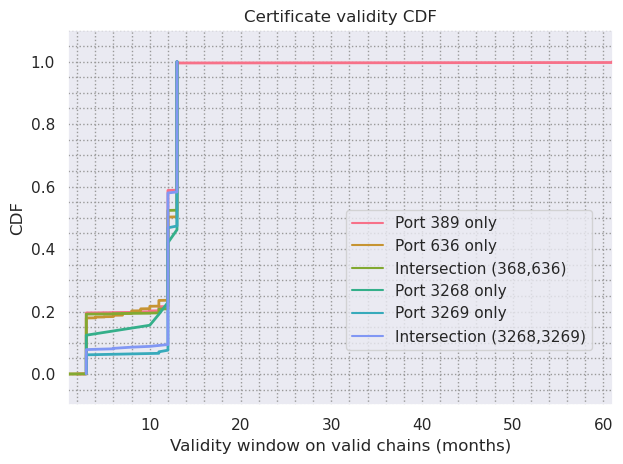

In [1161]:
valid_starttls_only_pdf = valid_starttls_only_pdf.sort_values(by=['validity_window_months'])
valid_starttls_only_pdf['cdf'] = valid_starttls_only_pdf['validity_window_months'].cumsum() / valid_starttls_only_pdf['validity_window_months'].sum()

valid_ldaps_only_pdf = valid_ldaps_only_pdf.sort_values(by=['validity_window_months'])
valid_ldaps_only_pdf['cdf'] = valid_ldaps_only_pdf['validity_window_months'].cumsum() / valid_ldaps_only_pdf['validity_window_months'].sum()

valid_inter_hosts_pdf = valid_inter_hosts_pdf.sort_values(by=['validity_window_months'])
valid_inter_hosts_pdf['cdf'] = valid_inter_hosts_pdf['validity_window_months'].cumsum() / valid_inter_hosts_pdf['validity_window_months'].sum()

################################

gc_valid_starttls_only_pdf = gc_valid_starttls_only_pdf.sort_values(by=['validity_window_months'])
gc_valid_starttls_only_pdf['cdf'] = gc_valid_starttls_only_pdf['validity_window_months'].cumsum() / gc_valid_starttls_only_pdf['validity_window_months'].sum()

gc_valid_ldaps_only_pdf = gc_valid_ldaps_only_pdf.sort_values(by=['validity_window_months'])
gc_valid_ldaps_only_pdf['cdf'] = gc_valid_ldaps_only_pdf['validity_window_months'].cumsum() / gc_valid_ldaps_only_pdf['validity_window_months'].sum()

gc_valid_inter_hosts_pdf = gc_valid_inter_hosts_pdf.sort_values(by=['validity_window_months'])
gc_valid_inter_hosts_pdf['cdf'] = gc_valid_inter_hosts_pdf['validity_window_months'].cumsum() / gc_valid_inter_hosts_pdf['validity_window_months'].sum()

################################

fig, ax1 = plt.subplots()

valid_starttls_only_pdf.plot(x='validity_window_months', y='cdf', ax=ax1, linewidth=2, color=sns.color_palette()[0], label='Port 389 only', backend='matplotlib')
valid_ldaps_only_pdf.plot(x='validity_window_months', y='cdf', ax=ax1, linewidth=2, color=sns.color_palette()[1], label='Port 636 only', backend='matplotlib')
valid_inter_hosts_pdf.plot(x='validity_window_months', y='cdf', ax=ax1, linewidth=2, color=sns.color_palette()[2], label='Intersection (368,636)', backend='matplotlib')

gc_valid_starttls_only_pdf.plot(x='validity_window_months', y='cdf', ax=ax1, linewidth=2, color=sns.color_palette()[3], label='Port 3268 only', backend='matplotlib')
gc_valid_ldaps_only_pdf.plot(x='validity_window_months', y='cdf', ax=ax1, linewidth=2, color=sns.color_palette()[4], label='Port 3269 only', backend='matplotlib')
gc_valid_inter_hosts_pdf.plot(x='validity_window_months', y='cdf', ax=ax1, linewidth=2, color=sns.color_palette()[5], label='Intersection (3268,3269)', backend='matplotlib')


ax1.legend().set_visible(False)
ax1.set_ylim(-0.1, 1.1)
ax1.set_title("Certificate validity CDF")
ax1.set_xlabel("Validity window on valid chains (months)")
ax1.set_ylabel("CDF")
ax1.margins(x=0,y=0)
#ax1.set_xscale("log")
#ax1.set_yscale("log")
ax1.minorticks_on()
ax1.grid(True, which="minor")
ax1.grid(True, which="major")
fig.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
new_handles = [mlines.Line2D([], [], c=h.get_color()) for h in handles]
fig.legend(handles=new_handles, labels=labels, loc="right", bbox_to_anchor=(0.95, 0.4))
fig.savefig(f"output/valid_chains_cert_validity_separate_cdf.pdf", format="pdf", bbox_inches="tight")
fig.show()

CDF for invalid chains

In [1162]:
invalid_starttls_only_pdf = starttls_only_df.filter(
    psf.col("chain_error") != SHORT8
).select("validity_window_years").toPandas()

invalid_ldaps_only_pdf = ldaps_only_df.filter(
    psf.col("chain_error") != SHORT8
).select("validity_window_years").toPandas()

invalid_inter_hosts_pdf = inter_hosts_df.filter(
    psf.col("chain_error") != SHORT8
).select("validity_window_years").toPandas()

gc_invalid_starttls_only_pdf = gc_starttls_only_df.filter(
    psf.col("chain_error") != SHORT8
).select("validity_window_years").toPandas()

gc_invalid_ldaps_only_pdf = gc_ldaps_only_df.filter(
    psf.col("chain_error") != SHORT8
).select("validity_window_years").toPandas()

gc_invalid_inter_hosts_pdf = gc_inter_hosts_df.filter(
    psf.col("chain_error") != SHORT8
).select("validity_window_years").toPandas()

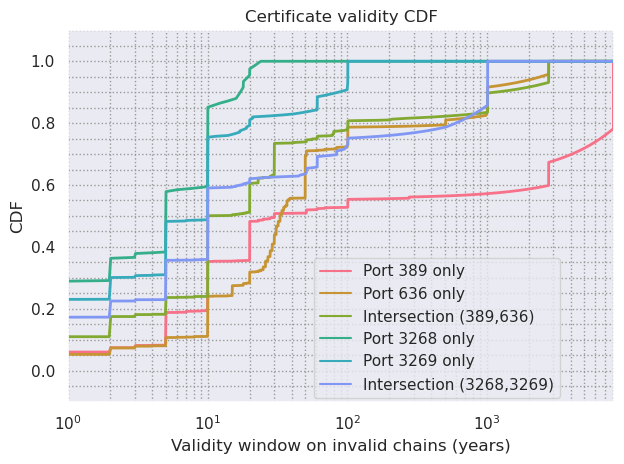

In [1163]:
invalid_starttls_only_pdf = invalid_starttls_only_pdf.sort_values(by=['validity_window_years'])
invalid_starttls_only_pdf['cdf'] = invalid_starttls_only_pdf['validity_window_years'].cumsum() / invalid_starttls_only_pdf['validity_window_years'].sum()

invalid_ldaps_only_pdf = invalid_ldaps_only_pdf.sort_values(by=['validity_window_years'])
invalid_ldaps_only_pdf['cdf'] = invalid_ldaps_only_pdf['validity_window_years'].cumsum() / invalid_ldaps_only_pdf['validity_window_years'].sum()

invalid_inter_hosts_pdf = invalid_inter_hosts_pdf.sort_values(by=['validity_window_years'])
invalid_inter_hosts_pdf['cdf'] = invalid_inter_hosts_pdf['validity_window_years'].cumsum() / invalid_inter_hosts_pdf['validity_window_years'].sum()

#########################################

gc_invalid_starttls_only_pdf = gc_invalid_starttls_only_pdf.sort_values(by=['validity_window_years'])
gc_invalid_starttls_only_pdf['cdf'] = gc_invalid_starttls_only_pdf['validity_window_years'].cumsum() / gc_invalid_starttls_only_pdf['validity_window_years'].sum()

gc_invalid_ldaps_only_pdf = gc_invalid_ldaps_only_pdf.sort_values(by=['validity_window_years'])
gc_invalid_ldaps_only_pdf['cdf'] = gc_invalid_ldaps_only_pdf['validity_window_years'].cumsum() / gc_invalid_ldaps_only_pdf['validity_window_years'].sum()

gc_invalid_inter_hosts_pdf = gc_invalid_inter_hosts_pdf.sort_values(by=['validity_window_years'])
gc_invalid_inter_hosts_pdf['cdf'] = gc_invalid_inter_hosts_pdf['validity_window_years'].cumsum() / gc_invalid_inter_hosts_pdf['validity_window_years'].sum()

#########################################

fig, ax1 = plt.subplots()

# Common x values for interpolation
max_x = max(invalid_starttls_only_pdf['validity_window_years'].max(),
            invalid_ldaps_only_pdf['validity_window_years'].max(),
            invalid_inter_hosts_pdf['validity_window_years'].max(),
            gc_invalid_starttls_only_pdf['validity_window_years'].max(),
            gc_invalid_ldaps_only_pdf['validity_window_years'].max(),
            gc_invalid_inter_hosts_pdf['validity_window_years'].max()
            )
size = max(len(invalid_starttls_only_pdf),
           len(invalid_ldaps_only_pdf),
           len(invalid_inter_hosts_pdf),
           len(gc_invalid_starttls_only_pdf),
           len(gc_invalid_ldaps_only_pdf),
           len(gc_invalid_inter_hosts_pdf)
           )
min_x = 1  # log graph
x_common = np.linspace(min_x, max_x, 10*size)

# Interpolate the CDF values to the common x-values
cdf0_interp = np.interp(x_common, invalid_starttls_only_pdf['validity_window_years'], invalid_starttls_only_pdf['cdf'])
cdf1_interp = np.interp(x_common, invalid_ldaps_only_pdf['validity_window_years'], invalid_ldaps_only_pdf['cdf'])
cdf2_interp = np.interp(x_common, invalid_inter_hosts_pdf['validity_window_years'], invalid_inter_hosts_pdf['cdf'])
cdf3_interp = np.interp(x_common, gc_invalid_starttls_only_pdf['validity_window_years'], gc_invalid_starttls_only_pdf['cdf'])
cdf4_interp = np.interp(x_common, gc_invalid_ldaps_only_pdf['validity_window_years'], gc_invalid_ldaps_only_pdf['cdf'])
cdf5_interp = np.interp(x_common, gc_invalid_inter_hosts_pdf['validity_window_years'], gc_invalid_inter_hosts_pdf['cdf'])

# ploting
plt.plot(x_common, cdf0_interp, linewidth=2, color=sns.color_palette()[0], label='Port 389 only')
plt.plot(x_common, cdf1_interp, linewidth=2, color=sns.color_palette()[1], label='Port 636 only')
plt.plot(x_common, cdf2_interp, linewidth=2, color=sns.color_palette()[2], label='Intersection (389,636)')
plt.plot(x_common, cdf3_interp, linewidth=2, color=sns.color_palette()[3], label='Port 3268 only')
plt.plot(x_common, cdf4_interp, linewidth=2, color=sns.color_palette()[4], label='Port 3269 only')
plt.plot(x_common, cdf5_interp, linewidth=2, color=sns.color_palette()[5], label='Intersection (3268,3269)')

ax1.legend().set_visible(False)
#ax1.set_ylim(-0.01, 1.01)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlim(1, max_x*(1.01))
ax1.set_title("Certificate validity CDF")
ax1.set_xlabel("Validity window on invalid chains (years)")
ax1.set_ylabel("CDF")
ax1.margins(x=0,y=0)
ax1.set_xscale("log")
#ax1.set_yscale("log")
ax1.minorticks_on()
ax1.grid(True, which="minor")
ax1.grid(True, which="major")
fig.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
new_handles = [mlines.Line2D([], [], c=h.get_color()) for h in handles]
fig.legend(handles=new_handles, labels=labels, loc="right", bbox_to_anchor=(0.9, 0.3))
fig.savefig(f"output/invalid_chains_cert_validity_separate_cdf.pdf", format="pdf", bbox_inches="tight")
fig.show()

Valid and invalid chain, all in the same plot

In [ ]:
goscanner_df = get_validity(goscanner_df)

window_invalid_stls_pdf = goscanner_df.filter(
    psf.col("port") == 389
).dropDuplicates(
    ["ipv4"]
).filter(
    psf.col("chain_error") != SHORT8
).select("validity_window_years").toPandas()

window_invalid_ldaps_pdf = goscanner_df.filter(
    psf.col("port") == 636
).dropDuplicates(
    ["ipv4"]
).filter(
    psf.col("chain_error") != SHORT8
).select("validity_window_years").toPandas()

window_valid_stls_pdf = goscanner_df.filter(
    psf.col("port") == 389
).dropDuplicates(
    ["ipv4"]
).filter(
    psf.col("chain_error") == SHORT8
).select("validity_window_months").toPandas()

window_valid_ldaps_pdf = goscanner_df.filter(
    psf.col("port") == 636
).dropDuplicates(
    ["ipv4"]
).filter(
    psf.col("chain_error") == SHORT8
).select("validity_window_months").toPandas()

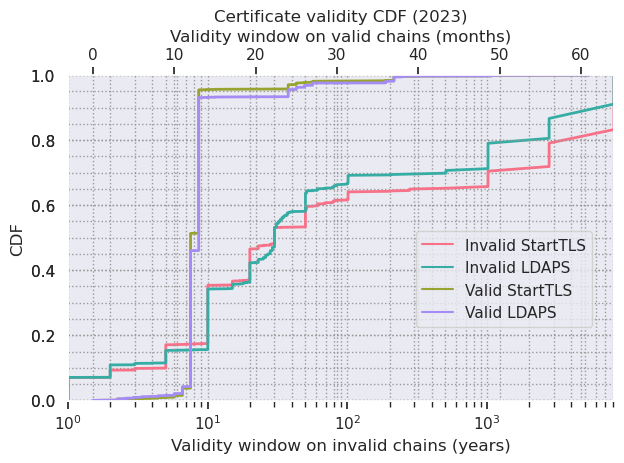

In [ ]:
_window_invalid_stls_pdf = window_invalid_stls_pdf.sort_values(by=['validity_window_years'])
_window_invalid_stls_pdf['cdf'] = _window_invalid_stls_pdf['validity_window_years'].cumsum() / _window_invalid_stls_pdf['validity_window_years'].sum()

_window_valid_stls_pdf = window_valid_stls_pdf.sort_values(by=['validity_window_months'])
_window_valid_stls_pdf['cdf'] = _window_valid_stls_pdf['validity_window_months'].cumsum() / _window_valid_stls_pdf['validity_window_months'].sum()

_window_invalid_ldaps_pdf = window_invalid_ldaps_pdf.sort_values(by=['validity_window_years'])
_window_invalid_ldaps_pdf['cdf'] = _window_invalid_ldaps_pdf['validity_window_years'].cumsum() / _window_invalid_ldaps_pdf['validity_window_years'].sum()

_window_valid_ldaps_pdf = window_valid_ldaps_pdf.sort_values(by=['validity_window_months'])
_window_valid_ldaps_pdf['cdf'] = _window_valid_ldaps_pdf['validity_window_months'].cumsum() / _window_valid_ldaps_pdf['validity_window_months'].sum()

fig, ax1 = plt.subplots()
ax2 = ax1.twiny()

_window_invalid_stls_pdf.plot(x='validity_window_years', y='cdf', ax=ax1, linewidth=2, color=sns.color_palette()[0], label='Invalid StartTLS')  # color='blue', 
_window_valid_stls_pdf.plot(x='validity_window_months', y='cdf', ax=ax2, linewidth=2, color=sns.color_palette()[1], label='Valid StartTLS')  # color='red', 
_window_invalid_ldaps_pdf.plot(x='validity_window_years', y='cdf', ax=ax1, linewidth=2, color=sns.color_palette()[2], label='Invalid LDAPS')  # color='green', 
_window_valid_ldaps_pdf.plot(x='validity_window_months', y='cdf', ax=ax2, linewidth=2, color=sns.color_palette()[3], label='Valid LDAPS')  # color='black', 

ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

ax1.set_title("Certificate validity CDF (2023)")
ax1.set_xlabel("Validity window on invalid chains (years)")
ax2.set_xlabel("Validity window on valid chains (months)")
ax1.set_ylabel("CDF")
ax1.margins(x=0,y=0)
ax1.set_xscale("log")
ax1.minorticks_on()
ax1.grid(True, which="minor")
ax1.grid(True, which="major")
fig.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
handles_tmp, labels_tmp = ax2.get_legend_handles_labels()
handles.extend(handles_tmp)
labels.extend(labels_tmp)
new_handles = [mlines.Line2D([], [], c=h.get_color()) for h in handles]
fig.legend(handles=new_handles, labels=labels, loc="right", bbox_to_anchor=(0.95, 0.4))
fig.savefig(f"output/validity_cdf.pdf", format="pdf", bbox_inches="tight")
fig.show()

#### Reuse of public key

End-host certs

In [217]:
goscanner_df.dropDuplicates(subset=["cert_hash"]).groupBy("pub_key_hash").count().sort("count", ascending=False).show(10)

+--------------------+-----+
|        pub_key_hash|count|
+--------------------+-----+
|db9f7b9ad7d221548...|   62|
|b141b325e6a5b09c2...|    4|
|901ccfe1925540c37...|    4|
|48070505eae651f88...|    3|
|4aea22786a9ad41ff...|    3|
|bfa7e929f035b2709...|    3|
|c9b913ba360c003f8...|    2|
|ecc045b1ce47aa8cd...|    2|
|cc6a919dafbc13a76...|    2|
|23e3580f58366e13e...|    2|
+--------------------+-----+
only showing top 10 rows



#### Extract certificates for FastGCD analysis

In [1090]:
from cryptography import x509
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.asymmetric import rsa

import pyspark.sql.types as pst


def get_moduli_from_pem(pem: str) -> str:
    try:
        cert = x509.load_pem_x509_certificate(str.encode(pem), default_backend())
    except ValueError:
        # the certificate contains bytes that cannot be interpreted. Probably invalid cert
        # https://github.com/pyca/cryptography/issues/6804
        return ""

    public_key = cert.public_key()
    if isinstance(public_key, rsa.RSAPublicKey):
        # remove 0x from hex, L if there is a L of Long Number and any unecessary left 0
        moduli = hex(public_key.public_numbers().n).lstrip("0x").rstrip("L").lstrip("0")
        return moduli

    return ""


get_moduli_udf = psf.udf(get_moduli_from_pem, pst.StringType())

##### Offline analysis for pwned keys

In [1089]:
print(goscanner_certs_df.select("ipv4", "port", "date", psf.explode("certificates").alias("peer_certificate")
).dropDuplicates(["peer_certificate"]).count())

44510


In [131]:
goscanner_certs_df.select("ipv4", "port", "date", psf.explode("certificates").alias("peer_certificate")
).dropDuplicates(["peer_certificate"]
).coalesce(1).write.mode("overwrite").option("header", "true").csv("../dataset/processing/ldap-sequel/unique_peer_certs")

In [132]:
!mv ../dataset/processing/ldap-sequel/unique_peer_certs/*.csv ../dataset/processing/ldap-sequel/unique_peer_certs.csv
!rm -rf ../dataset/processing/ldap-sequel/unique_peer_certs

Getting the moduli

In [1091]:
goscanner_certs_df.select("ipv4", "port", "date", psf.explode("certificates").alias("peer_certificate")
).dropDuplicates(["peer_certificate"]).withColumn(
    "moduli", get_moduli_udf(psf.col("peer_certificate"))
).select("moduli").distinct().coalesce(1).write.mode("overwrite").parquet("../dataset/processing/ldap-sequel/unique_peer_certs_moduli")

In [1092]:
print(goscanner_certs_df.select("ipv4", "port", "date", psf.explode("certificates").alias("peer_certificate")
).dropDuplicates(["peer_certificate"]).withColumn(
    "moduli", get_moduli_udf(psf.col("peer_certificate"))
).select("moduli").distinct().count())

42839


In [1093]:
!mv ../dataset/processing/ldap-sequel/unique_peer_certs_moduli/*.parquet ../dataset/processing/ldap-sequel/unique_peer_certs_moduli.parquet
!rm -rf ../dataset/processing/ldap-sequel/unique_peer_certs_moduli

935113.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
935118.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


### Correlating data sets

#### Correlate deployment types with hosting orgs

OpenLDAP

In [1061]:
def get_aggr_providers_for_openldap(provider_df, ldap_type_df):
    return provider_df.join(ldap_type_df,
                on=["id", "ipv4", "port", "date"],
                how="inner"
    ).filter(
        psf.col("server_name") == "OpenLDAP"
    ).dropDuplicates(["ipv4"]).withColumn(
        "cloud_provider",
         psf.when(psf.lower(psf.col("cloud_provider")).contains("hetzner"), "Hetzner")
            .when(psf.lower(psf.col("cloud_provider")).contains("aws"), "Amazon")
            .when(psf.lower(psf.col("cloud_provider")).contains("amazon"), "Amazon")
            .when(psf.lower(psf.col("cloud_provider")).contains("azure"), "Microsoft")
            .when(psf.lower(psf.col("cloud_provider")).contains("google"), "Google")
            .otherwise(psf.col("cloud_provider"))
    ).groupBy("cloud_provider").count().withColumn(
        "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
    ).sort("count", ascending=False).toPandas()

# ldap_fp_df contains LDAP server types
hfp_all_pdf = get_aggr_providers_for_openldap(ips_df, ldap_fp_df)
hfp_starttls_only_pdf = get_aggr_providers_for_openldap(h_starttls_only_df, ldap_fp_df)
hfp_ldaps_only_pdf = get_aggr_providers_for_openldap(h_ldaps_only_df, ldap_fp_df)
hfp_inter_hosts_pdf = get_aggr_providers_for_openldap(h_inter_hosts_df, ldap_fp_df)

gc_hfp_starttls_only_pdf = get_aggr_providers_for_openldap(gc_h_starttls_only_df, ldap_fp_df)
gc_hfp_ldaps_only_pdf = get_aggr_providers_for_openldap(gc_h_ldaps_only_df, ldap_fp_df)
gc_hfp_inter_hosts_pdf = get_aggr_providers_for_openldap(gc_h_inter_hosts_df, ldap_fp_df)

In [1062]:
hfp_all_column_pdf = hfp_all_pdf.rename(columns={"percent": "all_uniq_ips"}).drop(columns=["count"], axis=1)
hfp_ldap_pdf = merge_pdf(hfp_all_column_pdf,
                        hfp_starttls_only_pdf.drop(columns=["count"], axis=1),
                        "cloud_provider", "percent", "starttls_only")
hfp_ldap_pdf = merge_pdf(hfp_ldap_pdf,
                            hfp_ldaps_only_pdf.drop(columns=["count"], axis=1),
                            "cloud_provider", "percent", "ldaps_only")
hfp_ldap_pdf = merge_pdf(hfp_ldap_pdf,
                            hfp_inter_hosts_pdf.drop(columns=["count"], axis=1),
                            "cloud_provider", "percent", "intersection")
hfp_ldap_pdf = merge_pdf(hfp_ldap_pdf,
                            gc_hfp_starttls_only_pdf.drop(columns=["count"], axis=1),
                            "cloud_provider", "percent", "gc_starttls_only")
hfp_ldap_pdf = merge_pdf(hfp_ldap_pdf,
                            gc_hfp_ldaps_only_pdf.drop(columns=["count"], axis=1),
                            "cloud_provider", "percent", "gc_ldaps_only")
hfp_ldap_pdf = merge_pdf(hfp_ldap_pdf,
                            gc_hfp_inter_hosts_pdf.drop(columns=["count"], axis=1),
                            "cloud_provider", "percent", "gc_intersection")

hfp_ldap_pdf.loc[-1] = ["Total",
                        hfp_all_pdf["count"].sum(),
                        hfp_starttls_only_pdf["count"].sum(),
                        hfp_ldaps_only_pdf["count"].sum(),
                        hfp_inter_hosts_pdf["count"].sum(),
                        gc_hfp_starttls_only_pdf["count"].sum(),
                        gc_hfp_ldaps_only_pdf["count"].sum(),
                        gc_hfp_inter_hosts_pdf["count"].sum(),
                    ]  # adding a row
hfp_ldap_pdf.index = hfp_ldap_pdf.index + 1  # shifting index
hfp_ldap_pdf.sort_index(inplace=True)

display(hfp_ldap_pdf.loc[:5])

,cloud_provider,all_uniq_ips,starttls_only,ldaps_only,intersection,gc_starttls_only,gc_ldaps_only,gc_intersection
0,Total,24882.0,15875.0,2201.0,6791.0,0.0,3.0,0.0
1,Unknown,51.9,45.5,47.4,68.3,NaN,100.0,NaN
2,Hetzner,4.6,4.7,8.8,2.9,NaN,NaN,NaN
3,OVH SAS,4.3,5.4,4.4,1.8,NaN,NaN,NaN
4,Amazon,4.2,3.7,7.9,4.3,NaN,NaN,NaN
5,Contabo GmbH,1.9,2.6,0.6,0.7,NaN,NaN,NaN


In [1087]:
len(hfp_ldap_pdf) - 2

2026

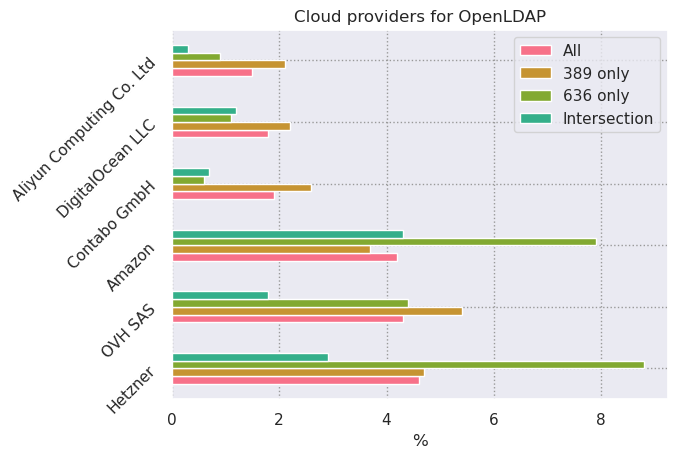

In [1063]:
ax = hfp_ldap_pdf.loc[2:7].plot(
    x="cloud_provider",
    y=["all_uniq_ips", "starttls_only", "ldaps_only", "intersection"],
    kind="barh",
    rot=45,
)

_ = ax.set_title("Cloud providers for OpenLDAP")
_ = ax.set_ylabel("")
_ = ax.set_xlabel("%")
_ = ax.minorticks_on()
_ = ax.legend(["All", "389 only", "636 only", "Intersection"])
plt.savefig(f"output/cloud_providers_openldap.pdf", format="pdf", bbox_inches="tight")

Windows

In [1064]:
def get_aggr_providers_for_windows(provider_df, ldap_type_df):
    return provider_df.join(ldap_type_df,
                on=["id", "ipv4", "port", "date"],
                how="inner"
    ).filter(
        psf.col("server_name").contains("Windows")
    ).dropDuplicates(["ipv4"]).withColumn(
        "cloud_provider",
         psf.when(psf.lower(psf.col("cloud_provider")).contains("hetzner"), "Hetzner")
            .when(psf.lower(psf.col("cloud_provider")).contains("aws"), "Amazon")
            .when(psf.lower(psf.col("cloud_provider")).contains("amazon"), "Amazon")
            .when(psf.lower(psf.col("cloud_provider")).contains("azure"), "Microsoft")
            .when(psf.lower(psf.col("cloud_provider")).contains("google"), "Google")
            .otherwise(psf.col("cloud_provider"))
    ).groupBy("cloud_provider").count().withColumn(
        "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
    ).sort("count", ascending=False).toPandas()


hfp_all_pdf2 = get_aggr_providers_for_windows(ips_df, ldap_fp_df)
hfp_starttls_only_pdf2 = get_aggr_providers_for_windows(h_starttls_only_df, ldap_fp_df)
hfp_ldaps_only_pdf2 = get_aggr_providers_for_windows(h_ldaps_only_df, ldap_fp_df)
hfp_inter_hosts_pdf2 = get_aggr_providers_for_windows(h_inter_hosts_df, ldap_fp_df)

gc_hfp_starttls_only_pdf2 = get_aggr_providers_for_windows(gc_h_starttls_only_df, ldap_fp_df)
gc_hfp_ldaps_only_pdf2 = get_aggr_providers_for_windows(gc_h_ldaps_only_df, ldap_fp_df)
gc_hfp_inter_hosts_pdf2 = get_aggr_providers_for_windows(gc_h_inter_hosts_df, ldap_fp_df)


In [1065]:
hfp_all_column_pdf2 = hfp_all_pdf2.rename(columns={"percent": "all_uniq_ips"}).drop(columns=["count"], axis=1)
hfp_ldap_pdf2 = merge_pdf(hfp_all_column_pdf2,
                        hfp_starttls_only_pdf2.drop(columns=["count"], axis=1),
                        "cloud_provider", "percent", "starttls_only")
hfp_ldap_pdf2 = merge_pdf(hfp_ldap_pdf2,
                            hfp_ldaps_only_pdf2.drop(columns=["count"], axis=1),
                            "cloud_provider", "percent", "ldaps_only")
hfp_ldap_pdf2 = merge_pdf(hfp_ldap_pdf2,
                            hfp_inter_hosts_pdf2.drop(columns=["count"], axis=1),
                            "cloud_provider", "percent", "intersection")
hfp_ldap_pdf2 = merge_pdf(hfp_ldap_pdf2,
                            gc_hfp_starttls_only_pdf2.drop(columns=["count"], axis=1),
                            "cloud_provider", "percent", "gc_starttls_only")
hfp_ldap_pdf2 = merge_pdf(hfp_ldap_pdf2,
                            gc_hfp_ldaps_only_pdf2.drop(columns=["count"], axis=1),
                            "cloud_provider", "percent", "gc_ldaps_only")
hfp_ldap_pdf2 = merge_pdf(hfp_ldap_pdf2,
                            gc_hfp_inter_hosts_pdf2.drop(columns=["count"], axis=1),
                            "cloud_provider", "percent", "gc_intersection")

hfp_ldap_pdf2.loc[-1] = ["Total",
                        hfp_all_pdf2["count"].sum(),
                        hfp_starttls_only_pdf2["count"].sum(),
                        hfp_ldaps_only_pdf2["count"].sum(),
                        hfp_inter_hosts_pdf2["count"].sum(),
                        gc_hfp_starttls_only_pdf2["count"].sum(),
                        gc_hfp_ldaps_only_pdf2["count"].sum(),
                        gc_hfp_inter_hosts_pdf2["count"].sum(),
                    ]  # adding a row
hfp_ldap_pdf2.index = hfp_ldap_pdf2.index + 1  # shifting index
hfp_ldap_pdf2.sort_index(inplace=True)

display(hfp_ldap_pdf2.loc[:5])

,cloud_provider,all_uniq_ips,starttls_only,ldaps_only,intersection,gc_starttls_only,gc_ldaps_only,gc_intersection
0,Total,33408.0,16135.0,5104.0,6108.0,10687.0,1727.0,4094.0
1,Unknown,50.6,51.3,52.3,54.6,41.1,54.7,52.4
2,Microsoft,5.1,2.7,20.0,2.7,1.8,5.2,1.5
3,OVH SAS,4.0,4.0,1.2,2.9,7.0,2.3,4.5
4,Amazon,3.7,3.8,4.8,4.6,1.9,3.6,2.8
5,Contabo GmbH,2.8,3.6,0.4,2.8,3.8,2.3,3.4


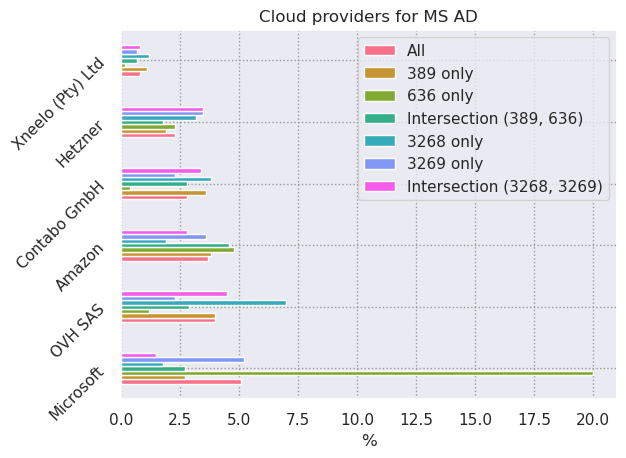

In [1066]:
ax = hfp_ldap_pdf2.loc[2:7].plot(
    x="cloud_provider",
    y=["all_uniq_ips", "starttls_only", "ldaps_only", "intersection", "gc_starttls_only", "gc_ldaps_only", "gc_intersection"],
    kind="barh",
    rot=45,
)

_ = ax.set_title("Cloud providers for MS AD")
_ = ax.set_ylabel("")
_ = ax.set_xlabel("%")
_ = ax.minorticks_on()
_ = ax.legend(["All", "389 only", "636 only", "Intersection (389, 636)", "3268 only", "3269 only", "Intersection (3268, 3269)"])
plt.savefig(f"output/cloud_providers_msad.pdf", format="pdf", bbox_inches="tight")

Others

In [1067]:
def get_aggr_providers_for_others(provider_df, ldap_type_df):
    return provider_df.join(ldap_type_df,
                on=["id", "ipv4", "port", "date"],
                how="inner"
    ).filter(
        ~((psf.col("server_name").contains("Windows"))
        | (psf.col("server_name") == "OpenLDAP"))
    ).dropDuplicates(["ipv4"]).withColumn(
        "cloud_provider",
         psf.when(psf.lower(psf.col("cloud_provider")).contains("hetzner"), "Hetzner")
            .when(psf.lower(psf.col("cloud_provider")).contains("aws"), "Amazon")
            .when(psf.lower(psf.col("cloud_provider")).contains("amazon"), "Amazon")
            .when(psf.lower(psf.col("cloud_provider")).contains("azure"), "Microsoft")
            .when(psf.lower(psf.col("cloud_provider")).contains("google"), "Google")
            .otherwise(psf.col("cloud_provider"))
    ).groupBy("cloud_provider").count().withColumn(
        "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
    ).sort("count", ascending=False).toPandas()


hfp_all_pdf3 = get_aggr_providers_for_others(ips_df, ldap_fp_df)
hfp_starttls_only_pdf3 = get_aggr_providers_for_others(h_starttls_only_df, ldap_fp_df)
hfp_ldaps_only_pdf3 = get_aggr_providers_for_others(h_ldaps_only_df, ldap_fp_df)
hfp_inter_hosts_pdf3 = get_aggr_providers_for_others(h_inter_hosts_df, ldap_fp_df)

gc_hfp_starttls_only_pdf3 = get_aggr_providers_for_others(gc_h_starttls_only_df, ldap_fp_df)
gc_hfp_ldaps_only_pdf3 = get_aggr_providers_for_others(gc_h_ldaps_only_df, ldap_fp_df)
gc_hfp_inter_hosts_pdf3 = get_aggr_providers_for_others(gc_h_inter_hosts_df, ldap_fp_df)

In [1068]:
hfp_all_column_pdf3 = hfp_all_pdf3.rename(columns={"percent": "all_uniq_ips"}).drop(columns=["count"], axis=1)
hfp_ldap_pdf3 = merge_pdf(hfp_all_column_pdf3,
                        hfp_starttls_only_pdf3.drop(columns=["count"], axis=1),
                        "cloud_provider", "percent", "starttls_only")
hfp_ldap_pdf3 = merge_pdf(hfp_ldap_pdf3,
                            hfp_ldaps_only_pdf3.drop(columns=["count"], axis=1),
                            "cloud_provider", "percent", "ldaps_only")
hfp_ldap_pdf3 = merge_pdf(hfp_ldap_pdf3,
                            hfp_inter_hosts_pdf3.drop(columns=["count"], axis=1),
                            "cloud_provider", "percent", "intersection")
hfp_ldap_pdf3 = merge_pdf(hfp_ldap_pdf3,
                            gc_hfp_starttls_only_pdf3.drop(columns=["count"], axis=1),
                            "cloud_provider", "percent", "gc_starttls_only")
hfp_ldap_pdf3 = merge_pdf(hfp_ldap_pdf3,
                            gc_hfp_ldaps_only_pdf3.drop(columns=["count"], axis=1),
                            "cloud_provider", "percent", "gc_ldaps_only")
hfp_ldap_pdf3 = merge_pdf(hfp_ldap_pdf3,
                            gc_hfp_inter_hosts_pdf3.drop(columns=["count"], axis=1),
                            "cloud_provider", "percent", "gc_intersection")

hfp_ldap_pdf3.loc[-1] = ["Total",
                        hfp_all_pdf3["count"].sum(),
                        hfp_starttls_only_pdf3["count"].sum(),
                        hfp_ldaps_only_pdf3["count"].sum(),
                        hfp_inter_hosts_pdf3["count"].sum(),
                        gc_hfp_starttls_only_pdf3["count"].sum(),
                        gc_hfp_ldaps_only_pdf3["count"].sum(),
                        gc_hfp_inter_hosts_pdf3["count"].sum(),
                    ]  # adding a row
hfp_ldap_pdf3.index = hfp_ldap_pdf3.index + 1  # shifting index
hfp_ldap_pdf3.sort_index(inplace=True)

display(hfp_ldap_pdf3.loc[:5])

,cloud_provider,all_uniq_ips,starttls_only,ldaps_only,intersection,gc_starttls_only,gc_ldaps_only,gc_intersection
0,Total,8217.0,719.0,1777.0,5710.0,1.0,7.0,3.0
1,Unknown,45.6,60.9,48.7,42.7,100.0,28.6,66.7
2,Hetzner,5.8,2.1,4.8,6.5,NaN,14.3,NaN
3,Amazon,5.7,3.8,16.9,2.5,NaN,NaN,NaN
4,NhanHoa Software Company,4.4,NaN,0.1,6.3,NaN,NaN,NaN
5,OVH SAS,2.6,0.8,0.6,3.5,NaN,NaN,NaN


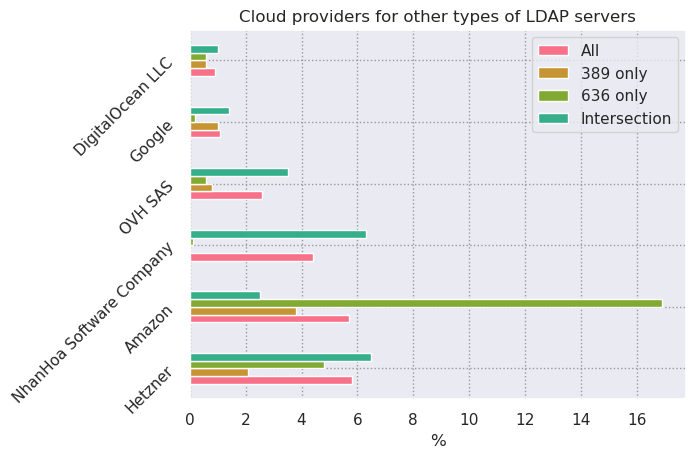

In [1069]:
ax = hfp_ldap_pdf3.loc[2:7].plot(
    x="cloud_provider",
    y=["all_uniq_ips", "starttls_only", "ldaps_only", "intersection"],
    kind="barh",
    rot=45,
)

_ = ax.set_title("Cloud providers for other types of LDAP servers")
_ = ax.set_ylabel("")
_ = ax.set_xlabel("%")
_ = ax.minorticks_on()
_ = ax.legend(["All", "389 only", "636 only", "Intersection"])
plt.savefig(f"output/cloud_providers_other_ldap.pdf", format="pdf", bbox_inches="tight")

What about the unknowns?

In [738]:
def get_aggr_unknown_for_different_types(provider_df, ldap_type_df):
    return provider_df.join(ldap_type_df,
                on=["id", "ipv4", "port", "date"],
                how="inner"
    ).filter(
        psf.col("cloud_provider") == "Unknown"
    ).dropDuplicates(["ipv4"]).groupBy("server_name").count().withColumn(
        "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
    ).sort("count", ascending=False).toPandas()

# ldap_fp_df contains LDAP server types
hfp_all_pdf4 = get_aggr_unknown_for_different_types(ips_df, ldap_fp_df)
hfp_starttls_only_pdf4 = get_aggr_unknown_for_different_types(h_starttls_only_df, ldap_fp_df)
hfp_ldaps_only_pdf4 = get_aggr_unknown_for_different_types(h_ldaps_only_df, ldap_fp_df)
hfp_inter_hosts_pdf4 = get_aggr_unknown_for_different_types(h_inter_hosts_df, ldap_fp_df)

gc_hfp_starttls_only_pdf4 = get_aggr_unknown_for_different_types(gc_h_starttls_only_df, ldap_fp_df)
gc_hfp_ldaps_only_pdf4 = get_aggr_unknown_for_different_types(gc_h_ldaps_only_df, ldap_fp_df)
gc_hfp_inter_hosts_pdf4 = get_aggr_unknown_for_different_types(gc_h_inter_hosts_df, ldap_fp_df)

In [758]:
hfp_all_column_pdf4 = hfp_all_pdf4.rename(columns={"percent": "all_uniq_ips"}).drop(columns=["count"], axis=1)
hfp_ldap_pdf4 = merge_pdf(hfp_all_column_pdf4,
                        hfp_starttls_only_pdf4.drop(columns=["count"], axis=1),
                        "server_name", "percent", "starttls_only")
hfp_ldap_pdf4 = merge_pdf(hfp_ldap_pdf4,
                            hfp_ldaps_only_pdf4.drop(columns=["count"], axis=1),
                            "server_name", "percent", "ldaps_only")
hfp_ldap_pdf4 = merge_pdf(hfp_ldap_pdf4,
                            hfp_inter_hosts_pdf4.drop(columns=["count"], axis=1),
                            "server_name", "percent", "intersection")
hfp_ldap_pdf4 = merge_pdf(hfp_ldap_pdf4,
                            gc_hfp_starttls_only_pdf4.drop(columns=["count"], axis=1),
                            "server_name", "percent", "gc_starttls_only")
hfp_ldap_pdf4 = merge_pdf(hfp_ldap_pdf4,
                            gc_hfp_ldaps_only_pdf4.drop(columns=["count"], axis=1),
                            "server_name", "percent", "gc_ldaps_only")
hfp_ldap_pdf4 = merge_pdf(hfp_ldap_pdf4,
                            gc_hfp_inter_hosts_pdf4.drop(columns=["count"], axis=1),
                            "server_name", "percent", "gc_intersection")

hfp_ldap_pdf4.loc[-1] = ["Total",
                        hfp_all_pdf4["count"].sum(),
                        hfp_starttls_only_pdf4["count"].sum(),
                        hfp_ldaps_only_pdf4["count"].sum(),
                        hfp_inter_hosts_pdf4["count"].sum(),
                        gc_hfp_starttls_only_pdf4["count"].sum(),
                        gc_hfp_ldaps_only_pdf4["count"].sum(),
                        gc_hfp_inter_hosts_pdf4["count"].sum(),
                    ]  # adding a row
hfp_ldap_pdf4.index = hfp_ldap_pdf4.index + 1  # shifting index
hfp_ldap_pdf4.sort_index(inplace=True)

display(hfp_ldap_pdf4.loc[:5])

,server_name,all_uniq_ips,starttls_only,ldaps_only,intersection,gc_starttls_only,gc_ldaps_only,gc_intersection
0,Total,35112.0,16819.0,4902.0,10664.0,4410.0,950.0,2149.0
1,OpenLDAP,36.8,43.0,21.3,43.5,NaN,0.3,NaN
2,Windows Server 2016,18.5,20.9,19.4,8.9,45.9,28.6,27.8
3,Microsoft Active Directory Controller on Windo...,11.0,10.4,13.9,8.2,20.2,29.8,27.9
4,Microsoft Active Directory Controller on Windo...,9.0,8.9,11.3,5.4,20.0,18.8,19.7
5,Kerio Connect,7.2,0.8,15.4,15.4,0.0,0.2,0.0


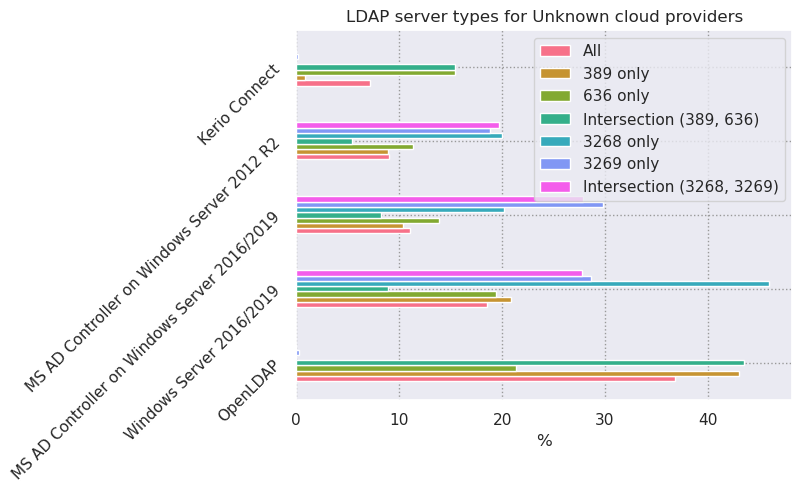

In [763]:
mod_server_name = {}
for server_name in hfp_ldap_pdf4["server_name"].to_list():
    if server_name is None:
        continue
    mod_server_name[server_name] = server_name.replace("Microsoft", "MS").replace("Active Directory", "AD").replace("Domain Controller", "DC").replace("Lightweight Directory Access Protocol", "LDAP").replace("Windows Server 2016", "Windows Server 2016/2019")

hfp_ldap_pdf4["server_name"] = hfp_ldap_pdf4["server_name"].map(mod_server_name)
ax = hfp_ldap_pdf4.loc[1:5].plot(
    x="server_name",
    y=["all_uniq_ips", "starttls_only", "ldaps_only", "intersection", "gc_starttls_only", "gc_ldaps_only", "gc_intersection"],
    kind="barh",
    rot=45,
)

_ = ax.set_title("LDAP server types for Unknown cloud providers")
_ = ax.set_ylabel("")
_ = ax.set_xlabel("%")
_ = ax.minorticks_on()
_ = ax.legend(["All", "389 only", "636 only", "Intersection (389, 636)", "3268 only", "3269 only", "Intersection (3268, 3269)"])
plt.savefig(f"output/ldap_server_types_unknown_cloud.pdf", format="pdf", bbox_inches="tight")

#### Correlate LDAP types with TLS

In [794]:
# do the same for OpenLDAP, and others. Create a table, compare and conclude to use ciphers instead of tlsv;
# do the same with hosting providers
win_tlsv_pdf = goscanner_tls_df.join(ldap_fp_df,
                on=["id", "ipv4", "port", "date"],
                how="inner"
).filter(
    psf.col("server_name").contains("Windows")
).dropDuplicates(["ipv4"]).groupBy("protocol").count().withColumn(
    "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
).sort("count", ascending=False).toPandas()

openldap_tlsv_pdf = goscanner_tls_df.join(ldap_fp_df,
                on=["id", "ipv4", "port", "date"],
                how="inner"
).filter(
    psf.col("server_name") == "OpenLDAP"
).dropDuplicates(["ipv4"]).groupBy("protocol").count().withColumn(
    "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
).sort("count", ascending=False).toPandas()

others_tls_pdf = goscanner_tls_df.join(ldap_fp_df,
                on=["id", "ipv4", "port", "date"],
                how="inner"
).filter(
    ~((psf.col("server_name").contains("Windows"))
    | (psf.col("server_name") == "OpenLDAP"))
).dropDuplicates(["ipv4"]).groupBy("protocol").count().withColumn(
    "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
).sort("count", ascending=False).toPandas()

r_win_tlsv_pdf = win_tlsv_pdf.rename(columns={"count": "Microsoft"}).drop(columns=["percent"], axis=1)
ldap_type_tlsv_pdf = merge_pdf(r_win_tlsv_pdf,
                        openldap_tlsv_pdf.drop(columns=["percent"], axis=1),
                        "protocol", "count", "OpenLDAP")
ldap_type_tlsv_pdf = merge_pdf(ldap_type_tlsv_pdf,
                            others_tls_pdf.drop(columns=["percent"], axis=1),
                            "protocol", "count", "Other types")
display(ldap_type_tlsv_pdf)

,protocol,Microsoft,OpenLDAP,Other types
0,771,11910,8433,3205.0
1,772,2093,9474,4570.0
2,769,708,346,80.0
3,770,5,43,NaN


In [823]:
def percentage_deprecated_tls(product):
    return ldap_type_tlsv_pdf[
        (ldap_type_tlsv_pdf["protocol"] == 769)
        | (ldap_type_tlsv_pdf["protocol"] == 770)
    ][product].sum() / ldap_type_tlsv_pdf[product].sum()

win_percent = percentage_deprecated_tls("Microsoft")
openldap_percent = percentage_deprecated_tls("OpenLDAP")
other_percent = percentage_deprecated_tls("Other types")
print(f"Percentage of deprecated TLS versions for Microsoft: {win_percent:.2f}%")
print(f"Percentage of deprecated TLS versions for OpenLDAP: {openldap_percent:.2f}%")
print(f"Percentage of deprecated TLS versions for other types: {other_percent:.2f}%")

Percentage of deprecated TLS versions for Microsoft: 0.05%
Percentage of deprecated TLS versions for OpenLDAP: 0.02%
Percentage of deprecated TLS versions for other types: 0.01%


Types of LDAP server that uses TLSv 1.0 and 1.1

In [779]:
goscanner_tls_df.join(ldap_fp_df,
                on=["id", "ipv4", "port", "date"],
                how="inner"
).filter(
    (psf.col("protocol") == "769")
    | (psf.col("protocol") == "770")
).filter(psf.col("server_name").isNotNull()
).dropDuplicates(["ipv4"]).groupBy("server_name").count(
).sort("count", ascending=False).show(truncate=False)

+----------------------------------------------------------------+-----+
|server_name                                                     |count|
+----------------------------------------------------------------+-----+
|Microsoft Active Directory Controller on Windows Server 2008 R2 |419  |
|OpenLDAP                                                        |394  |
|Microsoft Active Directory Controller on Windows Server 2008    |99   |
|Microsoft Active Directory Controller on Windows Server 2000    |99   |
|Microsoft Active Directory Controller on Windows Server 2003    |90   |
|Kerio Connect                                                   |42   |
|Oracle Sun Directory Server                                     |13   |
|Fedora Project 389 Directory Server                             |11   |
|Sun Java System Directory Server                                |7    |
|Sun Directory Server                                            |4    |
|Microsoft Lightweight Directory Server on Windows 

as the majority uses TLSv1.2 and 1.3, let's see cipher suites...

In [807]:
windows_ciphers_pdf = goscanner_tls_df.join(ldap_fp_df,
                on=["id", "ipv4", "port", "date"],
                how="inner"
).filter(
    psf.col("server_name").contains("Windows")
).dropDuplicates(["ipv4"]).groupBy("cipher").count().withColumn(
    "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
).sort("count", ascending=False).toPandas()

openldap_ciphers_pdf = goscanner_tls_df.join(ldap_fp_df,
                on=["id", "ipv4", "port", "date"],
                how="inner"
).filter(
    psf.col("server_name") == "OpenLDAP"
).dropDuplicates(["ipv4"]).groupBy("cipher").count().withColumn(
    "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
).sort("count", ascending=False).toPandas()

other_types_ciphers_pdf = goscanner_tls_df.join(ldap_fp_df,
                on=["id", "ipv4", "port", "date"],
                how="inner"
).filter(
    ~((psf.col("server_name").contains("Windows"))
    | (psf.col("server_name") == "OpenLDAP"))
).dropDuplicates(["ipv4"]).groupBy("cipher").count().withColumn(
    "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
).sort("count", ascending=False).toPandas()

In [812]:
top_ciphers = list(set(windows_ciphers_pdf.head(5)["cipher"].to_list() + openldap_ciphers_pdf.head(5)["cipher"].to_list() + other_types_ciphers_pdf.head(5)["cipher"].to_list()))

how much the top_ciphers are representative?

In [825]:
top_ciphers_cnt = goscanner_tls_df.filter(
    psf.col("cipher").isin(top_ciphers)
).dropDuplicates(["ipv4"]).count()

all_tls_cnt = goscanner_tls_df.select("ipv4").distinct().count()

print(f"Percentage of top {len(top_ciphers)} ciphers: {top_ciphers_cnt / all_tls_cnt * 100:.2f}% out of {all_tls_cnt} in the TLS dataset")

Percentage of top 9 ciphers: 95.41% out of 51194 in the TLS dataset


In [831]:
filtered_windows_ciphers_pdf = windows_ciphers_pdf[windows_ciphers_pdf["cipher"].isin(top_ciphers)]
filtered_openldap_ciphers_pdf = openldap_ciphers_pdf[openldap_ciphers_pdf["cipher"].isin(top_ciphers)]
filtered_other_types_ciphers_pdf = other_types_ciphers_pdf[other_types_ciphers_pdf["cipher"].isin(top_ciphers)]

r_win_cipher_pdf = filtered_windows_ciphers_pdf.rename(columns={"percent": "Microsoft"}).drop(columns=["count"], axis=1)
ldap_type_cipher_pdf = merge_pdf(r_win_cipher_pdf,
                        filtered_openldap_ciphers_pdf.drop(columns=["count"], axis=1),
                        "cipher", "percent", "OpenLDAP")
ldap_type_cipher_pdf = merge_pdf(ldap_type_cipher_pdf,
                            filtered_other_types_ciphers_pdf.drop(columns=["count"], axis=1),
                            "cipher", "percent", "Other types")

#df = df.withColumn("tls_cipher", cipher_to_description_udf(psf.col("cipher")))
ldap_type_cipher_pdf["tls_cipher"] = ldap_type_cipher_pdf["cipher"].apply(cipher_to_description)
display(ldap_type_cipher_pdf)

,cipher,Microsoft,OpenLDAP,Other types,tls_cipher
0,c030,51.9,1.9,22.4,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384
1,c014,21.0,0.2,0.3,TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA
2,1302,8.5,9.4,40.0,TLS_AES_256_GCM_SHA384
3,c02f,6.3,1.9,14.8,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256
4,1303,5.5,28.7,0.3,TLS_CHACHA20_POLY1305_SHA256
5,cca8,1.2,4.2,0.0,TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256
6,9d,0.7,1.2,1.6,TLS_RSA_WITH_AES_256_GCM_SHA384
7,1301,0.2,13.6,17.9,TLS_AES_128_GCM_SHA256
8,9c,0.1,35.0,0.9,TLS_RSA_WITH_AES_128_GCM_SHA256


TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA: CBC is prone to oracle attack; its use is not with the recommended ones  
TLS_RSA_WITH_AES_256_GCM_SHA384 and TLS_RSA_WITH_AES_128_GCM_SHA256: RSA for key exchange does not allow PFS; the pub key size helps to identify weather it's a weak usage of the cipher.  

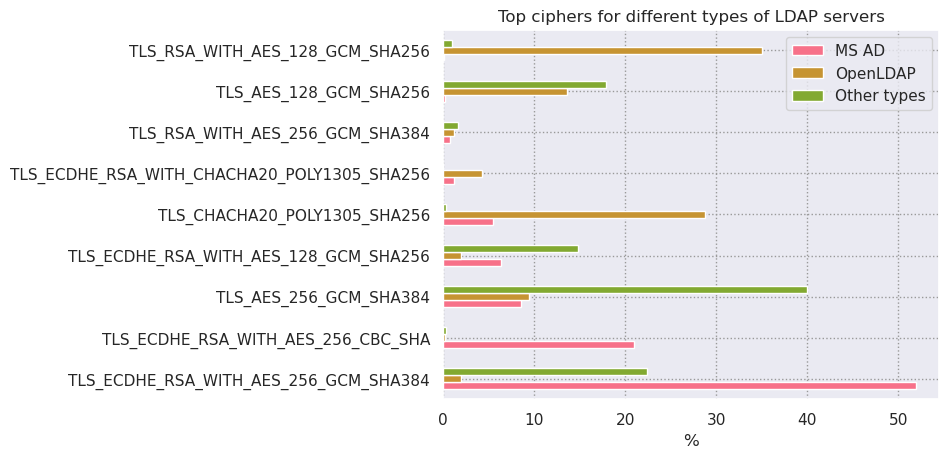

In [836]:
ax = ldap_type_cipher_pdf.plot(
    x="tls_cipher",
    y=["Microsoft", "OpenLDAP", "Other types"],
    kind="barh",
    #rot=45,
)

_ = ax.set_title("Top ciphers for different types of LDAP servers")
_ = ax.set_ylabel("")
_ = ax.set_xlabel("%")
_ = ax.minorticks_on()
_ = ax.legend(["MS AD", "OpenLDAP", "Other types"])
plt.savefig(f"output/top_ciphers_ldap_servers.pdf", format="pdf", bbox_inches="tight")

Using RSA for key exchange and authentication

In [840]:
rsa_key_exch_auth = ["9c", "9d"]
goscanner_tls_df.filter(
    psf.col("cipher").isin(rsa_key_exch_auth)
).dropDuplicates(["ipv4"]).groupBy("pubkey_bit_size").count().sort("pubkey_bit_size", ascending=True
).withColumn(
    "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
).show()

+---------------+-----+-------+
|pubkey_bit_size|count|percent|
+---------------+-----+-------+
|           1024| 5208|   52.8|
|           2048| 4417|   44.8|
|           3072|   23|    0.2|
|           4096|  210|    2.1|
|           8192|    2|    0.0|
+---------------+-----+-------+



Using RSA for authentication

In [841]:
rsa_auth = ["c030", "c014", "c02f", "cca8"]
goscanner_tls_df.filter(
    psf.col("cipher").isin(rsa_auth)
).dropDuplicates(["ipv4"]).groupBy("pubkey_bit_size").count().sort("pubkey_bit_size", ascending=True
).withColumn(
    "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
).show()

+---------------+-----+-------+
|pubkey_bit_size|count|percent|
+---------------+-----+-------+
|           NULL|   91|    0.5|
|            512|   16|    0.1|
|           1024| 1180|    6.5|
|           2048|15248|   84.3|
|           2432|    7|    0.0|
|           3072|  336|    1.9|
|           3076|    2|    0.0|
|           4096| 1208|    6.7|
|           8192|    4|    0.0|
|          16384|    1|    0.0|
+---------------+-----+-------+



#### Correlate hosting with TLS

Cloud providers that uses TLSv 1.0 and 1.1

In [802]:
hosting_old_tls_df = goscanner_tls_df.join(ips_df,
                on=["id", "ipv4", "port", "date"],
                how="inner"
).filter(
    (psf.col("protocol") == "769")
    | (psf.col("protocol") == "770")
).filter(psf.col("cloud_provider").isNotNull()
).dropDuplicates(["ipv4"]).groupBy("cloud_provider").count(
).sort("count", ascending=False)

hosting_old_tls_df.show(truncate=False)
print(hosting_old_tls_df.count())
# sum:
with_old_tlsv = hosting_old_tls_df.agg(psf.sum("count")).collect()[0][0]
all_tlsv = goscanner_tls_df.select("ipv4").distinct().count()
print(f"{round(with_old_tlsv / all_tlsv * 100, 1)}% out of the TLS dataset ({all_tlsv}) uses deprecated TLS versions.")


+------------------------------------------------+-----+
|cloud_provider                                  |count|
+------------------------------------------------+-----+
|Unknown                                         |1271 |
|Sewan SAS                                       |27   |
|Wholesale Internet Inc.                         |20   |
|AWS                                             |17   |
|Hetzner Online GmbH                             |14   |
|Azure                                           |11   |
|Secured Servers LLC                             |10   |
|OVH SAS                                         |9    |
|DGN Deutsches Gesundheitsnetz Service GmbH      |9    |
|Aliyun Computing Co. Ltd                        |9    |
|CTS Computers and Telecommunications Systems SAS|8    |
|Wieske S Crew GmbH                              |7    |
|InfoCert S.p.A.                                 |7    |
|Strato AG                                       |7    |
|Level 3 Communications Inc.   

Then, we go to check ciphersuites...

In [1070]:
cloud_cipher_pdf = ips_df.filter(
    psf.col("cipher") != "0"
).withColumn(
    "cloud_provider",
        psf.when(psf.lower(psf.col("cloud_provider")).contains("hetzner"), "Hetzner")
        .when(psf.lower(psf.col("cloud_provider")).contains("aws"), "Amazon")
        .when(psf.lower(psf.col("cloud_provider")).contains("amazon"), "Amazon")
        .when(psf.lower(psf.col("cloud_provider")).contains("azure"), "Microsoft")
        .when(psf.lower(psf.col("cloud_provider")).contains("google"), "Google")
        .otherwise(psf.col("cloud_provider"))
).groupBy("cipher", "cloud_provider").count().sort("count", ascending=False
).withColumn(
    "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
).withColumn(
    "cipher", cipher_to_description_udf(psf.col("cipher"))
).toPandas()

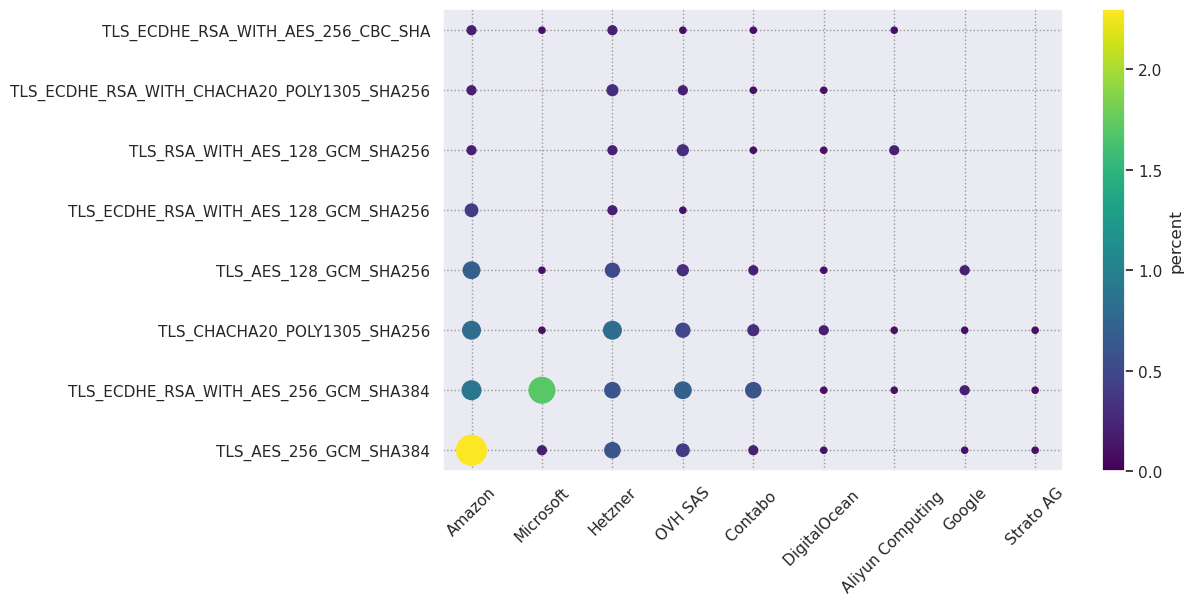

In [1071]:
named_top_ciphers = [cipher_to_description(cipher) for cipher in top_ciphers]
named_top_ciphers.remove("TLS_RSA_WITH_AES_256_GCM_SHA384")  # almost 0%
top_companies = cloud_cipher_pdf.groupby("cloud_provider").size().reset_index(name="count").sort_values(by="count", ascending=False).head(10)["cloud_provider"].to_list()
top_companies.remove("Unknown")
filtered_cloud_cipher_pdf = cloud_cipher_pdf[
    (cloud_cipher_pdf["cipher"].isin(named_top_ciphers))
    & (cloud_cipher_pdf["cloud_provider"].isin(top_companies))
]
filtered_cloud_cipher_pdf.loc[:, "cloud_provider"] = filtered_cloud_cipher_pdf["cloud_provider"].str.replace("GmbH", "")
filtered_cloud_cipher_pdf.loc[:, "cloud_provider"] = filtered_cloud_cipher_pdf["cloud_provider"].str.replace("Co. Ltd", "")
filtered_cloud_cipher_pdf.loc[:, "cloud_provider"] = filtered_cloud_cipher_pdf["cloud_provider"].str.replace("LLC", "")

# Assign numerical values to cipher suites and company names
company_mapping = {name: i for i, name in enumerate(filtered_cloud_cipher_pdf['cloud_provider'].unique())}
cipher_mapping = {suite: i for i, suite in enumerate(filtered_cloud_cipher_pdf['cipher'].unique())}
#filtered_cloud_cipher_pdf.loc[:, 'cloud_provider_id'] = filtered_cloud_cipher_pdf['cloud_provider'].map(company_mapping)
#filtered_cloud_cipher_pdf.loc[:, 'cipher_id'] = filtered_cloud_cipher_pdf['cipher'].map(cipher_mapping)

# Normalize percentages for color mapping
norm = plt.Normalize(filtered_cloud_cipher_pdf['percent'].min(), filtered_cloud_cipher_pdf['percent'].max())

plt.figure(figsize=(10, 6))
ax = plt.scatter(filtered_cloud_cipher_pdf["cloud_provider"],
                 filtered_cloud_cipher_pdf["cipher"],
                 s=filtered_cloud_cipher_pdf["percent"]*200,
                 #c=colors,
                 c=filtered_cloud_cipher_pdf['percent'],
                 alpha=1.,
                 norm=norm,
                 cmap=plt.cm.viridis)

_ = plt.xticks(#ticks=range(len(company_mapping)),
               #labels=filtered_cloud_cipher_pdf['cloud_provider'].unique(),
               rotation=45)  # Rotate labels
cbar = plt.colorbar(ax)
cbar.set_label('percent')
plt.show()
ax.figure.savefig(f"output/cloud_cipher.pdf", format="pdf", bbox_inches="tight")

why so small percentage? - far too many different operators...

In [1073]:
print(filtered_cloud_cipher_pdf["count"].sum(),
      cloud_cipher_pdf[cloud_cipher_pdf["cloud_provider"] != "Unknown"]["count"].sum())
print(len(cloud_cipher_pdf["cloud_provider"].unique()),
      len(cloud_cipher_pdf))

print(filtered_cloud_cipher_pdf[filtered_cloud_cipher_pdf["cloud_provider"] == "Amazon"]["count"].sum())
display(ips_pdf.drop_duplicates(subset=["ip"]).groupby("cloud_provider").size().reset_index(name="count").sort_values(by="count", ascending=False).head(10))
display(filtered_cloud_cipher_pdf[filtered_cloud_cipher_pdf["cloud_provider"] == "Amazon"])

14518 36338
3535 5926
4532


,cloud_provider,count
4381,Unknown,46965
108,AWS,4398
3063,OVH SAS,3445
1818,Hetzner Online GmbH,2759
396,Azure,2164
928,Contabo GmbH,1818
1214,DigitalOcean LLC,840
218,Aliyun Computing Co. Ltd,807
1714,Google LLC,578
4004,Strato AG,520


,cipher,cloud_provider,count,percent
5,TLS_AES_256_GCM_SHA384,Amazon,1862,2.3
11,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,Amazon,731,0.9
14,TLS_CHACHA20_POLY1305_SHA256,Amazon,619,0.8
16,TLS_AES_128_GCM_SHA256,Amazon,564,0.7
24,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,Amazon,298,0.4
37,TLS_RSA_WITH_AES_128_GCM_SHA256,Amazon,178,0.2
45,TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA,Amazon,141,0.2
46,TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256,Amazon,139,0.2


How non-cloud providers fare?

In [1010]:
unknown_cloud_ciphers_pdf = ips_df.filter(
    (psf.col("cloud_provider") == "Unknown")
    & (psf.col("cipher") != "0")
).dropDuplicates(["ipv4"]
).groupBy("cipher").count().sort("count", ascending=False
).withColumn(
    "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
).withColumn(
    "cipher", cipher_to_description_udf(psf.col("cipher"))
).toPandas()

In [1011]:
totalcnt = unknown_cloud_ciphers_pdf["count"].sum()
totalpct = unknown_cloud_ciphers_pdf["percent"].sum()
unknown_cloud_ciphers_pdf.iloc[-1] = ["Total", totalcnt, totalpct]
unknown_cloud_ciphers_pdf.index = unknown_cloud_ciphers_pdf.index + 1  # shifting index
unknown_cloud_ciphers_pdf.sort_index(inplace=True)
display(unknown_cloud_ciphers_pdf)
print(unknown_cloud_ciphers_pdf.drop(columns="count").to_latex(index=False, formatters={"percent": "{:.1f}".format}))

,cipher,count,percent
1,TLS_RSA_WITH_AES_128_GCM_SHA256,6942,24.6
2,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,5229,18.5
3,TLS_CHACHA20_POLY1305_SHA256,4607,16.3
4,TLS_AES_256_GCM_SHA384,3992,14.1
5,TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA,2655,9.4
6,TLS_AES_128_GCM_SHA256,1325,4.7
7,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,1253,4.4
8,TLS_RSA_WITH_AES_128_CBC_SHA,912,3.2
9,TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256,486,1.7
10,TLS_RSA_WITH_AES_256_GCM_SHA384,333,1.2


\begin{tabular}{lr}
\toprule
cipher & percent \\
\midrule
TLS_RSA_WITH_AES_128_GCM_SHA256 & 24.6 \\
TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384 & 18.5 \\
TLS_CHACHA20_POLY1305_SHA256 & 16.3 \\
TLS_AES_256_GCM_SHA384 & 14.1 \\
TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA & 9.4 \\
TLS_AES_128_GCM_SHA256 & 4.7 \\
TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256 & 4.4 \\
TLS_RSA_WITH_AES_128_CBC_SHA & 3.2 \\
TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256 & 1.7 \\
TLS_RSA_WITH_AES_256_GCM_SHA384 & 1.2 \\
TLS_RSA_WITH_AES_256_CBC_SHA & 0.6 \\
TLS_RSA_WITH_3DES_EDE_CBC_SHA & 0.5 \\
TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA & 0.5 \\
TLS_ECDHE_ECDSA_WITH_CHACHA20_POLY1305_SHA256 & 0.2 \\
TLS_ECDHE_ECDSA_WITH_AES_256_GCM_SHA384 & 0.1 \\
Total & 100.0 \\
\bottomrule
\end{tabular}



In [1075]:
len(unknown_cloud_ciphers_pdf)

16

In [1082]:
ips_df.withColumn(
    "cipher", cipher_to_description_udf(psf.col("cipher"))
).filter(
    psf.col("cipher") == "TLS_RSA_WITH_3DES_EDE_CBC_SHA"
).dropDuplicates(["ipv4"]).groupBy("cloud_provider").count().sort("count", ascending=False).show(10, truncate=False)

+---------------------------------------------+-----+
|cloud_provider                               |count|
+---------------------------------------------+-----+
|Unknown                                      |150  |
|FidoNet Registration Services Ltd            |3    |
|Hetzner Online GmbH                          |2    |
|OOO Telecom TZ                               |1    |
|Syringa Networks LLC                         |1    |
|Beijing Teletron Telecom Engineering Co. Ltd.|1    |
|Sewan SAS                                    |1    |
|Leaseweb Netherlands B.V.                    |1    |
|AWS                                          |1    |
|Destiny N.V                                  |1    |
+---------------------------------------------+-----+
only showing top 10 rows



In [1085]:
goscanner_tls_df.join(ldap_fp_df,
                on=["id", "ipv4", "port", "date"],
                how="inner"
).withColumn(
    "cipher", cipher_to_description_udf(psf.col("cipher"))
).filter(
    psf.col("cipher") == "TLS_RSA_WITH_3DES_EDE_CBC_SHA"
).dropDuplicates(["ipv4"]).groupBy("server_name").count(
).withColumn(
    "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
).sort("count", ascending=False).show(truncate=False)

+------------------------------------------------------------+-----+-------+
|server_name                                                 |count|percent|
+------------------------------------------------------------+-----+-------+
|Microsoft Active Directory Controller on Windows Server 2003|90   |50.6   |
|Microsoft Active Directory Controller on Windows Server 2000|63   |35.4   |
|NULL                                                        |25   |14.0   |
+------------------------------------------------------------+-----+-------+



#### Correlate invalid chains and type of LDAP servers

In [1166]:
openldap_chain_error_pdf = goscanner_tls_df.join(ldap_fp_df,
                on=["id", "ipv4", "port", "date"],
                how="inner"
).filter(
    psf.lower(psf.col("server_name")) == "openldap"
).dropDuplicates(["ipv4"]).groupBy("chain_error").count().withColumn(
    "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
).sort("count", ascending=False).toPandas()

windows_chain_error_pdf = goscanner_tls_df.join(ldap_fp_df,
                on=["id", "ipv4", "port", "date"],
                how="inner"
).filter(
    psf.lower(psf.col("server_name")).contains("windows")
).dropDuplicates(["ipv4"]).groupBy("chain_error").count().withColumn(
    "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
).sort("count", ascending=False).toPandas()

others_chain_error_pdf = goscanner_tls_df.join(ldap_fp_df,
                on=["id", "ipv4", "port", "date"],
                how="inner"
).filter(
    ~((psf.lower(psf.col("server_name")).contains("windows"))
    | (psf.lower(psf.col("server_name")) == "openldap"))
).dropDuplicates(["ipv4"]).groupBy("chain_error").count().withColumn(
    "percent", psf.round(psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy()), 1)
).sort("count", ascending=False).toPandas()

In [1179]:
total = others_chain_error_pdf["count"].sum() + windows_chain_error_pdf["count"].sum() + openldap_chain_error_pdf["count"].sum()
pd.DataFrame(
    {
        "Server name": ["Total", "OpenLDAP", "Windows (w/ or w/o AD)", "Other types"],
        "Valid chains": [
            total,
            openldap_chain_error_pdf[openldap_chain_error_pdf["chain_error"] == SHORT8]["percent"].sum(),
            windows_chain_error_pdf[windows_chain_error_pdf["chain_error"] == SHORT8]["percent"].sum(),
            others_chain_error_pdf[others_chain_error_pdf["chain_error"] == SHORT8]["percent"].sum()
            ],
    },
)

,Server name,Valid chains
0,Total,40867.0
1,OpenLDAP,42.7
2,Windows (w/ or w/o AD),13.1
3,Other types,44.6


#### Correlate invalid chains and hosting

In [1165]:
print(top_companies)

['Hetzner', 'Amazon', 'OVH SAS', 'DigitalOcean LLC', 'Microsoft', 'Contabo GmbH', 'Aliyun Computing Co. Ltd', 'Strato AG', 'Google']


### TLS connection analysis

In [357]:
def process_tls(df, dataset: str, save_to_file=True):
    df.persist()

    df = df.withColumn("tls_version", tls_version_udf(psf.col("protocol")))
    df = df.withColumn("tls_cipher", cipher_to_description_udf(psf.col("cipher")))

    print("Processing TLS versions")
    tls_versions_df = df.filter((psf.col("tls_version").isNotNull()) & (psf.col("tls_version") != "")).groupBy("tls_version").count()
    tls_version_pdf = tls_versions_df.coalesce(1).pandas_api().sort_values("tls_version", ascending=False)
    total = tls_version_pdf["count"].sum()
    tls_version_pdf["percentage"] = tls_version_pdf["count"] / total * 100

    print("Processing Ciphersuites")
    ciphers_df = df.filter((psf.col("tls_cipher").isNotNull()) & (psf.col("tls_cipher") != "")).groupBy("tls_cipher").count()
    ciphers_pdf = ciphers_df.coalesce(1).pandas_api().sort_values("count", ascending=False)
    #aggr_ciphers_pdf = ciphers_pdf.groupby("tls_cipher").sum().reset_index().sort_values("count", ascending=False)
    total = ciphers_pdf["count"].sum()
    ciphers_pdf["percentage"] = ciphers_pdf["count"] / total * 100

    print("Processing Signature algorithms")
    tls_sign_algo_df = df.filter((psf.col("tls_signature_algorithm").isNotNull()) & (psf.col("tls_signature_algorithm") != "")).groupBy("tls_signature_algorithm").count()
    tls_sign_algo_pdf = tls_sign_algo_df.coalesce(1).pandas_api().sort_values("count", ascending=False)
    #aggr_tls_sign_algo_pdf = tls_sign_algo_pdf.groupby("tls_signature_algorithm").sum().reset_index().sort_values("count", ascending=False)
    total = tls_sign_algo_pdf["count"].sum()
    tls_sign_algo_pdf["percentage"] = tls_sign_algo_pdf["count"] / total * 100

    if save_to_file:
        tls_sign_algo_pdf.to_csv(f"../dataset/processing/{dataset}_tls_sign_algo", index=False)
        tls_version_pdf.to_csv(f"../dataset/processing/{dataset}_tls_version", index=False)
        ciphers_pdf.to_csv(f"../dataset/processing/{dataset}_all_ciphers", index=False)

    if False:
        # unused rfc recommendation code...
        tls_df = df.filter(psf.col("pubkey_bit_size").isNotNull()) \
                   .filter((psf.col("tls_cipher").isNotNull()) & (psf.col("tls_cipher") != "")) \
                   .filter((psf.col("tls_version").isNotNull()) & (psf.col("tls_version") != "")) \
                   .groupBy("tls_cipher", "tls_version", "pubkey_bit_size", "date").count()
        tls_pdf = tls_df.toPandas().to_csv(f"../dataset/processing/{dataset}_tls.csv", index=False)

    df.unpersist()
    return tls_version_pdf, ciphers_pdf, tls_sign_algo_pdf

In [359]:
tlsv_starttls_only_pdf, cipher_starttls_only_pdf, sign_starttls_only_pdf = process_tls(starttls_only_df, "starttls", False)
tlsv_ldaps_only_pdf, cipher_ldaps_only_pdf, sign_ldaps_only_pdf = process_tls(ldaps_only_df, "ldaps", False)
tlsv_inter_hosts_pdf, cipher_inter_hosts_pdf, sign_inter_hosts_pdf = process_tls(inter_hosts_df, "intersection", False)

Processing TLS versions
Processing Ciphersuites
Processing Signature algorithms
Processing TLS versions
Processing Ciphersuites
Processing Signature algorithms
Processing TLS versions
Processing Ciphersuites
Processing Signature algorithms


In [362]:
print("StartTLS only")
display(tlsv_starttls_only_pdf)
print("LDAPS only")
display(tlsv_ldaps_only_pdf)
print("Intersection")
display(tlsv_inter_hosts_pdf)

StartTLS only


,tls_version,count,percentage
1,TLSv1.3,6780,42.593291
2,TLSv1.2,8389,52.701344
3,TLSv1.1,19,0.119362
0,TLSv1.0,730,4.586003


LDAPS only


,tls_version,count,percentage
1,TLSv1.3,4701,31.709949
2,TLSv1.2,9577,64.600337
3,TLSv1.1,113,0.762226
0,TLSv1.0,434,2.927487


Intersection


,tls_version,count,percentage
1,TLSv1.3,7609,34.390960
2,TLSv1.2,13754,62.164972
3,TLSv1.1,36,0.162712
0,TLSv1.0,726,3.281356


In [363]:
print("StartTLS only")
display(cipher_starttls_only_pdf)
print("LDAPS only")
display(cipher_ldaps_only_pdf)
print("Intersection")
display(cipher_inter_hosts_pdf)

StartTLS only


,tls_cipher,count,percentage
5,TLS_RSA_WITH_AES_128_GCM_SHA256,4849,30.462370
13,TLS_CHACHA20_POLY1305_SHA256,4512,28.345270
8,TLS_AES_128_GCM_SHA256,1767,11.100641
15,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,1716,10.780249
3,TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA,958,6.018344
12,TLS_RSA_WITH_AES_128_CBC_SHA,669,4.202789
11,TLS_AES_256_GCM_SHA384,501,3.147380
7,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,351,2.205051
1,TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256,292,1.834401
4,TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA,95,0.596809


LDAPS only


,tls_cipher,count,percentage
15,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,4070,27.453626
11,TLS_AES_256_GCM_SHA384,2373,16.006745
7,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,2111,14.239460
13,TLS_CHACHA20_POLY1305_SHA256,1747,11.784148
3,TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA,1655,11.163575
5,TLS_RSA_WITH_AES_128_GCM_SHA256,821,5.537943
1,TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256,676,4.559865
8,TLS_AES_128_GCM_SHA256,581,3.919056
12,TLS_RSA_WITH_AES_128_CBC_SHA,312,2.104553
14,TLS_RSA_WITH_AES_256_CBC_SHA,156,1.052277


Intersection


,tls_cipher,count,percentage
12,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,4901,22.151412
5,TLS_RSA_WITH_AES_128_GCM_SHA256,4722,21.342373
9,TLS_AES_256_GCM_SHA384,3911,17.676836
11,TLS_CHACHA20_POLY1305_SHA256,2968,13.414689
3,TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA,1757,7.941243
6,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,925,4.180791
7,TLS_AES_128_GCM_SHA256,730,3.299435
1,TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256,703,3.177401
10,TLS_RSA_WITH_AES_128_CBC_SHA,662,2.992090
0,TLS_RSA_WITH_AES_256_GCM_SHA384,349,1.577401


In [364]:
print("StartTLS only")
display(sign_starttls_only_pdf)
print("LDAPS only")
display(sign_ldaps_only_pdf)
print("Intersection")
display(sign_inter_hosts_pdf)

StartTLS only


,tls_signature_algorithm,count,percentage
0,sha256WithRSAEncryption,12660,79.537601
1,sha1WithRSAEncryption,2610,16.397562
2,sha512WithRSAEncryption,205,1.287931
3,sha384WithRSAEncryption,153,0.961236
5,ecdsa-with-SHA384,153,0.961236
6,md5WithRSAEncryption,87,0.546585
4,ecdsa-with-SHA256,45,0.282717
7,Unknown OID,3,0.018848
8,RSASSA-PSS,1,0.006283


LDAPS only


,tls_signature_algorithm,count,percentage
0,sha256WithRSAEncryption,12355,84.438218
1,sha1WithRSAEncryption,1711,11.693548
3,sha384WithRSAEncryption,262,1.790596
2,sha512WithRSAEncryption,174,1.189174
4,ecdsa-with-SHA256,45,0.307545
7,ecdsa-with-SHA384,35,0.239202
9,md5WithRSAEncryption,32,0.218699
5,Unknown OID,8,0.054675
8,RSASSA-PSS,8,0.054675
6,ecdsa-with-SHA512,2,0.013669


Intersection


,tls_signature_algorithm,count,percentage
0,sha256WithRSAEncryption,16015,72.387453
1,sha1WithRSAEncryption,5382,24.326523
3,sha384WithRSAEncryption,321,1.450913
2,sha512WithRSAEncryption,158,0.714157
5,ecdsa-with-SHA384,132,0.596637
6,md5WithRSAEncryption,63,0.284759
4,ecdsa-with-SHA256,38,0.171759
9,RSASSA-PSS,7,0.031640
7,Unknown OID,6,0.027120
8,ecdsa-with-SHA512,1,0.004520


Old table

In [ ]:
print("Processing Censys CUIDS")
process_tls(censys_df, "censys")

print("Processing GoScanner")
process_tls(goscanner_df, "goscanner")

Processing Censys CUIDS
Processing TLS versions


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Processing Self-signed certificates


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Processing GoScanner
Processing TLS versions


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Processing Self-signed certificates


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [ ]:
censys_aggr_tls_version_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_tls_version/*csv")])
print("Censys")
display(censys_aggr_tls_version_pdf)
print("GoScanner")
goscanner_aggr_tls_version_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_tls_version/*csv")])
display(goscanner_aggr_tls_version_pdf)

Censys


,tls_version,count,percentage
0,TLSv1_3,39162,29.066591
1,TLSv1_2,88980,66.042217
2,TLSv1_1,682,0.506190
3,TLSv1_0,5908,4.385001


GoScanner


,tls_version,count,percentage
0,TLSv1.3,121559,35.959307
1,TLSv1.2,203679,60.251859
2,TLSv1.1,900,0.266236
3,TLSv1.0,11908,3.522598


In [ ]:
print("Censys")
censys_aggr_ciphers_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_all_ciphers/*csv")])
display(censys_aggr_ciphers_pdf.sort_values("tls_cipher", ascending=False))

print("GoScanner")
goscanner_aggr_ciphers_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_all_ciphers/*csv")])
display(goscanner_aggr_ciphers_pdf.sort_values("tls_cipher", ascending=False))

Censys


,tls_cipher,count,percentage
9,TLS_RSA_WITH_AES_256_GCM_SHA384,2626,1.949054
12,TLS_RSA_WITH_AES_256_CBC_SHA,832,0.617522
2,TLS_RSA_WITH_AES_128_GCM_SHA256,18658,13.848232
7,TLS_RSA_WITH_AES_128_CBC_SHA,5028,3.731853
11,TLS_RSA_WITH_3DES_EDE_CBC_SHA,883,0.655375
6,TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256,5904,4.382032
0,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,32555,24.162782
4,TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA,15440,11.459787
5,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,12022,8.922899
10,TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA,974,0.722917


GoScanner


,tls_cipher,count,percentage
9,TLS_RSA_WITH_AES_256_GCM_SHA384,3927,1.161676
13,TLS_RSA_WITH_AES_256_CBC_SHA,1323,0.391367
0,TLS_RSA_WITH_AES_128_GCM_SHA256,69831,20.657248
7,TLS_RSA_WITH_AES_128_CBC_SHA,10586,3.131526
12,TLS_RSA_WITH_3DES_EDE_CBC_SHA,1388,0.410595
8,TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256,10431,3.085675
1,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,69222,20.477095
4,TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA,27055,8.003349
5,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,18461,5.461091
10,TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA,1860,0.550221


In [ ]:
# https://owasp.org/www-chapter-london/assets/slides/OWASPLondon20180125_TLSv1.3_Andy_Brodie.pdf
# TLSv1.3:
# key exchange: ECDHE, DHE, PSK and, PSK-DHE (PSK for resumption)
# authentication (digital signature - uses X.509 cert): RSA, EdDSA or ECDSA. (Rivest-Shamir-Addleman, Edwards-curve Digital Signature Algorithm, Elliptic Curve Digital Signature Algorithm)
# See also https://datatracker.ietf.org/doc/html/rfc8446#section-1 for authentication
cipher_mapping = {
    # 'cipher_name' : ('key_exchange', 'authentication', 'encryption', 'hash', 'weak')
    'TLS_CHACHA20_POLY1305_SHA256': ('(EC)DHE/PSK', 'RSA/ECDSA/EdDSA', 'CHACHA20_POLY1305', 'SHA256', False),
    'TLS_AES_256_GCM_SHA384': ('(EC)DHE/PSK','RSA/ECDSA/EdDSA','AES_256_GCM','SHA384', False),
    'TLS_AES_128_GCM_SHA256': ('(EC)DHE/PSK','RSA/ECDSA/EdDSA','AES_128_GCM','SHA256', False),

    'TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256': ('ECDHE','RSA','CHACHA20_POLY1305','SHA256', False),
    'TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256': ('ECDHE','RSA','AES_128_GCM','SHA256', False),
    'TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384': ('ECDHE','RSA','AES_256_GCM','SHA384', False),
    'TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256': ('ECDHE','ECDSA','AES_128_GCM','SHA256', False),
    'TLS_ECDHE_ECDSA_WITH_AES_256_GCM_SHA384': ('ECDHE','ECDSA','AES_256_GCM','SHA384', False),
    'TLS_ECDHE_ECDSA_WITH_CHACHA20_POLY1305_SHA256': ('ECDHE','ECDSA','CHACHA20_POLY1305','SHA256', False),

    'TLS_ECDHE_ECDSA_WITH_AES_128_CBC_SHA': ('ECDHE','ECDSA','AES_128_CBC','SHA', True),
    'TLS_ECDHE_ECDSA_WITH_AES_256_CBC_SHA': ('ECDHE','ECDSA','AES_256_CBC','SHA', True),
    'TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA': ('ECDHE','RSA','AES_256_CBC','SHA', True),
    'TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA': ('ECDHE','RSA','AES_128_CBC','SHA', True),
    'TLS_ECDHE_RSA_WITH_3DES_EDE_CBC_SHA': ('ECDHE','RSA','3DES_EDE_CBC','SHA', True),
    'TLS_RSA_WITH_AES_128_GCM_SHA256': ('RSA','RSA','AES_128_GCM','SHA256', True),
    'TLS_RSA_WITH_AES_256_GCM_SHA384': ('RSA','RSA','AES_256_GCM','SHA384', True),
    'TLS_RSA_WITH_AES_256_CBC_SHA': ('RSA','RSA','AES_256_CBC','SHA', True),
    'TLS_RSA_WITH_AES_128_CBC_SHA': ('RSA','RSA','AES_128_CBC','SHA', True),
    'TLS_RSA_WITH_3DES_EDE_CBC_SHA': ('RSA','RSA','3DES_EDE_CBC','SHA', True),
    # Add more mappings for other non-standard cipher strings if needed
}

def parse_tls_cipher(pdf):
    cipher = pdf['tls_cipher']
    try:
        tls_key_exchange, tls_authentication, tls_encryption, tls_hash, tls_weak = cipher_mapping[cipher]
    except KeyError:
        print(f"Unknown cipher: {cipher}")
        raise
    pdf['cipher_key_exchange'] = tls_key_exchange
    pdf['cipher_authentication'] = tls_authentication
    pdf['cipher_encryption'] = tls_encryption
    pdf['cipher_hash'] = tls_hash
    pdf['cipher_weak'] = tls_weak
    return pdf

In [ ]:
def show_cipher_ks(aggr_ciphers_pdf):
    aggr_ciphers_pdf = aggr_ciphers_pdf.apply(parse_tls_cipher, axis=1)
    encryption_pdf = aggr_ciphers_pdf.groupby("cipher_encryption").sum().reset_index().sort_values("count", ascending=False)[["cipher_encryption", "count", "percentage"]]
    display(encryption_pdf)
    key_exchange_pdf = aggr_ciphers_pdf.groupby("cipher_key_exchange").sum().reset_index().sort_values("count", ascending=False)[["cipher_key_exchange", "count", "percentage"]]
    display(key_exchange_pdf)

# TODO call this function with different aggr_ciphers_pdf (censys and goscanner)
print("Censys")
show_cipher_ks(censys_aggr_ciphers_pdf)

print("GoScanner")
show_cipher_ks(goscanner_aggr_ciphers_pdf)

Censys


,cipher_encryption,count,percentage
4,AES_256_GCM,54911,40.755722
2,AES_128_GCM,34247,25.418609
5,CHACHA20_POLY1305,22417,16.638215
3,AES_256_CBC,16272,12.077309
1,AES_128_CBC,6002,4.454769
0,3DES_EDE_CBC,883,0.655375


,cipher_key_exchange,count,percentage
1,ECDHE,67543,50.131372
0,(EC)DHE/PSK,39162,29.066591
2,RSA,28027,20.802037


GoScanner


,cipher_encryption,count,percentage
4,AES_256_GCM,121081,35.817906
2,AES_128_GCM,106267,31.435663
5,CHACHA20_POLY1305,68486,20.259373
3,AES_256_CBC,28378,8.394716
1,AES_128_CBC,12446,3.681747
0,3DES_EDE_CBC,1388,0.410595


,cipher_key_exchange,count,percentage
1,ECDHE,129432,38.288280
0,(EC)DHE/PSK,121559,35.959307
2,RSA,87055,25.752412


In [ ]:
# SHA256-RSAPSS, RSASSA-PSS:
# https://www.cryptsoft.com/pkcs11doc/v230/group__SEC__11__1__17__PKCS____1__RSA__PSS__SIGNATURE__WITH__SHA__1____SHA__256____SHA__384__OR__SHA__512.html
# https://crypto.stackexchange.com/questions/58680/whats-the-difference-between-rsa-pss-pss-and-rsa-pss-rsae-schemes
# https://crypto.stackexchange.com/questions/48407/should-i-be-using-pkcs1-v1-5-or-pss-for-rsa-signatures
sign_algo_x509_to_censys = {
    "sha256WithRSAEncryption": "SHA256-RSA",
    "sha1WithRSAEncryption": "SHA1-RSA",
    "sha384WithRSAEncryption": "SHA384-RSA",
    "sha512WithRSAEncryption": "SHA512-RSA",
    "ecdsa-with-SHA384": "ECDSA-SHA384",
    "md5WithRSAEncryption": "MD5-RSA",
    "ecdsa-with-SHA256": "ECDSA-SHA256",
    "Unknown OID": "Unknown OID",
    "RSASSA-PSS": "SHA1-RSAPSS",
    "ecdsa-with-SHA512": "ECDSA-SHA512",
    "ecdsa-with-SHA1": "ECDSA-SHA1"
}

In [ ]:
# https://www.alvestrand.no/objectid/submissions/2.16.840.1.101.3.4.3.16.html
# 2.16.840.1.101.3.4.3.16 = SHA-3-512 with RSA Encryption
print("Censys")
censys_aggr_tls_sign_algo_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_tls_sign_algo/*csv")])
display(censys_aggr_tls_sign_algo_pdf)
print("GoScanner")
goscanner_aggr_tls_sign_algo_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_tls_sign_algo/*csv")])
goscanner_aggr_tls_sign_algo_pdf["mapped"] = goscanner_aggr_tls_sign_algo_pdf["tls_signature_algorithm"].map(sign_algo_x509_to_censys)
display(goscanner_aggr_tls_sign_algo_pdf[["mapped", "count", "percentage"]])


Censys


,tls_signature_algorithm,count,percentage
0,SHA256-RSA,103396,76.741977
1,SHA1-RSA,26559,19.712466
2,SHA384-RSA,1901,1.410949
3,SHA512-RSA,1263,0.937417
4,MD5-RSA,736,0.546270
5,ECDSA-SHA384,565,0.419351
6,ECDSA-SHA256,258,0.191491
7,SHA256-RSAPSS,24,0.017813
8,ECDSA-SHA512,20,0.014844
9,2.16.840.1.101.3.4.3.16,5,0.003711


GoScanner


,mapped,count,percentage
0,SHA256-RSA,256858,76.161136
1,SHA1-RSA,68139,20.203940
2,SHA384-RSA,4770,1.414356
3,SHA512-RSA,3140,0.931043
4,ECDSA-SHA384,2108,0.625044
5,MD5-RSA,1132,0.335650
6,ECDSA-SHA256,877,0.260040
7,Unknown OID,106,0.031430
8,SHA1-RSAPSS,99,0.029355
9,ECDSA-SHA512,19,0.005634


In [ ]:
print("Censys")
censys_aggr_tls_self_signed_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_tls_self_signed/*csv")])
display(censys_aggr_tls_self_signed_pdf)
print("GoScanner")
goscanner_aggr_tls_self_signed_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_tls_self_signed/*csv")])
display(goscanner_aggr_tls_self_signed_pdf)

Censys


,tls_signature_self_signed,count,percentage
0,False,104620,77.650447
1,True,30112,22.349553


GoScanner


,tls_signature_self_signed,count,percentage
0,False,229106,67.773617
1,True,108940,32.226383


What are the organizations that are fostering tlsv1.3?

In [ ]:
tlsv3_org_pdf = goscanner_df.filter(psf.col("tls_version") == "TLSv1.3").groupBy("org").count().sort("count", ascending=False).toPandas()

In [ ]:
total = tlsv3_org_pdf["count"].sum()
tlsv3_org_pdf["percentage"] = tlsv3_org_pdf["count"] / total * 100
display(tlsv3_org_pdf.head(10))

,org,count,percentage
0,"Amazon.com, Inc.",10352,8.516029
1,Hetzner Online GmbH,7244,5.959246
2,Iway AG,6028,4.958909
3,OVH SAS,5034,4.141199
4,Contabo GmbH,2180,1.793368
5,Deutsche Telekom AG,2039,1.677375
6,"Chunghwa Telecom Co., Ltd.",1646,1.354075
7,"DigitalOcean, LLC",1624,1.335977
8,netcup GmbH,1395,1.147591
9,"Akamai Technologies, Inc.",1286,1.057922


3400


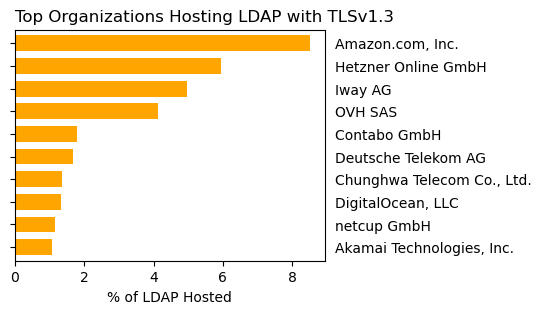

In [ ]:
print(len(tlsv3_org_pdf))
top_10tlsv3_org = tlsv3_org_pdf.head(10)[["org", "percentage"]].set_index("org")

width = 0.7
ax1 = top_10tlsv3_org.plot.barh(width=width, color=['orange'], figsize=(4,3), legend=False)
ax1.invert_yaxis()
ax1.set_title('Top Organizations Hosting LDAP with TLSv1.3', loc='left')
ax1.tick_params(axis='y', labelright=True, labelleft=False)  
ax1.set_xlabel('% of LDAP Hosted')
ax1.set_ylabel(None)
fig = ax1.get_figure()
fig.savefig("output/ldap_tlsv3_org.pdf", dpi=300, bbox_inches='tight')
fig.show()

In [ ]:
def show_total(aggr_tls_sign_algo_pdf, aggr_ciphers_pdf, aggr_tls_self_signed_pdf, aggr_tls_version_pdf):
    # all should match
    s = aggr_tls_sign_algo_pdf["count"].sum()
    c = aggr_ciphers_pdf["count"].sum()
    ss = aggr_tls_self_signed_pdf["count"].sum()
    t = aggr_tls_version_pdf["count"].sum()
    assert s == c == ss == t, f"sign_algo: {s}, ciphers: {c}, self_signed: {ss}, tls: {t}"
    print("Total hosts with TLS: ", aggr_tls_version_pdf["count"].sum())

print("Censys")
show_total(censys_aggr_tls_sign_algo_pdf, censys_aggr_ciphers_pdf, censys_aggr_tls_self_signed_pdf, censys_aggr_tls_version_pdf)
print("GoScanner")
show_total(goscanner_aggr_tls_sign_algo_pdf, goscanner_aggr_ciphers_pdf, goscanner_aggr_tls_self_signed_pdf, goscanner_aggr_tls_version_pdf)

Censys
Total hosts with TLS:  134732
GoScanner


AssertionError: sign_algo: 337256, ciphers: 338046, self_signed: 338046, tls: 338046

#### RFC-9325 recommendation - unused?

In [13]:
def rfc9325_recommendation(cipher, tls_version, public_key_size) -> str:
    # https://datatracker.ietf.org/doc/html/rfc9325#name-general-guidelines
    # about cipher suites:
    # https://utcc.utoronto.ca/~cks/space/blog/tech/SSLCipherNames

    # "SHALL" and "MUST"
    cipher_params = cipher.split("_")
    veredict = "Y"
    must_not = ["NULL", "RC4"]
    if any(item in must_not for item in cipher_params):
        veredict = "N"

    for param in cipher_params:
        try:
            key_size = int(param.rstrip("L"))
            if key_size < 128:  # should not; 112 is must not
                veredict = "N"
        except:
            pass

    if "_DES40_" in cipher:
        veredict = "N"

    # the "SHOULD NOT" also taken into account
    should_not = ["TLS_RSA_WITH_",  # e.g. TLS_RSA_WITH_AES_128_CBC_SHA
                  "TLS_DH_", 
                  "TLS_ECDH_"  # https://doi.org/10.1007/978-3-319-24174-6_21
                 ]  
    if any(i in cipher for i in should_not):
        veredict = "N"

    if tls_version == "TLSv1.2": 
        recommended_v2 = ["TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256",
                          "TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384",
                          "TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256",
                          "TLS_ECDHE_ECDSA_WITH_AES_256_GCM_SHA384"
                         ]
        if cipher in recommended_v2:
            veredict = "Y"

        if "TLS_DHE_" in cipher:
            veredict = "N"

    # TODO this is not sent in the goscanner at the moment
    # _CBC_ should not be used unless encrypt-then-mac is successfully negotiated
    # encrypt_then_mac extension in client hello with extension_type=0x16 and extension_data=<empty>
    # https://datatracker.ietf.org/doc/html/rfc7366

    # use client hello to detect ECDSA that use NIST curve P-256 and X25519 rfc4492#section-5.1
    # -> goscanner sends in its default CH: x25519, secp256r1 (P-256), secp384r1, secp521r1

    # https://www.rfc-editor.org/rfc/rfc8446#section-9.1
    recommended_v3 = ["TLS_AES_128_GCM_SHA256",
                      "TLS_AES_256_GCM_SHA384",
                      "TLS_CHACHA20_POLY1305_SHA256"
                     ]
    if tls_version == "TLSv1.3":
        if cipher in recommended_v3:
            veredict = "Y"

    # TODO key_exchange_size has to be retrieved from the ConnectionState in the Goscanner
    #if "DHE" in cipher and (key_exchange_size is None or key_exchange_size < 2048):
    #    veredict = "N"
    #if "ECDH" in cipher and (key_exchange_size is None or key_exchange_size < 224):
    #    veredict = "N"

    if "TLS_RSA_WITH_" not in cipher and "RSA" in cipher:
        hash_algo = cipher.split("_")[-1]
        recommended_hash = ["SHA256", "SHA384", "SHA512"]
        not_recommended_hash = ["SHA1", "SHA", "MD5"]
        if hash_algo in recommended_hash:
            veredict = "Y"
        elif hash_algo in not_recommended_hash:
            veredict = "N"

        # "When using RSA, servers MUST authenticate using certificates with at
        # least a 2048-bit modulus for the public key" - rfc9325#section-4.5
        if public_key_size is None or public_key_size < 2048:
            veredict = "N"


    #if "truncated_hmac":
    #    # -> goscanner does not send this
    #    veredict = "N"  # in the extended client hello

    return veredict


get_rfc9325_recommendation = psf.udf(rfc9325_recommendation, pst.StringType())

In [14]:
goscanner_df = goscanner_df.withColumn("tls_version", tls_version_udf(psf.col("protocol")))
goscanner_df = goscanner_df.withColumn("tls_cipher", cipher_to_description_udf(psf.col("cipher")))
goscanner_df = goscanner_df.withColumn(
    "rfc9325",
    get_rfc9325_recommendation(psf.col("tls_cipher"),
                               psf.col("tls_version"),
                               psf.col("pubkey_bit_size"))
)

In [15]:
rec_ciphersuites_df = goscanner_df.groupBy("tls_cipher", "rfc9325").count()

In [16]:
rec_ciphersuites_df.filter(psf.col("rfc9325") == "Y").select("tls_cipher").show(truncate=False)

+---------------------------------------------+
|tls_cipher                                   |
+---------------------------------------------+
|TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256  |
|TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384        |
|TLS_AES_128_GCM_SHA256                       |
|TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256        |
|TLS_ECDHE_ECDSA_WITH_CHACHA20_POLY1305_SHA256|
|TLS_CHACHA20_POLY1305_SHA256                 |
|TLS_ECDHE_ECDSA_WITH_AES_256_GCM_SHA384      |
|TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256      |
|TLS_AES_256_GCM_SHA384                       |
+---------------------------------------------+



In [17]:
rec_ciphersuites_df.filter(psf.col("rfc9325") == "N").select("tls_cipher").show(truncate=False)

+-------------------------------------------+
|tls_cipher                                 |
+-------------------------------------------+
|TLS_RSA_WITH_3DES_EDE_CBC_SHA              |
|TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384      |
|TLS_RSA_WITH_AES_128_GCM_SHA256            |
|TLS_RSA_WITH_AES_256_CBC_SHA               |
|TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA         |
|TLS_RSA_WITH_AES_256_GCM_SHA384            |
|TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA         |
|TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256      |
|TLS_RSA_WITH_AES_128_CBC_SHA               |
|TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256|
+-------------------------------------------+



## Unused

The next is too slow...

In [11]:
# pyspark
all_cloud_prefixes = [(ipaddress.ip_network(prefix), prov) for prefix, prov in list(all_cloud_prefixes_pdf[['prefix', 'provider']].itertuples(index=False, name=None))]
def get_cloud_provider_from_ip(ipv4):
    try:
        ip = ipaddress.ip_address(ipv4)
    except ValueError:
        return "Unknown"


    for prefix, provider in all_cloud_prefixes:
        if ip in prefix:
            return provider
    return "Unknown"


cloud_provider_from_ip_udf = psf.udf(get_cloud_provider_from_ip, pst.StringType())
ldap_names_df.withColumn("cloud_provider", cloud_provider_from_ip_udf(psf.col("ip"))).groupBy("cloud_provider").count().show(truncate=False)

In [439]:
# pandas
all_cloud_prefixes = [(ipaddress.ip_network(prefix), prov) for prefix, prov in list(all_cloud_prefixes_pdf[['prefix', 'provider']].itertuples(index=False, name=None))]

def map_ip_to_prefix_name(ip, prefixes_providers):
    ip_obj = ipaddress.ip_address(ip)
    for prefix, provider in prefixes_providers:
        if ip_obj in prefix:
            return provider
    return "Unknown"

ips_pdf = ldap_names_df.select("ip").toPandas()
ips_pdf['network_name'] = ips_pdf['ip'].apply(lambda ip: map_ip_to_prefix_name(ip, all_cloud_prefixes))

KeyboardInterrupt: 

In [233]:
for port, ts in METADATA_PORT_SCANDATE_MAP.items():
    print(port, ts)
    root_dse_df = load_ldap_root_dse(port, ts)
    flat_root_dse_df = flatten_ldap_metadata(root_dse_df)
    flat_root_dse_df.groupBy(psf.col("attribute_name")).count().sort("count", ascending=False).show(150, truncate=False)
    break

636 2024-04-23 00:00:00
+-------------------------------+-----+
|attribute_name                 |count|
+-------------------------------+-----+
|namingContexts                 |28575|
|supportedControl               |28556|
|supportedLDAPVersion           |23383|
|subschemaSubentry              |22693|
|supportedSASLMechanisms        |22252|
|supportedExtension             |21081|
|serverName                     |12225|
|supportedCapabilities          |11557|
|supportedFeatures              |10903|
|dnsHostName                    |10875|
|ldapServiceName                |10763|
|isGlobalCatalogReady           |10763|
|entryDN                        |10512|
|supportedLDAPPolicies          |9935 |
|structuralObjectClass          |9187 |
|configContext                  |9101 |
|vendorName                     |3212 |
|vendorVersion                  |3208 |
|modifiersName                  |2630 |
|creatorsName                   |1423 |
|modifyTimestamp                |1398 |
|createTimestamp

Testing what names I can get from attributes in LDAP server

In [239]:
flat_root_dse_df.filter(psf.col("attribute_name") == "dnsHostName"
                        ).groupBy("attribute_values_list").count().sort("count", ascending=False).show(truncate=False)

+---------------------------------+-----+
|attribute_values_list            |count|
+---------------------------------+-----+
|[pcdnad01.cdnetworks.biz]        |186  |
|[PIDC.PISCHOOL.INT]              |60   |
|[DC01.musterschule.schule.paedml]|30   |
|[WIN-QHE83QTUJ0D.ocassio.local]  |29   |
|[server.linuxmuster.lan]         |25   |
|[tsdc02.dinecollege.edu]         |18   |
|[PIDC.pischool.int]              |12   |
|[server.paedml-linux.lokal]      |12   |
|[MNSplusDC.Schule.mnsplus]       |12   |
|[OWNEROR-4F1ITUK.tele-union.de]  |11   |
|[sap-cloud.gd-cloud.local]       |11   |
|[dc1.newman.wa.edu.au]           |10   |
|[JMI-DC01.janeway.local]         |9    |
|[FRDATWNAUTH1.clasp-infra.com]   |9    |
|[ISSDC01.ISSNET.LOCAL]           |9    |
|[SERVER1.annies.ltd]             |9    |
|[mdc.wbasd.dom]                  |9    |
|[DVRS2.dvr.local]                |9    |
|[srv.COIS.local]                 |8    |
|[ns1.pihosting.ch]               |7    |
+---------------------------------

### LDAP identification

The below code does not yield good results. We then used Rapid7's recog tool

In [163]:
# https://ldap.com/ldap-oid-reference-guide/
ldap_oid_pdf = pd.read_json("ldap_oid_dict.json")
# https://learn.microsoft.com/en-us/windows/win32/adschema/rootdse
#ms_ad_oid_pdf = pd.read_json("ldap_ms_ad.json")
ms_ad_attr = [i.casefold() for i in ["isGlobalCatalogReady"]]
linux_user_mgmt_attr = [i.casefold() for i in [
    "homeDirectory",
    "loginShell",
    "gidNumber",
    "uidNumber"
]]
address_book_attr = [i.casefold() for i in [
    "cn",
    "sn",
    "email",
    "Email",
    "mail",
    "name",
    "givenName",
    "FirstName",
    "LastName",
    "jpegPhoto",
    "street",
    "postalAddress",
    "postalCode",
    "mobile",
    "Mobile",
    "telephoneNumber",
    "homePhone",
]]
address_book_threshold = 6  # out of 11

def decode_oid_rfc(oid):
    # decode with RFC
    # supportedFeatures, supportedControls,
    global ldap_oid_pdf
    #global ms_ad_oid_pdf

    #if ms_ad_oid_pdf.get(oid, None) is not None:
    #    return "Microsoft Active Directory"

    if ldap_oid_pdf.get(oid, None) is None:
        return ""

    return ldap_oid_pdf[oid]["rfc"]


def decode_oid_description(oid):
    # decode with description
    global ldap_oid_pdf

    if ldap_oid_pdf.get(oid, None) is None:
        return ""
    return ldap_oid_pdf[oid]["description"]


def decode_oids(oid_list: list):
    if oid_list is None:
        return []
    return [decode_oid_rfc(oid) for oid in oid_list]


decode_oids_udf = psf.udf(decode_oids, pst.StringType())


def get_server_name_by_attr_values(attr_values: list) -> str:
    # matchingRuleUse https://www.rfc-editor.org/rfc/rfc4512#section-4.1.4 https://www.rfc-editor.org/rfc/rfc4511#section-4.5.1.7.7
    # the filter item evaluates to TRUE if it matches at least one attribute type or subtype in the entry
    if not attr_values:
        return ""
    if any('msexch' in s.casefold() for s in attr_values):
        return "Microsot Exchange"
    return ""


def get_server_name_by_dn(attribute_name: str, attribute_values: list) -> str:
    # dn = vendorName or namingContexts
    if attribute_name == None:
        return ""

    if attribute_name.casefold() == "vendorname" and attribute_values is not None and len(attribute_values) > 0:
        if "samba" in attribute_values[0].casefold():
            return "Samba"
        return attribute_values[0]

    if attribute_name.casefold() in ["namingcontexts", "namingcontext"]:
        return get_server_name_by_attr_values(attribute_values)

    return ""


def get_server_name_by_oid(attribute_name: str, attribute_values: list) -> str:
    if attribute_name == None:
        return ''

    names = []
    if (attribute_name.casefold() == "supportedfeatures" or attribute_name == "supportedcontrols") and attribute_values is not None:
        for oid in attribute_values:
            rfc = decode_oid_rfc(oid)
            if not fnmatch(rfc, "RFC *") and rfc != "" and " " in rfc:
                names.append(rfc)  # must be some server name, not RFC
            if rfc == "RFC 3712":
                names.append("Printer Management")
            if oid in "1.3.6.1.4.1.42.2.27.8." or rfc == "draft-behera-ldap-password-policy":
                names.append("User Password Management")
            if rfc == "RFC 2307" or "rfc2307" in rfc:
                names.append("Network Information Service")
            if "1.2.840.113549.1.9." in oid:
                names.append("Public-key cryptography in LDAP")
            if rfc == "RFC 2739":
                names.append("Calendar Management")

    uniq_names = list(set(names))
    return uniq_names.pop() if uniq_names else ''


def get_server_name_by_attrs(attribute_names_case: list) -> str:
    if attribute_names_case is None or attribute_names_case == []:
        return ""
    attribute_names = [s.casefold() for s in attribute_names_case]

    if any('ibm-' in s for s in attribute_names):
        return "International Business Machines (IBM)"

    if any(s in ms_ad_attr for s in attribute_names):
        return "Microsoft Active Directory"

    matches = count_matching_strings(
        attribute_names, address_book_attr
    )
    if matches > address_book_threshold:
        return "Address Book"

    # https://openldap.org/lists/openldap-technical/201208/msg00054.html
    if check_substring(attribute_names, "samba"):
        return "Samba"

    # Most of the attributes and objectClasses used in the slapd configuration have a prefix of "olc" (OpenLDAP Configuration) in their names.
    # Generally there is a one-to-one correspondence between the attributes and the old-style slapd.conf configuration keywords, using the keyword as the attribute name, with the "olc" prefix attached
    # https://www.openldap.org/doc/admin26/guide.html
    if check_substring(attribute_names, "olc"):
        return "OpenLDAP"

    # https://access.redhat.com/documentation/en-us/red_hat_enterprise_linux/8/html/configuring_and_managing_identity_management/using-ldapmodify-to-manage-idm-users-externally_configuring-and-managing-idm
    if all(
        attr in attribute_names
        for attr in linux_user_mgmt_attr
    ):  # "gecos" , "userPassword"
        return "Linux User Management"

    return ""


def count_matching_strings(target_strings: list, strings: list) -> int:
    count = 0
    for string in strings:
        if string in target_strings:
            count += 1
    return count


def check_substring(target_strings: list, substring: str) -> bool:
    for string in target_strings:
        if substring in string:
            return True
    return False


def get_server_name(dn_names: list, oid_names: list, attr_name: str) -> str:
    name = ""
    if oid_names and not name:
        name = next((element for element in oid_names if element), "")
    if attr_name and not name:
        name = attr_name
    if dn_names and not name:
        name = next((element for element in dn_names if element), "")
    return name


get_server_name_by_oid_udf = psf.udf(get_server_name_by_oid, pst.StringType())
get_server_name_by_attrs_udf = psf.udf(get_server_name_by_attrs, pst.StringType())
get_server_name_by_dn_udf = psf.udf(get_server_name_by_dn, pst.StringType())
get_server_name_udf = psf.udf(get_server_name, pst.StringType())

In [158]:
for port, ts in METADATA_PORT_SCANDATE_MAP.items():
    print(port, ts)
    root_dse_df = load_ldap_root_dse(port, ts)
    flat_root_dse_df = flatten_ldap_metadata(root_dse_df)
    flat_root_dse_df = flat_root_dse_df.withColumn("server_name_by_dn", get_server_name_by_dn_udf(psf.col("attribute_name"), psf.col("attribute_values_list")))
    flat_root_dse_df = flat_root_dse_df.withColumn("server_name_by_OID", get_server_name_by_oid_udf(psf.col("attribute_name"), psf.col("attribute_values_list")))

    grouped_df = flat_root_dse_df.groupBy("ip"
            ).agg(
                psf.collect_set("server_name_by_dn").alias("server_name_by_dns"),
                psf.collect_set("server_name_by_OID").alias("server_name_by_OIDs"),
                psf.collect_set("attribute_name").alias("attribute_names"),
            )

    grouped_df = grouped_df.withColumn("server_name_by_attr", get_server_name_by_attrs_udf(psf.col("attribute_names")))

    #grouped_df.groupBy("server_name_by_dns").count().sort("count", ascending=False).show(10, truncate=False)
    #grouped_df.groupBy("server_name_by_OIDs").count().sort("count", ascending=False).show(10, truncate=False)
    #grouped_df.groupBy("server_name_by_attr").count().sort("count", ascending=False).show(10, truncate=False)

    #print(grouped_df.filter(
    #    (psf.col("server_name_by_dns") == psf.array(psf.lit("")))
    #    & (psf.col("server_name_by_OIDs") == psf.array(psf.lit("")))
    #    & (psf.col("server_name_by_attr") == "")
    #).count())

    grouped_df = grouped_df.withColumn("server_name", get_server_name_udf(psf.col("server_name_by_dns"), psf.col("server_name_by_OIDs"), psf.col("server_name_by_attr")))
    grouped_df.groupBy("server_name").count().withColumn(
        'percent', psf.lit(100)*psf.col('count')/psf.sum('count').over(Window.partitionBy())
    ).sort("percent", ascending=False).show(10, truncate=False)
    # not classified = 16863

    break

636 2024-04-23 00:00:00
+-------------------------------------+-----+-------------------+
|server_name                          |count|percent            |
+-------------------------------------+-----+-------------------+
|                                     |16863|56.31512156024579  |
|Microsoft Active Directory           |10763|35.943761688485175 |
|389 Project                          |1430 |4.775581084691424  |
|Apple                                |401  |1.3391664440288538 |
|NetIQ Corporation                    |117  |0.39072936147475285|
|Oracle Corporation                   |70   |0.23376970344643333|
|ForgeRock AS.                        |52   |0.17365749398877905|
|Apache Software Foundation           |52   |0.17365749398877905|
|International Business Machines (IBM)|47   |0.15695965802831954|
|Ping Identity Directory Server       |33   |0.11020571733903287|
+-------------------------------------+-----+-------------------+
only showing top 10 rows



### Hosts analysis

In [ ]:
def process_hosts(df, dataset: str):
    df.persist()

    print("Processing LDAP hosters")
    # ldap_hoster_pdf = df.select("ipv4", "date").toPandas().value_counts().reset_index()
    ldap_hoster_pdf = df.select("ipv4", "date").groupBy("date").count().coalesce(1).pandas_api()
    ldap_hoster_pdf.to_csv(f"../dataset/processing/{dataset}_date_ldap_hosts")
    #ldap_hoster_pdf.value_counts("date").to_csv(f"../dataset/processing/{dataset}_date_ldap_hosts")

    df.unpersist()

In [ ]:
print("Processing Censys CUIDS")
process_hosts(censys_df, "censys")

print("Processing GoScanner")
process_hosts(goscanner_df, "goscanner")

Processing Censys CUIDS
Processing LDAP hosters


/usr/local/spark/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Processing GoScanner
Processing LDAP hosters


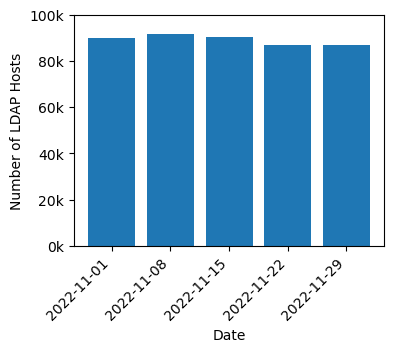

In [ ]:
# UNUSED
aggr_ldap_hoster_pdf = pd.concat([pd.read_csv(filename, parse_dates=True) for filename in glob("../dataset/processing/censys_date_ldap_hosts/*csv")])

fig, ax = plt.subplots(figsize=(4,3))  # Adjust the width and height as desired
ax.bar(aggr_ldap_hoster_pdf['date'], aggr_ldap_hoster_pdf['count'])
ax.set_xlabel('Date')
xlabels = [datetime.fromisoformat(label.get_text()).strftime('%Y-%m-%d') for label in ax.get_xticklabels()]
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, ha='right') 
# change y ticks to show in k
yticks = np.array([int(item.get_text()) for item in ax.get_yticklabels()])
ylabels = [f'{int(item.get_text())/1000:.0f}k' for item in ax.get_yticklabels()]
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
ax.set_ylabel('Number of LDAP Hosts')
fig.savefig("output/ldap_hosts.pdf", dpi=300, bbox_inches='tight')
fig.show()

Taking the average of LDAP hosts of a month of data:

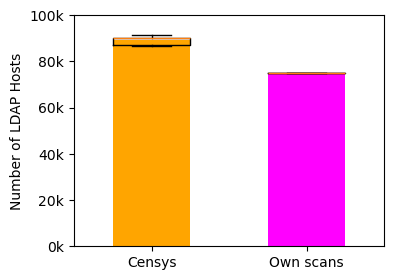

In [ ]:
censys_aggr_ldap_hoster_pdf = pd.concat([pd.read_csv(filename, parse_dates=True) for filename in glob("../dataset/processing/censys_date_ldap_hosts/*csv")])
goscanner_ldap_hoster_pdf = pd.concat([pd.read_csv(filename, parse_dates=True) for filename in glob("../dataset/processing/goscanner_date_ldap_hosts/*csv")]).sort_values("date").iloc[1:]  # removing first line that came from previous snapshot (not a 636-389 pair)
even = goscanner_ldap_hoster_pdf.iloc[1::2]  # port 636
odd = goscanner_ldap_hoster_pdf.iloc[::2]  # port 389
goscanner_aggr_ldap_hoster_pdf = even["count"].to_numpy() + odd["count"].to_numpy()

fig, ax = plt.subplots(figsize=(4,3))  # Adjust the width and height as desired
ax.bar([1, 2], [statistics.mean(censys_aggr_ldap_hoster_pdf['count']), statistics.mean(goscanner_aggr_ldap_hoster_pdf)], color=['orange', 'magenta'], width=0.5)
ax.boxplot([censys_aggr_ldap_hoster_pdf['count'], goscanner_aggr_ldap_hoster_pdf], positions=[1, 2], widths=0.5)
ax.set_xticks([1, 2])
ax.set_xticklabels(["Censys", "Own scans"])
ax.set_ylabel('Number of LDAP Hosts')
#ax.set_title('Average number of LDAP Hosts')
yticks = np.array([int(item.get_text()) for item in ax.get_yticklabels()])
ylabels = [f'{int(item.get_text())/1000:.0f}k' for item in ax.get_yticklabels()]
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
fig.savefig("output/ldap_hosts.pdf", dpi=300, bbox_inches='tight')
fig.show()

### Country & Organizations

In [ ]:
# not required
#censys_df.select("ipv4").toPandas().to_csv("../dataset/censys/processing/censys_ldap_ips.csv", index=False)

In [ ]:
goscanner_df = goscanner_df.withColumn("country", ip_to_country_udf(psf.col("ipv4"), psf.col("date")))
goscanner_df = goscanner_df.withColumn("org", ip_to_org_udf(psf.col("ipv4"), psf.col("date")))

In [ ]:
def country_org_stats(df, dataset):
    df.persist()

    print("Processing Country")
    country_pdf = df.groupBy("country").count().sort(psf.col("count").desc()).pandas_api()
    total = country_pdf["count"].sum()
    country_pdf["percentage"] = country_pdf["count"] / total * 100
    country_pdf.to_csv(f"../dataset/processing/{dataset}_country", index=False)

    print("Processing Org")
    org_pdf = df.groupBy("org").count().sort(psf.col("count").desc()).pandas_api()
    total = org_pdf["count"].sum()
    org_pdf["percentage"] = org_pdf["count"] / total * 100
    org_pdf.to_csv(f"../dataset/processing/{dataset}_org", index=False)

    df.unpersist()

In [ ]:
print("Censys")
country_org_stats(censys_compact_df, "censys")
print("GoScanner")
country_org_stats(goscanner_df, "goscanner")

Censys


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


GoScanner


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Loading the saved data

In [ ]:
censys_country_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_country/*csv")])
censys_org_pdf = pd.concat([pd.read_csv(filename, quotechar='"') for filename in glob("../dataset/processing/censys_org/*csv")])
goscanner_country_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_country/*csv")])
goscanner_org_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_org/*csv")])

In [ ]:
def see_unknown_org_cc(ccpdf, orgpdf):
    # ASN262726 at 20221101 does not give any country nor org name.
    # This ASN seems to be http://www.cortezonline.com.br (see https://www.ditatompel.com/asn/262726), https://bgp.he.net/AS262726
    # Some IPs do no have ASN
    # both cases we classified as Unknown
    aggr_country_pdf = ccpdf.groupby("country").sum().reset_index().sort_values("count", ascending=False)
    display(aggr_country_pdf[aggr_country_pdf["country"] == "Unknown"])

    aggr_org_pdf = orgpdf.groupby("org").sum().reset_index().sort_values("count", ascending=False)
    display(aggr_org_pdf[aggr_org_pdf["org"] == "Unknown"])


print("Censys")
see_unknown_org_cc(censys_country_pdf, censys_org_pdf)
print("GoScanner")
see_unknown_org_cc(goscanner_country_pdf, goscanner_org_pdf)

Censys


,country,count,percentage
191,Unknown,115,0.021156


,org,count,percentage
9052,Unknown,115,0.021156


GoScanner


,country,count,percentage
181,Unknown,1732,0.512356


,org,count,percentage
6336,Unknown,1732,0.512356


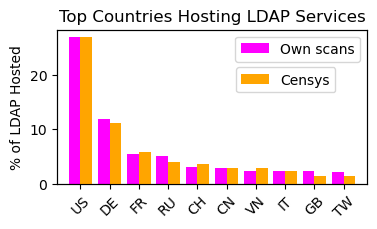

In [ ]:
top_10cc_goscanner = goscanner_country_pdf.head(10)["country"].to_list()
censys_top_country = censys_country_pdf[censys_country_pdf["country"].isin(top_10cc_goscanner)]

fig, ax1 = plt.subplots(figsize=(4,2))
ax2 = ax1.twinx()
width = 0.4
p1 = goscanner_country_pdf.head(10).percentage.plot(kind='bar', color='magenta', ax=ax1, width=width, position=1, align='center')
p2 = censys_top_country.percentage.plot(kind='bar', color='orange', ax=ax2, width=width, position=0, align='center')
ax1.set_ylabel('% of LDAP Hosted')
ax1.set_title('Top Countries Hosting LDAP Services')
ax1.tick_params(axis='x', rotation=45)
margin = (1 - width) + width / 2
ax1.set_xlim(-margin, len(top_10cc_goscanner) - 1 + margin)
ax2.set_xlim(-margin, len(top_10cc_goscanner) - 1 + margin)
ax1.set_xticklabels(top_10cc_goscanner)
ax2.set_yticks([])
ax2.set_yticklabels([])
p1.legend(['Own scans'], bbox_to_anchor=(1.0, 1.0))
p2.legend(['Censys'], bbox_to_anchor=(0.92, 0.8))
fig.savefig("output/ldap_country.pdf", dpi=300, bbox_inches='tight')
fig.show()

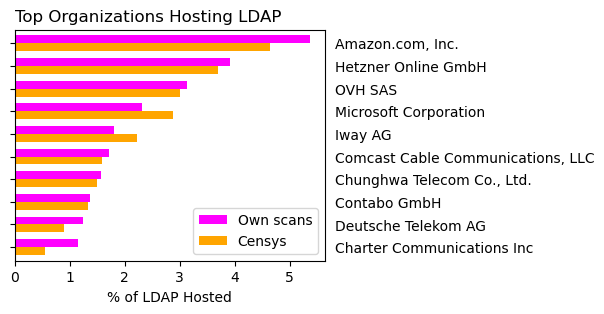

In [ ]:
top_10org_goscanner = goscanner_org_pdf.head(10)["org"].to_list()
censys_top_org = censys_org_pdf[censys_org_pdf["org"].isin(top_10org_goscanner)]
top_org_pdf = pd.DataFrame({
        "Own scans": goscanner_org_pdf.head(10)["percentage"].to_list(),
        "Censys": censys_top_org["percentage"].to_list(), 
     }, index=top_10org_goscanner)

width = 0.7
ax1 = top_org_pdf.plot.barh(width=width, color=['magenta', 'orange'], figsize=(4,3))
ax1.invert_yaxis()
ax1.set_title('Top Organizations Hosting LDAP', loc='left')
ax1.tick_params(axis='y', labelright=True, labelleft=False)  
ax1.set_xlabel('% of LDAP Hosted')
fig = ax1.get_figure()
fig.savefig("output/ldap_org.pdf", dpi=300, bbox_inches='tight')
fig.show()

#### Org from perspective of country

In [ ]:
def get_org_in_cc_dict(df, dataset):
    cc_cnt_dict = defaultdict(int)
    for item in [v.dropna().to_dict() for k,v in censys_country_pdf.iterrows()]:
        try:
            cc_cnt_dict[item["country"]] += item["count"]
        except KeyError:
            # unknown country
            pass

def country_percentage(country, count):
    if country == "NaN":
        return 0
    return count / cc_cnt_dict[country] * 100

org_country_outsourced_pdf["percentage"] = org_country_outsourced_pdf[["country", "count"]].apply(lambda x: country_percentage(*x), axis=1)
display(org_country_outsourced_pdf.head(10))

### DNS - CUIDS only

In [ ]:
def get_tld(domain):
    return tldextract.extract(domain).suffix

get_tld_udf = psf.udf(get_tld, pst.StringType())

censys_df.persist()
ldap_dns_df = censys_df.filter((psf.col("dns_name").isNotNull()) & (psf.col("dns_name") != ""))
ldap_dns_df = ldap_dns_df.withColumn("fdns_tlds", get_tld_udf(psf.col("dns_name")))

ldap_dns_pdf = ldap_dns_df.groupBy("fdns_tlds").count().sort(psf.col("count").desc()).pandas_api()
total = ldap_dns_pdf["count"].sum()
ldap_dns_pdf["percentage"] = ldap_dns_pdf["count"] / total * 100
ldap_dns_pdf.to_csv("../dataset/processing/censys_ldap_dns", index=False)
censys_df.unpersist()

NameError: name 'censys_df' is not defined

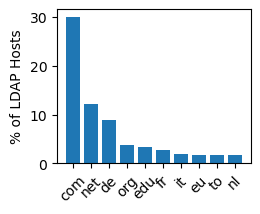

In [ ]:
ldap_dns_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_ldap_dns/*csv")])

top_tlds = ldap_dns_pdf.head(10)
fig, ax = plt.subplots(figsize=(2.5,2))
ax.set_xticks(range(len(top_tlds["fdns_tlds"])))
ax.set_xticklabels(top_tlds["fdns_tlds"], rotation=45) 
#plt.yticks(rotation=0)
ax.bar(top_tlds['fdns_tlds'], top_tlds['percentage'])
ax.set_ylabel('% of LDAP Hosts')
#ax.set_xlabel('TLD')
#ax.set_title('% of LDAP Hosts\nper TLD - CUIDS')
fig.savefig("output/ldap_tld.pdf", dpi=300, bbox_inches='tight')
fig.show()

### Outsourcing analysis

In [ ]:
def method_1(leaf_cert_names, rdns_list, fdns_list):
#    varlist = [leaf_cert_names, rdns_list, fdns_list]
#    if rdns_list is not None and len(rdns_list) == 0:
#        x['r_dns_names'] = None
#    if fdns_list is not None and len(fdns_list) == 0:
#        x['dns_names'] = None

    # leaf_cert_names is a list of lists; hence, disentangle it
    flat_leaf_cert_names = []
    for lcn in leaf_cert_names:
        if lcn is not None:
            for name in lcn:
                flat_leaf_cert_names.append(name)

    leaf_cert_set = set(flat_leaf_cert_names) if flat_leaf_cert_names is not None else set()
    rdns_set = set(rdns_list) if rdns_list is not None else set()
    fdns_set = set(fdns_list) if fdns_list is not None else set()

    _x = leaf_cert_set
    _y = rdns_set.union(fdns_set)

    if len(_x) > 0:
        res_set_x = set()
        for item in _x:
            if item is None:
                continue
            extract = tldextract.extract(item)
            domain = extract.domain
            suffix = extract.suffix
            if domain != '' and suffix != '':
                sld_tld = f"{extract.domain}.{extract.suffix}"
                res_set_x.add(sld_tld)
        res_set_x = list(res_set_x) if len(res_set_x) > 0 else None
    else:
        res_set_x = None

    res_set_x = [item.lower() for item in res_set_x] if res_set_x is not None else None
    #x['x_set'] = res_set_x

    if len(_y) > 0:
        res_set_y = set()
        for item in _y:
            if item is None:
                continue
            extract = tldextract.extract(item)
            domain = extract.domain
            suffix = extract.suffix
            if domain != '' and suffix != '':
                sld_tld = f"{extract.domain}.{extract.suffix}"
                res_set_y.add(sld_tld)
        res_set_y = list(res_set_y) if len(res_set_y) > 0 else None
    else:
        res_set_y = None

    res_set_y = [item.lower() for item in res_set_y] if res_set_y is not None else None
    #x['y_set'] = res_set_y

    if res_set_y is not None and res_set_x is not None:
        len_set_x = len(res_set_x)
        counter = 0
        for item in res_set_x:
            if item in res_set_y:
                counter += 1
        outsourced = 'Outsource evidence' if counter != len_set_x else 'No outsource evidence'
        #x['outsourced_a'] = outsourced
    else:
        #x['outsourced_a'] = 'invalid'
        outsourced = 'Invalid'
    return outsourced


method_1_udf = psf.udf(method_1, pst.StringType())

In [ ]:
def method_2(rdns_names, fdns_names):
    if rdns_names is None:
        rdns_list = None
    else:
        rdns_set = set()
        for item in rdns_names:
            if item is None:
                continue
            extract = tldextract.extract(item)
            domain = extract.domain
            suffix = extract.suffix
            if domain != '' and suffix != '':
                sld_tld = f"{extract.domain}.{extract.suffix}"
                rdns_set.add(sld_tld)
        rdns_list = list(rdns_set) if len(rdns_set) > 0 else None

    if fdns_names is None:
        fdns_list = None
        fdns_tld_list = None
    else:
        fdns_set = set()
        fdns_tld_set = set()
        for item in fdns_names:
            if item is None:
                continue
            extract = tldextract.extract(item)
            domain = extract.domain
            suffix = extract.suffix
            if domain != '' and suffix != '':
                sld_tld = f"{extract.domain}.{extract.suffix}"
                fdns_set.add(sld_tld)
                fdns_tld_set.add(extract.suffix)
        fdns_list = list(fdns_set) if len(fdns_set) > 0 else None
        fdns_tld_list = list(fdns_tld_set) if len(fdns_tld_set) > 0 else None

    rdns_list = [item.lower() for item in rdns_list] if rdns_list is not None else None
    fdns_list = [item.lower() for item in fdns_list] if fdns_list is not None else None  
    #x['rdns_domains'] = rdns_list # =: x
    #x['fdns_domains'] = fdns_list # =: y
    #x['fdns_tlds'] = fdns_tld_list

    outsourced = 'Invalid'
    if rdns_list is not None and fdns_list is not None:
        target = len(rdns_list)
        counter = 0
        for item in rdns_list:
            if item in fdns_list:
                counter += 1
        if target == counter:
            fdns_list = set(fdns_list)
            rdns_list = set(rdns_list)
            res = fdns_list - rdns_list
            if len(res) > 0:
                #x['outsourced_b'] = True
                outsourced = 'Outsource evidence'
            else:
                #x['outsourced_b'] = False
                outsourced = 'No outsource evidence'
        else:
            #x['outsourced_b'] = True
            outsourced = 'Outsource evidence'
    else:
        #x['outsourced_b'] = 'invalid'
        outsourced = 'Invalid'

    return outsourced


method_2_udf = psf.udf(method_2, pst.StringType())

In [ ]:
censys_compact_df = censys_compact_df.withColumn("method_1", method_1_udf(psf.col("leaf_data_names"), psf.col("r_dns_names"), psf.col("dns_names")))
censys_compact_df = censys_compact_df.withColumn("method_2", method_2_udf(psf.col("r_dns_names"), psf.col("dns_names")))

In [ ]:
m1_pdf = censys_compact_df.groupBy("method_1").count().to_pandas_on_spark()
m2_pdf = censys_compact_df.groupBy("method_2").count().to_pandas_on_spark()

/usr/local/spark/python/pyspark/sql/dataframe.py:5719: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


In [ ]:
print("Applicability")
m1_total = m1_pdf["count"].sum()
m1_pdf["percentage"] = m1_pdf["count"] / m1_total * 100
display(m1_pdf)
m2_total = m2_pdf["count"].sum()
m2_pdf["percentage"] = m2_pdf["count"] / m2_total * 100
display(m2_pdf)
print(m2_total)

assert m1_total == m2_total

Applicability


,method_1,count,percentage
0,Outsource evidence,91626,16.856184
1,No outsource evidence,185545,34.134204
2,Invalid,266404,49.009612


,method_2,count,percentage
0,Outsource evidence,111235,20.463597
1,No outsource evidence,173643,31.944626
2,Invalid,258697,47.591777


543575


#### Outsourcing from perspective of country

In [ ]:
org_country_outsourced_pdf = censys_compact_df.filter((psf.col("method_1") == "Outsource evidence") | (psf.col("method_2") == "Outsource evidence")).groupBy(["org", "country"]).count().sort(psf.col("count").desc()).toPandas()

In [ ]:
cc_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in censys_country_pdf.iterrows()]:
    try:
        cc_cnt_dict[item["country"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def country_percentage(country, count):
    if country == "NaN":
        return 0
    return count / cc_cnt_dict[country] * 100

org_country_outsourced_pdf["percentage"] = org_country_outsourced_pdf[["country", "count"]].apply(lambda x: country_percentage(*x), axis=1)
display(org_country_outsourced_pdf.head(10))

,org,country,count,percentage
0,"Amazon.com, Inc.",US,12226,8.36
1,OVH SAS,FR,10522,33.07
2,Hetzner Online GmbH,DE,10059,16.55
3,home.pl S.A.,PL,8755,56.20
4,"Chunghwa Telecom Co., Ltd.",TW,5857,38.91
5,Contabo GmbH,DE,5129,8.44
6,"Comcast Cable Communications, LLC",US,3565,2.44
7,Deutsche Telekom AG,DE,2618,4.31
8,Charter Communications Inc,US,2314,1.58
9,Strato AG,DE,1866,3.07


In [ ]:
print(cc_cnt_dict["US"], cc_cnt_dict["DE"], cc_cnt_dict["FR"], cc_cnt_dict["PL"], cc_cnt_dict["TW"])

146306 60797 31815 15578 15051


#### Outsourcing combined methods

In [ ]:
_outs_censys_df = censys_compact_df.select("org", "tls_version", "tls_cipher", "tls_signature_self_signed", "method_1", "method_2")

In [ ]:
df3 = _outs_censys_df.select("org", "method_1", "method_2",
                             psf.explode_outer(psf.arrays_zip(
                                                _outs_censys_df.tls_version,
                                                _outs_censys_df.tls_cipher,
                                                _outs_censys_df.tls_signature_self_signed)))
outs_censys_df = df3.select("org", "method_1", "method_2", "col.tls_version", "col.tls_cipher", "col.tls_signature_self_signed")
outs_censys_df.persist()

DataFrame[org: string, method_1: string, method_2: string, tls_version: string, tls_cipher: string, tls_signature_self_signed: boolean]

##### Oursource and self-signed

In [ ]:
# by filtering not null, I'll get different percentages dictionary (see "lookout for discrepancies" below)
outs_censys_df.filter(psf.col("tls_signature_self_signed").isNotNull()) \
              .groupBy(["org", "tls_signature_self_signed"]) \
              .count() \
              .sort(psf.col("count").desc()) \
              .toPandas().to_csv("../dataset/processing/censys_org_ssign.csv")

In [ ]:
org_ssign_pdf = pd.read_csv("../dataset/processing/censys_org_ssign.csv", index_col=0)

org_ssign_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in org_ssign_pdf.iterrows()]:
    try:
        org_ssign_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_ssign_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_ssign_cnt_dict[org] * 100, 2)

org_ssign_pdf["percentage"] = org_ssign_pdf[["org", "count"]].apply(lambda x: org_ssign_percentage(*x), axis=1)
display(org_ssign_pdf[org_ssign_pdf["tls_signature_self_signed"] == True].sort_values("count", ascending=False).head(10))

,org,tls_signature_self_signed,count,percentage
6,OVH SAS,True,22742,23.37
8,"Chunghwa Telecom Co., Ltd.",True,19922,25.78
9,Hetzner Online GmbH,True,17448,17.70
12,Shenzhen Tencent Computer Systems Company Limited,True,15683,86.31
18,Contabo GmbH,True,11616,26.67
21,Microsoft Corporation,True,10267,45.08
24,"Amazon.com, Inc.",True,9506,25.90
25,"No.31,Jin-rong Street",True,9470,47.27
27,Deutsche Telekom AG,True,9096,35.03
29,"Comcast Cable Communications, LLC",True,7997,34.03


##### Data preparation

In [ ]:
# TODO
outs_censys_df.filter(psf.col("tls_cipher").isNotNull()) \
              .select(["org", "tls_cipher", "tls_version", "method_1", "method_2"]) \
              .to_pandas_on_spark() \
              .dropna(subset=["tls_cipher"], inplace=True) \
              .apply(parse_tls_cipher, axis=1) \
              .toPandas().to_csv("../dataset/censys/processing/censys_org_tls_outs.csv")

In [ ]:
try:
    org_tls_outs_pdf
except:
    org_tls_outs_pdf = pd.read_csv("../dataset/censys/processing/censys_org_tls_outs.csv", index_col=0)

org_tls_outs_pdf.dropna(subset=["tls_cipher"], inplace=True)
org_tls_outs_pdf = org_tls_outs_pdf.apply(parse_tls_cipher, axis=1)

In [ ]:
org_tls_outs_pdf.to_csv("../dataset/censys/processing/censys_org_tls_outs.csv")

In [ ]:
try:
    org_tls_outs_pdf
except:
    org_tls_outs_pdf = pd.read_csv("../dataset/censys/processing/censys_org_tls_outs.csv", index_col=0)

def combined_methods(method1, method2):
    if method1 == "Outsource evidence" or method2 == "Outsource evidence":
        return True
    return False

def tls_version_weak(tls_version):
    if tls_version == "TLSv1_0" or tls_version == "TLSv1_1":
        return True
    return False

org_tls_outs_pdf["combined"] = org_tls_outs_pdf[['method_1', 'method_2']].apply(lambda x: combined_methods(*x), axis=1)
org_tls_outs_pdf["tls_version_weak"] = org_tls_outs_pdf["tls_version"].apply(tls_version_weak)

In [ ]:
aggr_org_outs_pdf = org_tls_outs_pdf.groupby(["org", "combined"]).size().reset_index(name="count").sort_values("count", ascending=False)
org_outs_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in aggr_org_outs_pdf.iterrows()]:
    try:
        org_outs_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_outs_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_outs_cnt_dict[org] * 100, 2)

aggr_org_outs_pdf["percentage"] = aggr_org_outs_pdf[["org", "count"]].apply(lambda x: org_outs_percentage(*x), axis=1)

In [ ]:
display(aggr_org_outs_pdf[aggr_org_outs_pdf["combined"] == True].sort_values("count", ascending=False).head(10))

,org,combined,count,percentage
4343,Hetzner Online GmbH,True,64103,65.04
7603,OVH SAS,True,58673,60.29
12495,home.pl S.A.,True,53235,97.02
1941,"Chunghwa Telecom Co., Ltd.",True,42867,55.47
2269,Contabo GmbH,True,27500,63.13
699,"Amazon.com, Inc.",True,25366,69.11
12579,netcup GmbH,True,13466,73.76
2759,Deutsche Telekom AG,True,13463,51.85
2146,"Comcast Cable Communications, LLC",True,13346,56.79
6087,"Linode, LLC",True,10469,68.36


In [ ]:
print(org_outs_cnt_dict["Amazon.com, Inc."], org_outs_cnt_dict["OVH SAS"], org_outs_cnt_dict["Hetzner Online GmbH"])

36706 97321 98558


##### Outsource, weak cipher and weak TLS version

In [ ]:
aggr_org_tls_cipher_outs_pdf = org_tls_outs_pdf.groupby(["org", "combined", "cipher_weak", "tls_version_weak"]).size().reset_index(name="count").sort_values("count", ascending=False)
org_tls_cipher_outs_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in aggr_org_tls_cipher_outs_pdf.iterrows()]:
    try:
        org_tls_cipher_outs_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_tls_cipher_outs_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_tls_cipher_outs_cnt_dict[org] * 100, 2)

aggr_org_tls_cipher_outs_pdf["percentage"] = aggr_org_tls_cipher_outs_pdf[["org", "count"]].apply(lambda x: org_tls_cipher_outs_percentage(*x), axis=1)

In [ ]:
tmp = aggr_org_tls_cipher_outs_pdf[(aggr_org_tls_cipher_outs_pdf["combined"] == True) & (aggr_org_tls_cipher_outs_pdf["cipher_weak"] == True) & (aggr_org_tls_cipher_outs_pdf["tls_version_weak"] == True)]
display(tmp[(tmp["org"] == "Amazon.com, Inc.") | (tmp["org"] == "Hetzner Online GmbH") | (tmp["org"] == "OVH SAS")])
display(tmp.sort_values(["count", "percentage"], ascending=False).head(10))

,org,combined,cipher_weak,tls_version_weak,count,percentage
7311,Hetzner Online GmbH,True,True,True,1263,1.28
12760,OVH SAS,True,True,True,1157,1.19
1131,"Amazon.com, Inc.",True,True,True,204,0.56


,org,combined,cipher_weak,tls_version_weak,count,percentage
16402,Six Degrees Technology Group Limited,True,True,True,5150,34.16
3273,"Chunghwa Telecom Co., Ltd.",True,True,True,3155,4.08
3642,"Comcast Cable Communications, LLC",True,True,True,1359,5.78
7311,Hetzner Online GmbH,True,True,True,1263,1.28
1758,"Badger Internet, Inc.",True,True,True,1258,59.90
12760,OVH SAS,True,True,True,1157,1.19
7953,IP worldcom SA,True,True,True,864,41.68
3162,Charter Communications Inc,True,True,True,829,5.02
12318,"No.31,Jin-rong Street",True,True,True,622,3.11
3987,Cox Communications Inc.,True,True,True,467,8.75


##### Outsource and weak cipher

In [ ]:
aggr_org_cipher_outs_pdf = org_tls_outs_pdf.groupby(["org", "combined", "cipher_weak"]).size().reset_index(name="count").sort_values("count", ascending=False)

org_cipher_outs_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in aggr_org_cipher_outs_pdf.iterrows()]:
    try:
        org_cipher_outs_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_cipher_outs_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_cipher_outs_cnt_dict[org] * 100, 2)

aggr_org_cipher_outs_pdf["percentage"] = aggr_org_cipher_outs_pdf[["org", "count"]].apply(lambda x: org_cipher_outs_percentage(*x), axis=1)

In [ ]:
display(aggr_org_cipher_outs_pdf[(aggr_org_cipher_outs_pdf["combined"] == True) & (aggr_org_cipher_outs_pdf["cipher_weak"] == True)].sort_values("count", ascending=False).head(10))

,org,combined,cipher_weak,count,percentage
2942,"Chunghwa Telecom Co., Ltd.",True,True,12368,16.00
11463,OVH SAS,True,True,7389,7.59
14764,Six Degrees Technology Group Limited,True,True,6080,40.33
6569,Hetzner Online GmbH,True,True,5329,5.41
3268,"Comcast Cable Communications, LLC",True,True,4186,17.81
1043,"Amazon.com, Inc.",True,True,3297,8.98
3451,Contabo GmbH,True,True,2824,6.48
2850,Charter Communications Inc,True,True,2229,13.50
1162,Aptum Technologies,True,True,1895,61.09
9995,Microsoft Corporation,True,True,1559,6.85


##### Outsource and weak TLS version

In [ ]:
aggr_org_tls_outs_pdf = org_tls_outs_pdf.groupby(["org", "combined", "tls_version_weak"]).size().reset_index(name="count").sort_values("count", ascending=False)

org_tls_outs_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in aggr_org_tls_outs_pdf.iterrows()]:
    try:
        org_tls_outs_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_tls_outs_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_tls_outs_cnt_dict[org] * 100, 2)

aggr_org_tls_outs_pdf["percentage"] = aggr_org_tls_outs_pdf[["org", "count"]].apply(lambda x: org_tls_outs_percentage(*x), axis=1)

In [ ]:
tmp = aggr_org_tls_outs_pdf[(aggr_org_tls_outs_pdf["combined"] == True) & (aggr_org_tls_outs_pdf["tls_version_weak"] == True)]
display(tmp[(tmp["org"] == "Amazon.com, Inc.") | (tmp["org"] == "Hetzner Online GmbH") | (tmp["org"] == "OVH SAS")])
display(tmp.sort_values(["count", "percentage"], ascending=False).head(10))

,org,combined,tls_version_weak,count,percentage
5290,Hetzner Online GmbH,True,True,1263,1.28
9254,OVH SAS,True,True,1157,1.19
818,"Amazon.com, Inc.",True,True,204,0.56


,org,combined,tls_version_weak,count,percentage
11900,Six Degrees Technology Group Limited,True,True,5150,34.16
2360,"Chunghwa Telecom Co., Ltd.",True,True,3155,4.08
2619,"Comcast Cable Communications, LLC",True,True,1359,5.78
5290,Hetzner Online GmbH,True,True,1263,1.28
1284,"Badger Internet, Inc.",True,True,1258,59.90
9254,OVH SAS,True,True,1157,1.19
5750,IP worldcom SA,True,True,864,41.68
2282,Charter Communications Inc,True,True,829,5.02
8931,"No.31,Jin-rong Street",True,True,622,3.11
2868,Cox Communications Inc.,True,True,467,8.75


##### lookout for discrepancies

In [ ]:
print(org_tls_outs_cnt_dict == org_ssign_cnt_dict)
print(org_tls_outs_cnt_dict == org_tls_cipher_outs_cnt_dict)
for k,v in org_tls_outs_cnt_dict.items():
    try:
        if v != org_ssign_cnt_dict[k]:
            print(k, v, org_ssign_cnt_dict[k])
    except:
        print(k, v, org_ssign_cnt_dict[k])


False
True
OVH SAS 97321 97316
Amazon.com, Inc. 36706 36699
netcup GmbH 18257 18199
Hostway Deutschland GmbH 270 247
Envia Tel GmbH 179 159
